In [1]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
import re
%matplotlib inline
pd.set_option('display.max_columns', 500)

# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [2]:
import pandas as pd
import csv, json, os, math, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2
import sqlite3, thread, urllib

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [3]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)
        

In [4]:
pandas.options.display.max_colwidth = 300
pandas.set_option('display.max_columns', 500)

# Read in 2018 US House boundaries

In [11]:
ush_2018 = gpd.read_file('voting/Remedial Plan Shapefile.shp').to_crs(epsg=4326)

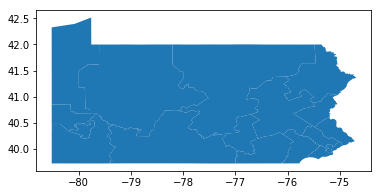

In [12]:
ush_2018.plot()

In [13]:
ush_2018

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,F18_AP_BLK,NH18_WHT,IDEAL_VALU,DEVIATION,F_DEVIATIO,F_18_AP_BL,F_NH18_WHT,geometry
0,1,655.201721,01,1.0,None,None,705687,543412,20074,474616,705688.0,-1.0,-0.000001,0.036941,0.873400,"POLYGON ((-75.48405700000001 40.418451, -75.479192 40.422939, -75.479049 40.423073, -75.475499 40.426399, -75.473145 40.428563, -75.472915 40.428775, -75.471053 40.430488, -75.471035 40.430503, -75.470972 40.430561, -75.469026 40.432359, -75.467159 40.434264, -75.46715 40.434274, -75.467108 40.4..."
1,2,65.945671,02,1.0,None,None,705688,526334,135399,258603,705688.0,0.0,0.000000,0.257249,0.491329,"POLYGON ((-74.980688 40.065007, -74.98070199999999 40.064878, -74.980706 40.064838, -74.980718 40.06472, -74.98073100000001 40.064592, -74.98081000000001 40.064389, -74.98090500000001 40.064269, -74.981022 40.063818, -74.981139 40.063683, -74.98114 40.063368, -74.98090500000001 40.06300700000001..."
2,3,54.538364,03,1.0,None,None,705688,568892,326217,187806,705688.0,0.0,0.000000,0.573425,0.330126,"POLYGON ((-75.206968 40.011372, -75.206914 40.011416, -75.20687100000001 40.01144800000001, -75.20679199999999 40.011512, -75.20628600000001 40.01192300000001, -75.206405 40.012002, -75.207599 40.012719, -75.207628 40.012736, -75.207728 40.012805, -75.20800800000001 40.012997, -75.20864899999999..."
3,4,480.801880,04,1.0,None,None,705687,543711,49311,443923,705688.0,-1.0,-0.000001,0.090693,0.816469,"POLYGON ((-75.48405700000001 40.418451, -75.48292499999999 40.417938, -75.48288700000001 40.417923, -75.482485 40.417686, -75.480785 40.416685, -75.47984099999999 40.41613, -75.477323 40.414648, -75.47653 40.414181, -75.474388 40.41297900000001, -75.47425800000001 40.412907, -75.47126 40.41114, ..."
4,5,221.704346,05,1.0,None,None,705688,541035,116060,377905,705688.0,0.0,0.000000,0.214515,0.698485,"POLYGON ((-75.502135 39.954367, -75.501051 39.954861, -75.499427 39.95560300000001, -75.49780199999999 39.956345, -75.496765 39.956819, -75.496719 39.95684, -75.495532 39.957382, -75.49434599999999 39.957924, -75.4939 39.958128, -75.49374299999999 39.958195, -75.493617 39.958253, -75.492351 39.9..."
5,6,922.566833,06,1.0,None,None,705688,528267,36673,420028,705688.0,0.0,0.000000,0.069421,0.795106,"POLYGON ((-75.46172900000001 40.103035, -75.461809 40.10247400000001, -75.461798 40.102346, -75.461795 40.102324, -75.461789 40.102255, -75.461788 40.102059, -75.46183000000001 40.101769, -75.461995 40.101498, -75.462361 40.101105, -75.462475 40.10095700000001, -75.46263 40.100578, -75.462637000..."
6,7,867.563293,07,1.0,None,None,705688,545100,32094,435449,705688.0,0.0,0.000000,0.058877,0.798842,"POLYGON ((-75.196803 40.60858, -75.19714999999999 40.60841600000001, -75.197287 40.608351, -75.19743200000001 40.60828300000001, -75.19759500000001 40.608205, -75.197654 40.608177, -75.197755 40.608129, -75.197802 40.60811200000001, -75.19782499999999 40.608103, -75.198019 40.608016, -75.198635 ..."
7,8,1117.711420,10,1.0,None,None,705688,545746,56209,446632,705688.0,0.0,0.000000,0.102995,0.818388,"POLYGON ((-76.701624 40.658082, -76.701566 40.658048, -76.70150700000001 40.658014, -76.70093300000001 40.65768, -76.698863 40.656477, -76.698173 40.656076, -76.696916 40.655321, -76.693145 40.653057, -76.691889 40.652303, -76.691603 40.652118, -76.69074600000002 40.651565, -76.69056 40.651445, ..."
8,9,1545.007080,11,1.0,None,None,705688,533533,18009,476409,705688.0,0.0,0.000000,0.033754,0.892933,"POLYGON ((-76.72162 40.12007, -76.721349 40.120606, -76.72094500000001 40.12141, -76.72054 40.122214, -76.720279 40.122734, -76.72027 40.122751, -76.720266 40.122757, -76.72025600000001 40.122778, -76.72025300000001 40.122785, -76.720139 40.123012, -76.72002500000001 40.123238, -76.7200200000000..."
9,10,9975.768550,12,1.0,None,None,705688,560669,12883,527131,705688.0,0.0,0.000000,0.022978,0.940182,"POLYGON ((-77.939424 40.775485, -77.93929 40.775576, -77.936916 40.777277, -77.93570200000001 40.778148, -77.927571 40.784001, -77.927249 40.7

In [14]:
# Create a GeoDataFrame that just has DISTRICT and geometry
ush_out_2018 = gpd.GeoDataFrame(ush_2018[['DISTRICT']], geometry=ush_2018.geometry,crs={'init': 'epsg:4326'})

In [15]:
ush_out_2018

,DISTRICT,geometry
0,01,"POLYGON ((-75.48405700000001 40.418451, -75.479192 40.422939, -75.479049 40.423073, -75.475499 40.426399, -75.473145 40.428563, -75.472915 40.428775, -75.471053 40.430488, -75.471035 40.430503, -75.470972 40.430561, -75.469026 40.432359, -75.467159 40.434264, -75.46715 40.434274, -75.467108 40.4..."
1,02,"POLYGON ((-74.980688 40.065007, -74.98070199999999 40.064878, -74.980706 40.064838, -74.980718 40.06472, -74.98073100000001 40.064592, -74.98081000000001 40.064389, -74.98090500000001 40.064269, -74.981022 40.063818, -74.981139 40.063683, -74.98114 40.063368, -74.98090500000001 40.06300700000001..."
2,03,"POLYGON ((-75.206968 40.011372, -75.206914 40.011416, -75.20687100000001 40.01144800000001, -75.20679199999999 40.011512, -75.20628600000001 40.01192300000001, -75.206405 40.012002, -75.207599 40.012719, -75.207628 40.012736, -75.207728 40.012805, -75.20800800000001 40.012997, -75.20864899999999..."
3,04,"POLYGON ((-75.48405700000001 40.418451, -75.48292499999999 40.417938, -75.48288700000001 40.417923, -75.482485 40.417686, -75.480785 40.416685, -75.47984099999999 40.41613, -75.477323 40.414648, -75.47653 40.414181, -75.474388 40.41297900000001, -75.47425800000001 40.412907, -75.47126 40.41114, ..."
4,05,"POLYGON ((-75.502135 39.954367, -75.501051 39.954861, -75.499427 39.95560300000001, -75.49780199999999 39.956345, -75.496765 39.956819, -75.496719 39.95684, -75.495532 39.957382, -75.49434599999999 39.957924, -75.4939 39.958128, -75.49374299999999 39.958195, -75.493617 39.958253, -75.492351 39.9..."
5,06,"POLYGON ((-75.46172900000001 40.103035, -75.461809 40.10247400000001, -75.461798 40.102346, -75.461795 40.102324, -75.461789 40.102255, -75.461788 40.102059, -75.46183000000001 40.101769, -75.461995 40.101498, -75.462361 40.101105, -75.462475 40.10095700000001, -75.46263 40.100578, -75.462637000..."
6,07,"POLYGON ((-75.196803 40.60858, -75.19714999999999 40.60841600000001, -75.197287 40.608351, -75.19743200000001 40.60828300000001, -75.19759500000001 40.608205, -75.197654 40.608177, -75.197755 40.608129, -75.197802 40.60811200000001, -75.19782499999999 40.608103, -75.198019 40.608016, -75.198635 ..."
7,10,"POLYGON ((-76.701624 40.658082, -76.701566 40.658048, -76.70150700000001 40.658014, -76.70093300000001 40.65768, -76.698863 40.656477, -76.698173 40.656076, -76.696916 40.655321, -76.693145 40.653057, -76.691889 40.652303, -76.691603 40.652118, -76.69074600000002 40.651565, -76.69056 40.651445, ..."
8,11,"POLYGON ((-76.72162 40.12007, -76.721349 40.120606, -76.72094500000001 40.12141, -76.72054 40.122214, -76.720279 40.122734, -76.72027 40.122751, -76.720266 40.122757, -76.72025600000001 40.122778, -76.72025300000001 40.122785, -76.720139 40.123012, -76.72002500000001 40.123238, -76.7200200000000..."
9,12,"POLYGON ((-77.939424 40.775485, -77.93929 40.775576, -77.936916 40.777277, -77.93570200000001 40.778148, -77.927571 40.784001, -77.927249 40.784218, -77.922938 40.787312, -77.921674 40.78822, -77.920844 40.788816, -77.920072 40.789364, -77.919318 40.7899, -77.917469 40.791233, -77.916546 40.7918..."


In [16]:
# Write out the 2018 US House geometry as a geojson file
ush_out_2018.to_file('voting/pa_us_house_boundaries_2018.geojson', driver="GeoJSON")

In [17]:
binarize_geojson_outlines('voting/pa_us_house_boundaries_2018.geojson', 
                          'voting/pa_us_house_boundaries_2018.bin')

Read 18 features from voting/pa_us_house_boundaries_2018.geojson
112242 segments
Created voting/pa_us_house_boundaries_2018.bin (112242 segments)


# Polling places

In [116]:
# Get old polling place locations
pp_2017 = gpd.read_file('voting/Polling_Place_Locations_May_2017.shp').to_crs(epsg=4326)

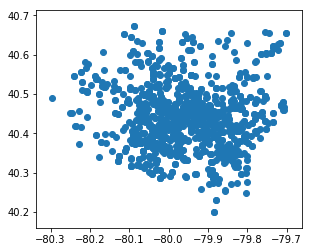

In [41]:
pp_2017.plot()

In [42]:
pp_2017

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
0,1001,1004.0,223,0,6,#2 ENGINE HOUSE,None,24,None,AMHERST,AVE,None,WEST VIEW,None,None,15229-1536,0279B00091000000,None,27,4,1.330635e+06,440422.004210,4.0,40.0,20.0,None,WEST VIEW,14 AMHERST AVE,2230006,1.330635e+06,440422.004210,2230006,24 AMHERST AVE,POINT (-80.04459975708832 40.51958490057336)
1,1002,1005.0,223,0,7,WEST VIEW ELEMENTARY SCHOOL GYM,None,47,None,CHALFANT,ST,None,WEST VIEW,None,None,15229,0280A00114000000,None,27,4,1.334159e+06,440888.627960,4.0,40.0,20.0,None,WEST VIEW,47 CHALFANT STREET,2230007,1.334159e+06,440888.627960,2230007,47 CHALFANT ST,POINT (-80.03197026853063 40.52111598498339)
2,1003,1006.0,225,0,1,BALDWIN COMM. U M CHURCH-WESLEY HL.,None,5001,None,BAPTIST,RD,None,PITTSBURGH,None,None,15236-1717,0249S00160000000,None,34,1,1.341541e+06,381004.441744,18.0,37.0,22.0,None,WHITEHALL,5001 BAPTIST RD,2250001,1.341541e+06,381004.441744,2250001,5001 BAPTIST RD,POINT (-79.99994119350922 40.3573080268444)
3,1004,1007.0,225,0,2,ST. GABRIEL OF THE SORROW VIR SCH,None,5200,None,GREENRIDGE,DR,None,PITTSBURGH,None,None,15236-1742,0249R00224000002,None,34,1,1.339777e+06,380643.921640,18.0,37.0,22.0,None,WHITEHALL,5200 GREENRIDGE DR,2250002,1.339777e+06,380643.921640,2250002,5200 GREENRIDGE DR,POINT (-80.0062334032054 40.35619522924374)
4,1005,1008.0,225,0,3,BORO BLDG,None,100,None,BOROUGH PARK,DR,None,PITTSBURGH,None,None,15236-2013,0314E00100000000,None,34,1,1.347114e+06,378560.498948,18.0,37.0,22.0,None,WHITEHALL,100 BOROUGH PARK DR,2250003,1.347114e+06,378560.498948,2250003,100 BOROUGH PARK DR,POINT (-79.97972900445221 40.35098943665007)
5,1006,1009.0,225,0,4,BORO BLDG,None,100,None,BOROUGH PARK,DR,None,PITTSBURGH,None,None,15236-2013,0314E00100000000,None,34,1,1.346993e+06,378560.498948,18.0,37.0,22.0,None,WHITEHALL,100 BOROUGH PARK DR,2250004,1.346993e+06,378560.498948,2250004,100 BOROUGH PARK DR,POINT (-79.98016132404423 40.35098108293546)
6,1007,1010.0,225,0,5,BALDWIN HIGH SCHOOL GYM HALL,None,4653,None,CLAIRTON,BLVD,None,PITTSBURGH,None,None,15236-2149,0247P00200000000,None,34,1,1.347664e+06,380228.037400,18.0,37.0,36.0,None,WHITEHALL,4653 CLAIRTON BLVD,2250005,1.347664e+06,380228.037400,2250005,4653 CLAIRTON BLVD,POINT (-79.97790667249754 40.35560353933538)
7,1008,1011.0,225,0,6,BALDWIN HIGH SCHOOL GYM HALL,None,4653,None,CLAIRTON,BLVD,None,PITTSBURGH,None,None,15236-2149,0247P00200000000,None,34,1,1.347574e+06,380371.983290,18.0,37.0,36.0,None,WHITEHALL,4653 CLAIRTON BLVD,2250006,1.347574e+06,380371.983290,2250006,4653 CLAIRTON BLVD,POINT (-79.97824078788069 40.35599235126165)
8,1009,1012.0,225,0,7,CANONGATE APT-PARTY RM.,None,200,None,WHITE HAMPTON,LN,None,PITTSBURGH,None,None,15236-1575,0189N00050000000,None,34,1,1.342282e+06,383764.085281,18.0,37.0,22.0,None,WHITEHALL,200 WHITE HAMPTON LN,2250007,1.342282e+06,383764.085281,2250007,200 WHITE HAMPTON LN,POINT (-79.99753522747905 40.36493266801937)
9,1010,1013.0,225,0,8,WHITEHALL ELEMENTARY SCHOOL,None,4900,None,CURRY,RD,None,PITTSBURGH,None,None,15236-1817,0315F00115000000,None,34,1,1.343279e+06,379339.210060,18.0,37.0,22.0,None,WHITEHALL,4900 CURRY RD,2250008,1.343279e+06,379339.210060,2250008,4900 CURRY RD,POINT (-79.9935527513839 40.35285979665043)


In [117]:
pp_2017[pp_2017.MWD2.duplicated()]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
1235,913,916.0,188,19,26,BROOKLINE TERRACE,None,920,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097D00067000S00,None,12,7,1.336626e+06,393957.81808,14.0,42.0,22.0,None,PITTSBURGH,920 BROOKLINE BLVD,1881926,1.336626e+06,393957.81808,1881926,920 BROOKLINE BLVD,POINT (-80.01876370240662 40.39250864644669)


In [120]:
pp_2017[pp_2017.MWD2==1881926]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
618,296,296.0,188,19,26,BROOKLINE U.P. CHURCH HALL,None,1036,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097H00001000000,None,12,7,1.337211e+06,393627.765169,14.0,42.0,22.0,None,PITTSBURGH,1036 BROOKLINE BLVD,1881926,1.337211e+06,393627.765169,1881926,1036 BROOKLINE BLVD,POINT (-80.01663330913114 40.39164418362884)


In [119]:
# Get rid of Brookline terrace based on discussion with David Hoyt
# on 10/25/18
pp_2017 = pp_2017[~(pp_2017.MWD2.duplicated())]

In [124]:
# Get intermediate polling place locations
pp_2018_05 = gpd.read_file('voting/PollingPlaces2018_May.shp').to_crs(epsg=4326)


In [122]:
pp_2018_05[pp_2018_05.MWD2.duplicated()]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
1235,913,916.0,188,19,26,BROOKLINE TERRACE,None,920,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097D00067000S00,None,12,7,1.336626e+06,393957.818078,14.0,42.0,22.0,None,PITTSBURGH,920 BROOKLINE BLVD,1881926,1.336626e+06,393957.818078,1881926,920 BROOKLINE BLVD,POINT (-80.01876370240662 40.39250864644669)


In [125]:
pp_2018_05 = pp_2018_05[~pp_2018_05.MWD2.duplicated()]

In [126]:
# Get new polling place locations
pp_2018_11 = gpd.read_file('voting/Allegheny_County_Polling_Place_Locations_November_2018.shp').to_crs(epsg=4326)


In [127]:
pp_2018_11[pp_2018_11.MWD2.duplicated()]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
1235,913,916.0,188,19,26,BROOKLINE TERRACE,None,920,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097D00067000S00,None,12,7,1.336626e+06,393957.818078,14.0,42.0,22.0,None,PITTSBURGH,920 BROOKLINE BLVD,1881926,1.336626e+06,393957.818078,1881926,920 BROOKLINE BLVD,POINT (-80.01876370240662 40.39250864644669)


In [128]:
pp_2018_11 = pp_2018_11[~pp_2018_11.MWD2.duplicated()]

In [129]:
pp_2018_m = pd.merge(pp_2018_11,pp_2018_05[['MWD2','NewAddress']], on='MWD2', suffixes=('_18_11', '_18_05'),left_index=False, right_index=False, sort=False,copy=True, indicator=False,
                         validate=None)

In [130]:
pp_2018_2017_m = pd.merge(pp_2018_m,pp_2017[['MWD2','NewAddress']], on='MWD2', suffixes=('_18_m', '_17_05'),left_index=False, right_index=False, sort=False,copy=True, indicator=False,
                         validate=None)

In [135]:
# Rename NewAddress to NewAddress_17_05
pp_2018_2017_m=pp_2018_2017_m.rename(columns={'NewAddress':'NewAddress_17_05'})

In [132]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1881926]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress
618,296,296.0,188,19,26,TREE OF LIFE CHURCH,None,1036,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097H00001000000,None,12,7,1.337211e+06,393627.765169,14.0,42.0,22.0,None,PITTSBURGH,1036 BROOKLINE BLVD,1881926,1.337211e+06,393627.765169,1881926,1036 BROOKLINE BLVD,POINT (-80.01663330913114 40.39164418362884),1036 BROOKLINE BLVD,1036 BROOKLINE BLVD


In [138]:
# Changed since 2017_05
len(pp_2018_2017_m[pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_17_05])

59

In [141]:
pp_2018_2017_m['addr_changed_17'] = pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_17_05

In [139]:
# Changed since 2018_05
len(pp_2018_2017_m[pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_18_05])

31

In [142]:
pp_2018_2017_m['addr_changed_18'] = pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_18_05

In [155]:
pp_2018_2017_m[pp_2018_2017_m.addr_changed_18].sort_values(['MuniName','MWD2'])[['MuniName','MWD2','LocName','NewAddress_18_11','NewAddress_18_05','addr_changed_17','addr_changed_18','geometry']]

,MuniName,MWD2,LocName,NewAddress_18_11,NewAddress_18_05,addr_changed_17,addr_changed_18,geometry
332,BALDWIN BR,1040001,ST ALBERT THE GREAT,3198 SCHIECK ST,330 JOSEPH ST,True,True,POINT (-79.96146665668988 40.38668419098998)
333,BALDWIN BR,1040002,ST ALBERT THE GREAT,3198 SCHIECK ST,330 JOSEPH ST,True,True,POINT (-79.96146665668988 40.38668419098998)
756,BALDWIN BR,1040007,NORTH ZION LUTHERIAN CHURCH,5100 BROWNSVILLE RD,374 KNOEDLER RD,True,True,POINT (-79.98767936038728 40.34522021969623)
758,BALDWIN BR,1040010,NORTH ZION LUTHERIAN CHURCH,5100 BROWNSVILLE RD,374 KNOEDLER RD,True,True,POINT (-79.98766615923428 40.34538341612095)
759,BALDWIN BR,1040011,BALDWIN UNITED PRESBYTERIAN CHURCH,201 KNOEDLER RD,374 KNOEDLER RD,True,True,POINT (-79.98265275423823 40.34220958344338)
380,CARNEGIE,1180101,CARNEGIE BOROUGH BUILDING,1 VETERANS WAY,201 MAIN ST,True,True,POINT (-80.09248622354187 40.40437348496651)
381,CARNEGIE,1180104,CARNEGIE BOROUGH BUILDING,1 VETERANS WAY,201 MAIN ST,True,True,POINT (-80.09248622354187 40.40437348496651)
962,MCCANDLESS,1660202,INGOMAR ELEMENTRY SCHOOL,602 W INGOMAR RD,10375 PERRY HWY,True,True,POINT (-80.05354458285946 40.58208360252215)
1024,MT LEBANON,1730503,MT LEBANON LUTHERAN CHURCH,975 WASHINGTON RD,1100 WASHINGTON RD,True,True,POINT (-80.0480166542043 40.37373832898135)
1025,MT LEBANON,1730505,MT LEBANON LUTHERAN CHURCH,975 WASHINGTON RD,1100 WASHINGTON RD,True,True,POINT (-80.048114107356 40.37353177333422)


In [148]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1660201][['MuniName','MWD2','NewAddress_18_05','NewAddress_18_11','addr_changed_17','addr_changed_18','geometry']]

,MuniName,MWD2,NewAddress_18_05,NewAddress_18_11,addr_changed_17,addr_changed_18,geometry
961,MCCANDLESS,1660201,10375 PERRY HWY,10375 PERRY HWY,False,False,POINT (-80.05354114992568 40.60391226742988)


In [149]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==2280201][['MuniName','MWD2','NewAddress_18_05','NewAddress_18_11','addr_changed_17','addr_changed_18','geometry']]

,MuniName,MWD2,NewAddress_18_05,NewAddress_18_11,addr_changed_17,addr_changed_18,geometry
858,WILKINSBURG,2280201,1256 FRANKLIN AVE,1256 FRANKLIN AVE,False,False,POINT (-79.87451573119165 40.43750237177388)


In [156]:
len(pp_2018_2017_m[(pp_2018_2017_m['addr_changed_17']) & ~(pp_2018_2017_m['addr_changed_18'])])

29

In [152]:
# This was copied from http://localhost:8820/notebooks/projects/demographics/Voting-2018-AW3b-Polling.ipynb, 
# then modified to deal with addition of 18_05 data
def write_pp_csv(df, out_path):
    date_range = range(2017, 2019)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    out.write(",lat,lon,%s\n" % (",".join(map(str,date_range))))
    
    i=0
    for i in range(0,len(df)):
        coords = df['geometry'].iloc[i]
        lon = coords.x
        lat = coords.y
        mwd = df['MWD2'].iloc[i]
        
        # Write size row
        out_data=[mwd, lat, lon]
        for year in date_range:
            out_val = 20
            out_data.append(out_val)
        out.write('%s\n' % (",".join(map(str,out_data))))
        
        # Write color row: Color =1 for changed in 2018, .5 for changed in 2017, 0 for stable
        out_data=[mwd, lat, lon]
        color_val = 0
        if df['addr_changed_18'].iloc[i]:
            color_val=1
        elif df['addr_changed_17'].iloc[i]:
            color_val = 0.5
        
        for year in date_range:
            out_data.append(color_val)
        out.write('%s\n' % (",".join(map(str,out_data))))
    out.close()

In [153]:
write_pp_csv(pp_2018_2017_m, "voting/pa_ac_polling_places_2018b.csv")

# Deal with voting file from county

# Address mapping

In [5]:
# Key is string canonical address, value is a map: {'canonical_in_census_db': True/False,'canonical_in_google_db': True/False, 'other_addr_strings':Set, 'census_value':str, 'google_value':str
canonical_addr_map={}

In [6]:
def canonicalize_string(text):
    # Remove any leading or trailing whitespace, replace any internal whitespace with single spaces, upcase it all
    ret = re.sub("^\s+|\s+$", "", text)
    ret = re.sub("\s+", " ", ret)
    return ret.upper()

In [439]:
# Try to load canonical_addr_map originally created by 
#  http://localhost:8820/notebooks/projects/demographics/Fixup%20Address%20DB.ipynb
import pickle
pickle_file_path = 'assessments/canonical_addr_map_d.pickle'

In [8]:
# Load in canonical_addr_map
with open(pickle_file_path, 'rb') as handle:
    canonical_addr_map = pickle.load(handle)

In [440]:
# Save out canonical_addr_map
with open(pickle_file_path, 'wb') as handle:
    pickle.dump(canonical_addr_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# From http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb

# assessments/cd/AC Property Assessments_10012017.xls (which is actually TDF) from Amy Gottsegen and Randy Sargent buying a CD from the county assessors office
# assessments/Allegheny_County_Parcel_Boundaries.geojson from https://data.wprdc.org/dataset/allegheny-county-parcel-boundaries
import array, csv, datetime, json, math, numpy, os, random, re 
from dateutil.parser import parse
from shapely.geometry import mapping, shape
from PIL import Image
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas,numbers
from operator import itemgetter, attrgetter
import string
import calendar,time
from IPython.core.display import HTML

# Use geopandas.  Boilerplate from https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#heading=h.f50xoxwmcir
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', 500)

# Built-in time handling fails for times before 1900.  Use arrow instead.  
# See https://arrow.readthedocs.io/en/latest/ for info
import arrow
import dateparser

def LonLatToPixelXY(lonlat):
    (lon, lat) = lonlat
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

# This does the same as above, but takes a GeoJSON point (which is what centroid returns)
def PointToPixelXY(point):
    lon=point.x
    lat=point.y
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def GetCentroid(geometry):
    s = shape(geometry)
    return (s.centroid.x, s.centroid.y)   

def GetEpoch(date):
    return (date - datetime.datetime(1970, 1, 1)).total_seconds()

def HexToRgb(hex_string):
    rgb = colors.hex2color(hex_string)
    r,g,b = tuple([int(255*x) for x in rgb])
    return (r,g,b)

In [49]:
# Google addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#
from shapely.geometry import Point
import collections


# Google geocoding API to geocode an address
# Assumes key is in google_api_key.txt
# Use as second level lookup only for those which fail census lookup

re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_google(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    result=None
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['google_value']):
        result = json.loads(canonical_addr_map[caddr]['google_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or google address lookup service
        try:
            geocode_address_google.conn
        except:
            geocode_address_google.conn = sqlite3.connect('geocoding_cache')
            geocode_address_google.cur = geocode_address_google.conn.cursor()
            geocode_address_google.cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                                         ' (key PRIMARY KEY, value)'
                                         ' WITHOUT ROWID;'))
            geocode_address_google.conn.commit()

        geocode_address_google.cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = geocode_address_google.cur.fetchall()
        if rows:
            #print "Google: Found %r in cache" % (caddr)
            gval = rows[0][0]
            result = json.loads(gval)
        else:
            # Not in sqlite, ask google address service
            #print "Google: %r not found in cache, fetching" % (address)

            api_key = open('google-api-key-do-not-commit.txt').read()
            payload = {'address':caddr, 'key':api_key}
            result = json.load(urllib2.urlopen('https://maps.googleapis.com/maps/api/geocode/json?%s' % urllib.urlencode(payload)))
            # Keep the stringified version for the DB/canonical_addr_map
            gval = json.dumps(result)
            geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                         ' VALUES (?, ?);'),
                                         (caddr, gval))
            geocode_address_google.conn.commit()
            
            # If the result succeeded and generated a formatted address, cache under that key too
            try:
                if(result['status']=='OK'):
                    if(len(result['results'])== 1):
                        canonical = result['results'][0]['formatted_address']
                        #print "Google: Storing canonical addr of %r for %r" % (canonical, address)
                        geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                                             ' VALUES (?, ?);'),
                                                             (canonical, gval))
                        geocode_address_google.conn.commit()
                    else:
                        print "Google: Fetch %r seemed to succeed, but results empty or non-unique" % (address)

                else:
                    print "Google: Fetch %r failed" % (address)
                
            except:
                #pass
                raise
                
        # We had to resort to sqlite/google address service.  Add gval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':False,'canonical_in_google_db': True, 
                                       'census_value':None, 'google_value':gval}
        else:
            # Already there, presumably for census.  Add google value 
            canonical_addr_map[caddr]['canonical_in_google_db']=True
            canonical_addr_map[caddr]['google_value']=gval
 
    
    return result

def get_canonical_address_google(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_google(raw_addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            return(result['results'][0]['formatted_address'])
        else:
            return None
    except:
        return None

def get_canonical_zip_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            addr_comps = result['results'][0]['address_components']
            for i in range(0, len(addr_comps)):
                if('postal_code' in addr_comps[i]['types']):
                    return addr_comps[i]['short_name']
        
        return None
    except:
        return None
    
def get_canonical_coords_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            latlon = result['results'][0]['geometry']['location']
            if(latlon):
                return(Point(latlon['lng'], latlon['lat']))
        return None
    except Exception as e:
        print "Exception processing get_canonical_coords_google(%s): %s" % (addr, e)
        return None


In [11]:
# Census addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#

# Uses Census geocoding API to geocode an address

import sqlite3
import urllib,urllib2
import json
from shapely.geometry import Point
import collections

# Match if the string contains no alphanumerics
re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_census(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['census_value']):
        result = json.loads(canonical_addr_map[caddr]['census_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or census address lookup service
        try:
            geocode_address_census.sqlite
        except:
            geocode_address_census.sqlite = {}

        tpid = '%d.%s' % (os.getpid(), thread.get_ident())
        if not tpid in geocode_address_census.sqlite:
            conn = sqlite3.connect('geocoding_cache_census')
            cur = conn.cursor()
            geocode_address_census.sqlite[tpid] = { 'conn': conn, 'cur': cur }

            cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                         ' (key PRIMARY KEY, value)'
                         ' WITHOUT ROWID;'))
            conn.commit()
        else:
            conn = geocode_address_census.sqlite[tpid]['conn']
            cur = geocode_address_census.sqlite[tpid]['cur']

        cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = cur.fetchall()
        if rows:
            cval = rows[0][0]
        else:
            payload = {'address':caddr, 'benchmark':4, 'format':'json'}
            result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
            cval = json.dumps(result)

            cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                         ' VALUES (?, ?);'),
                        (caddr, cval))
            conn.commit()

            if len(result['result']['addressMatches']) == 1:
                canonical = result['result']['addressMatches'][0]['matchedAddress']
                cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                             ' VALUES (?, ?);'),
                             (canonical, cval))
                conn.commit()
            
        # We had to resort to sqlite/google address service.  Add cval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':True,'canonical_in_google_db': False, 
                                       'census_value':cval, 'google_value':None}
        else:
            # Already there, presumably for google.  Add census value 
            canonical_addr_map[caddr]['canonical_in_census_db']=True
            canonical_addr_map[caddr]['census_value']=cval

    
    return result

def cache_canonical_addresses(addrs):
    t = SimpleThreadPoolExecutor(25)
    for addr in addrs:
        if(not (pandas.isnull(addr) or re_noalnum.match(addr))):
            t.submit(geocode_address_census, addr)
        else:
            #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
            pass
    t.shutdown()

def get_canonical_address_census(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_census(raw_addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['matchedAddress'])
        else:
            return None
    except:
        return None

def get_canonical_zip_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['addressComponents']['zip'])
        else:
            return None
    except:
        return None

    
def get_canonical_coords_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            coords = result['result']['addressMatches'][0]['coordinates']
            return(Point(coords['x'], coords['y']))
        else:
            return None
    except:
        return None

################################################################################################################
# These can handle being passed a map with either census or google in it and dispatch to the right service

# TODO: Think if this is the right behavior: If handed a regular string do census lookup
# If handed a map, return census if non-null, then google if non-null
def get_canonical_address(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return addr['census']
        elif('google' in addr and not pd.isnull(addr['google'])):
            return addr['google']
    else:
        return(get_canonical_address_census(addr))

def get_canonical_zip(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_zip_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_zip_google(addr['google'])
    else:
        return(get_canonical_zip_census(addr))

def get_canonical_coords(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_coords_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_coords_google(addr['google'])
    else:
        return(get_canonical_coords_census(addr))

def canonicalize_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: get_canonical_address_census(' '.join(x)), axis=1)
    
    

In [12]:
# Create 'property_address_raw' and 'owner_address_raw' columns.  Call once per dataframe before calling
# canonicalize_addrs
def merge_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: canonicalize_string(' '.join(x)), axis=1)
    # Fix up PGH to be PITTSBURGH
    df[out_colname] = df[out_colname].str.replace('\s*PGH\s*,', ' PITTSBURGH,', regex=True)


# Deal with various versions of the voter DB

In [270]:
voters_addr_cols=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City', 'State','Zip_Code']
voters_dtype={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 'StreetNameComplete':numpy.str ,'City':numpy.str, 'State':numpy.str,'Zip_Code':numpy.str}

# 2009-07 is a special case. It was generated by 
#   http://localhost:8820/notebooks/projects/demographics/Import%20Fixed%20Width%20Voter%20Files.ipynb
# from a fixed width file.  City and state were together in a single field.
voters_addr_cols_2009=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City','Zip_Code']
voters_dtype_2009={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 
                   'StreetNameComplete':numpy.str ,'City':numpy.str,'Zip_Code':numpy.str,
                   'Dist1':numpy.str
                  }

voters_info = {
    '2018-10': {'path': 'voters/2018-10-cd/10_16_18VOTERS.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2018-08': {'path': 'voters/2018-08-cd/VOTERS8_14_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2018-03': {'path': 'voters/2018-03-cd/VOTERS3_5_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2017-11': {'path': 'voters/2017-11-cd/VOTERS11_30_2017.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2009-07': {'path': "voters/2009-07-cd/VOTERS07_22_2009.TXT", 
                'addr_cols': voters_addr_cols_2009,
                'dtype': voters_dtype_2009
               }
}

In [162]:
# Map month strings used on import of datasets to parsed dates
monthstr_to_date_map={'2009-07':dateparser.parse("7/22/2009"),
                      '2017-11':dateparser.parse("11/30/2017"),
                      '2018-03':dateparser.parse("3/5/2018"),
                      '2018-08':dateparser.parse("8/14/2018"), 
                      '2018-10':dateparser.parse("10/16/2018")
                     }

In [59]:
# Hold on to the dataframes associated with each month_str in a map
vdf_map={}

In [60]:
# Do fixup on Pitt addresses
def fixup_pitt_addresses(df):
    df['address_raw'] = df['address_raw'].str.replace('(^.*((PITT TOWERS)|(5TH AVE-MCCORMICK HALL)|(HOLLAND HALL)) PITTSBURGH PA 15213$)', '3990 FIFTH AVE PITTSBURGH PA 15213', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*AMOS HALL PITTSBURGH PA 15213$)', '3959 FIFTH AVE PITTSBURGH PA 15260', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*SUTHERLAND HALL PITTSBURGH PA 15213$)', '3725 SUTHERLAND DR PITTSBURGH PA 15213', regex=True)
    
    

In [61]:
def load_voters_info(month_str):
    if(not month_str in voters_info):
        print "No entry for %s in voters_info" % (month_str)
    path = voters_info[month_str]['path']
    vdf_map[month_str] = pandas.read_csv(path,sep='\t',dtype=voters_info[month_str]['dtype']).set_index('ID_Number')
    merge_addr_colset(vdf_map[month_str], voters_info[month_str]['addr_cols'], 'address_raw')
    fixup_pitt_addresses(vdf_map[month_str])
    return vdf_map[month_str]

In [69]:
# Key is voter ID, DOB:str, reg_date:str, reg_info:{month_str: {status: , party: }}, addresses:{month_str:address}}
voter_map = {}

In [34]:
def process_voting_record(apd, i, month_str):
    global voter_map

    # Generate set of interesting colnames we have in this data frame
    interesting_colnames=set(['address_raw','Voter_Status','Political_Party','Last_Date_Voted','Date_Last_Changed','Date_Of_Birth','Date_Registered'])
    colnames = set(apd.columns) & interesting_colnames

    voter_id = apd.iloc[i].name
        
    if(not voter_id in voter_map):
        # Make sure 'Date_Registered' is legit
        reg_date = None
        try:
            if(apd['Date_Registered'].iloc[i]!='nan'):
                reg_date = dateparser.parse(apd['Date_Registered'].iloc[i])
        except:
            reg_date = None

        if(not reg_date):
            print "Skipping %s, unparsable registration date %s" % (voter_id, apd['Date_Registered'].iloc[i])
            return

        # reg_date is fine, add an entry
        voter_map[voter_id]={'DOB':apd['Date_Of_Birth'].iloc[i], 'reg_date':reg_date, 'reg_info':{}, 'addresses':{}}
    
    voter_map[voter_id]['reg_info'][month_str] = {'status':apd['Voter_Status'].iloc[i],'party':apd['Political_Party'].iloc[i]}
    voter_map[voter_id]['addresses'][month_str] = apd['address_raw'].iloc[i]
    
def process_all_voting_records(apd,month_str):
    for i in range(0,len(apd)):
        process_voting_record(apd, i, month_str)

In [271]:
vdf_2018_10 = load_voters_info('2018-10')

In [16]:
vdf_2018_08 = load_voters_info('2018-08')

In [172]:
vdf_2018_03 = load_voters_info('2018-03')

In [23]:
vdf_2017_11 = load_voters_info('2017-11')

/home/rsargent/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (1,44) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [31]:
vdf_2009_07 = load_voters_info('2009-07')

In [165]:
# Check we have everything
for month_str in (['2018-10','2018-08','2018-03','2017-11','2009-07']):
    print "%s: %s" % (month_str, voters_info[month_str].keys())

2018-10: ['path', 'addr_cols', 'dtype']
2018-08: ['path', 'addr_cols', 'dtype']
2018-03: ['path', 'addr_cols', 'dtype']
2017-11: ['path', 'addr_cols', 'dtype']
2009-07: ['path', 'addr_cols', 'dtype']


In [35]:
# Process voting records
#for month_str in (['2018-03','2017-11']):
#for month_str in (['2018-08']):
for month_str in (['2009-07']):
    process_all_voting_records(vdf_map[month_str],month_str)

# Resolve Polling places

In [272]:
vdf_2018_10

,Title,Last_Name,First_Name,Middle_Name,Suffix,Sex,Date_Of_Birth,Date_Registered,Voter_Status,StatusChangeDate,Political_Party,House__,HouseNoSuffix,StreetNameComplete,Apt__,Address_Line_2,City,State,Zip_Code,MAddress_Line_1,MAddress_Line_2,MCity,MState,MZip_Code,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1,Dist2,Dist3,Dist4,Dist5,Dist6,Dist7,Dist8,Dist9,Dist10,Dist11,Dist12,Dist13,Dist14,Dist15,CustomData1,Date_Last_Changed,PhoneNumHome,PR_05_15_18,PR_05_15_18_VM,SP_03_13_18,SP_03_13_18_VM,SP_03_06_18,SP_03_06_18_VM,SP_01_23_18,SP_01_23_18_VM,GN_11_07_17,GN_11_07_17_VM,PR_05_16_17,PR_05_16_17_VM,GN_11_08_16,GN_11_08_16_VM,PR_04_26_16,PR_04_26_16_VM,GN_11_03_15,GN_11_03_15_VM,PR_05_19_15,PR_05_19_15_VM,GN_11_04_14,GN_11_04_14_VM,PR_05_20_14,PR_05_20_14_VM,GN_11_05_13,GN_11_05_13_VM,PR_05_21_13,PR_05_21_13_VM,GN_11_06_12,GN_11_06_12_VM,SP_08_07_12,SP_08_07_12_VM,PR_04_24_12,PR_04_24_12_VM,GN_11_08_11,GN_11_08_11_VM,PR_05_17_11,PR_05_17_11_VM,GN_11_02_10,GN_11_02_10_VM,address_raw
ID_Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108927574-02,NaN,AABAN,ZAIN,A,NaN,M,2/16/1999,1/26/2018,A,1/26/2018 3:0:3,D,155,,SENECA PL,NaN,NaN,MARS,PA,16046,NaN,NaN,NaN,NaN,NaN,REGIONAL LEARNING ALLIANCE,850 CRANBERRY WOODS RD,"WARRENDALE, PA 16066",NaN,1650005.0,NaN,SC50,MN165,MD212,LG28,SN38,CD17,CPC00,CAC02,2.0,NaN,1650005-1,NaN,NaN,NaN,7/10/2018 9:14:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155 SENECA PL MARS PA 16046
103133442-02,NaN,AAGAARD,MARIT,NaN,NaN,NaN,10/17/1975,7/24/2011,A,7/24/2011 6:0:0,D,427,,CENTER ST,NaN,NaN,PITTSBURGH,PA,15221,NaN,NaN,NaN,NaN,NaN,SISTER THEA BOWMAN SCHOOL LOBBY,721 REBECCA AVE,"PITTSBURGH, PA 15221",5/15/2018,2280205.0,NaN,SC83,MN228,MD210,LG24,SN43,CG18,CPC00,CAC10,2.0,NaN,2280205-1,NaN,NaN,NaN,7/14/2011 8:45:27,NaN,D,AP,NaN,NaN,NaN,NaN,NaN,NaN,D,AP,D,AP,D,AP,D,AP,NaN,NaN,D,AP,D,AP,NaN,NaN,NaN,NaN,D,AP,D,AP,NaN,NaN,D,AP,D,AP,NaN,NaN,NaN,NaN,427 CENTER ST PITTSBURGH PA 15221
102892955-02,NaN,AAMIR,TALHA,NaN,NaN,F,12/28/1991,9/28/2010,I,1/21/2016 12:6:44,NF,3990,A,5TH AVE PITT TOWERS,NaN,NaN,PITTSBURGH,PA,15213,NaN,NaN,NaN,NaN,NaN,WILLIAM PITT UNION 1ST FL,3959 FORBES AVE,"PITTSBURGH, PA 15213",11/2/2010,1880408.0,NaN,SC58,MN188,MD227,LG23,SN43,CG18,CPC03,CAC10,2.0,NaN,1880408-1,NaN,NaN,NaN,9/19/2010 8:43:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NF,AP,3990 FIFTH AVE PITTSBURGH PA 15213
020340986-02,NaN,AARON,ANDREA,NaN,NaN,F,8/11/1983,10/14/2004,A,8/15/2011 9:32:47,NF,5602,,DUNCAN ST,NaN,NaN,PITTSBURGH,PA,15201,NaN,NaN,NaN,NaN,NaN,ENGINE HOUSE #7,4603 STANTON AVE,"PITTSBURGH, PA 15201",11/8/2016,1881006.0,NaN,SC56,MN188,MD231,LG21,SN42,CG18,CPC07,CAC13,2.0,NaN,1881006-1,NaN,NaN,123820540,8/15/2011 9:32:47,4126091988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NF,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5602 DUNCAN ST PITTSBURGH PA 15201
003007111-02,NaN,AARON,BARBARA,A,NaN,F,7/27/1954,3/1/1984,A,3/1/1984 0:0:0,R,520,,HALLOCK ST,NaN,NaN,PITTSBURGH,PA,15211,NaN,NaN,NaN,NaN,NaN,WEST END SR COM CTR 1ST FL,80 WABASH ST,"PITTSBURGH , PA",11/8/2016,1882003.0,NaN,SC63,MN188,MD313,LG27,SN42,CG18,CPC02,CAC12,2.0,NaN,1882003-1,NaN,NaN,115112799,9/20/2000 0:0:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,520 HALLOCK ST PITTSBURGH PA 15211
020029602-02,NaN,AARON,CHARLES,F,NaN,M,6/15/1938,10/25/2003,A,10/25/2003 2:0:1,NO,100,,SOUTHERN HILANDS DR,NaN,NaN,PITTSBURGH,PA,15241,NaN,NaN,NaN,NaN,NaN,WESLEY INSTITUTE,245 JOHNSTON RD,"PITTSBURGH, PA 15241",3/13/2018,2150502.0,NaN,SC77,MN215,MD220,LG40,SN37,CG18,CPC00,CAC05,2.0,NaN,2150502-1,NaN,NaN,1

In [273]:
# Get rid of entries from vdf_2018_10 where 'Dist1' is null
vdf_2018_10 = vdf_2018_10[~pd.isna(vdf_2018_10['Dist1'])].copy()

In [274]:
# Create a version of vdf_2018_10 which has one entry per 'Dist1' value
pp_vdf_2018_10 = vdf_2018_10[~vdf_2018_10['Dist1'].duplicated()].copy()

In [277]:
pp_vdf_2018_10['MWD_vdf'] = pp_vdf_2018_10['Dist1'].astype('int')

In [268]:
len(pp_vdf_2018_10)

1322

In [217]:
# Strip white space from ends of 'PollingPlaceDescript'
pp_vdf_2018_10['PollingPlaceDescript']=pp_vdf_2018_10['PollingPlaceDescript'].str.strip()

In [269]:
pp_vdf_2018_10.sort_values(['City','Dist1'])[0:2]

,Title,Last_Name,First_Name,Middle_Name,Suffix,Sex,Date_Of_Birth,Date_Registered,Voter_Status,StatusChangeDate,Political_Party,House__,HouseNoSuffix,StreetNameComplete,Apt__,Address_Line_2,City,State,Zip_Code,MAddress_Line_1,MAddress_Line_2,MCity,MState,MZip_Code,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1,Dist2,Dist3,Dist4,Dist5,Dist6,Dist7,Dist8,Dist9,Dist10,Dist11,Dist12,Dist13,Dist14,Dist15,CustomData1,Date_Last_Changed,PhoneNumHome,PR_05_15_18,PR_05_15_18_VM,SP_03_13_18,SP_03_13_18_VM,SP_03_06_18,SP_03_06_18_VM,SP_01_23_18,SP_01_23_18_VM,GN_11_07_17,GN_11_07_17_VM,PR_05_16_17,PR_05_16_17_VM,GN_11_08_16,GN_11_08_16_VM,PR_04_26_16,PR_04_26_16_VM,GN_11_03_15,GN_11_03_15_VM,PR_05_19_15,PR_05_19_15_VM,GN_11_04_14,GN_11_04_14_VM,PR_05_20_14,PR_05_20_14_VM,GN_11_05_13,GN_11_05_13_VM,PR_05_21_13,PR_05_21_13_VM,GN_11_06_12,GN_11_06_12_VM,SP_08_07_12,SP_08_07_12_VM,PR_04_24_12,PR_04_24_12_VM,GN_11_08_11,GN_11_08_11_VM,PR_05_17_11,PR_05_17_11_VM,GN_11_02_10,GN_11_02_10_VM,address_raw
ID_Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
020059680-02,NaN,ABAROTIN,MARGOT,L,NaN,F,9/27/1920,3/5/2004,A,2/22/2007 6:0:2,R,4053,,LE TORT LN,NaN,NaN,ALLISON PARK,PA,15101,NaN,NaN,NaN,NaN,NaN,ST URSULA CHURCH,3937 KIRK AVE,"PITTSBURGH, PA 15101",11/3/2015,1500001.0,NaN,SC30,MN150,MD304,LG30,SN38,CD17,CPC00,CAC03,2.0,NaN,1500001-1,NaN,NaN,NaN,6/3/2015 8:45:1,7244490096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,R,AP,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,R,AP,NaN,NaN,R,AP,R,AP,R,AP,4053 LE TORT LN ALLISON PARK PA 15101
002327125-02,NaN,ABRIOLA,CHRISTINA,A,NaN,F,12/29/1964,12/1/1991,A,1/6/2011 11:30:29,R,4954,,MEADOW CREST DR,NaN,NaN,ALLISON PARK,PA,15101,NaN,NaN,NaN,NaN,NaN,HAMPTON PRESBY CHURCH GYM,2942 EAST HARDIES RD,"GIBSONIA, PA 15044",11/8/2016,1500002.0,NaN,SC30,MN150,MD304,LG30,SN38,CD17,CPC00,CAC03,2.0,NaN,1500002-1,NaN,NaN,118468743,1/6/2011 11:30:29,7244432567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4954 MEADOW CREST DR ALLISON PARK PA 15101


In [220]:
# Create a subset of pp_2018_2017_m which only keeps one entry per LocName
pp_2018_2017_um = pp_2018_2017_m[~pp_2018_2017_m.LocName.str.strip().duplicated()].copy()

In [221]:
# Strip white space from ends of 'LocName'
pp_2018_2017_um['LocName']=pp_2018_2017_um['LocName'].str.strip()

In [261]:
pp_2018_2017_um.sort_values(['City','LocName'])[0:2]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress_17_05,addr_changed_17,addr_changed_18
158,1159,1162.0,202,3,1,BURCHFIELD SCH-UPPER LEVEL GYM,None,1500,None,BURCHFIELD,RD,None,ALLISON PARK,None,None,15101-4000,0522B00280000000,None,41,3,1.359077e+06,449837.715134,4.0,40.0,30.0,None,SHALER,1500 BURCHFIELD RD,2020301,1.359077e+06,449837.715134,2020301,1500 BURCHFIELD RD,POINT (-79.943167976415 40.54740573937607),1500 BURCHFIELD RD,1500 BURCHFIELD RD,False,False
918,596,597.0,150,0,8,HAMPTON TWP. COMMUNITY CENTER,None,3101,None,MCCULLY,RD,None,ALLISON PARK,None,None,15101,0950S00244000000,None,41,3,1.358629e+06,464788.012606,4.0,40.0,30.0,None,HAMPTON,4589 SCHOOL DR,1500008,1.358629e+06,464788.012606,1500008,3101 MCCULLY RD,POINT (-79.93435755673711 40.58193219038682),3101 MCCULLY RD,3101 MCCULLY RD,False,False


In [197]:
pp_2018_2017_um[pp_2018_2017_um.NewAddress_18_11.str.contains("MCKEE")]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress_17_05,addr_changed_17,addr_changed_18
568,246,246.0,188,4,5,Engine Company No. 14,None,259,None,MCKEE,PL,None,PITTSBURGH,None,None,15213-3902,0028G00025000000,None,02,2,1.354085e+06,410369.000485,14.0,42.0,23.0,None,PITTSBURGH,259 MCKEE PL,1880405,1.354085e+06,410369.000485,1880405,259 MCKEE PL,POINT (-79.9575775827585 40.43875746943852),259 MCKEE PL,259 MCKEE PL,False,False


In [222]:
len(pp_2018_2017_m.LocName.unique())

943

In [291]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1370700]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress_17_05,addr_changed_17,addr_changed_18


In [292]:
pp_vdf_2018_10[pp_vdf_2018_10.MWD_vdf==1370700]

,Title,Last_Name,First_Name,Middle_Name,Suffix,Sex,Date_Of_Birth,Date_Registered,Voter_Status,StatusChangeDate,Political_Party,House__,HouseNoSuffix,StreetNameComplete,Apt__,Address_Line_2,City,State,Zip_Code,MAddress_Line_1,MAddress_Line_2,MCity,MState,MZip_Code,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1,Dist2,Dist3,Dist4,Dist5,Dist6,Dist7,Dist8,Dist9,Dist10,Dist11,Dist12,Dist13,Dist14,Dist15,CustomData1,Date_Last_Changed,PhoneNumHome,PR_05_15_18,PR_05_15_18_VM,SP_03_13_18,SP_03_13_18_VM,SP_03_06_18,SP_03_06_18_VM,SP_01_23_18,SP_01_23_18_VM,GN_11_07_17,GN_11_07_17_VM,PR_05_16_17,PR_05_16_17_VM,GN_11_08_16,GN_11_08_16_VM,PR_04_26_16,PR_04_26_16_VM,GN_11_03_15,GN_11_03_15_VM,PR_05_19_15,PR_05_19_15_VM,GN_11_04_14,GN_11_04_14_VM,PR_05_20_14,PR_05_20_14_VM,GN_11_05_13,GN_11_05_13_VM,PR_05_21_13,PR_05_21_13_VM,GN_11_06_12,GN_11_06_12_VM,SP_08_07_12,SP_08_07_12_VM,PR_04_24_12,PR_04_24_12_VM,GN_11_08_11,GN_11_08_11_VM,PR_05_17_11,PR_05_17_11_VM,GN_11_02_10,GN_11_02_10_VM,address_raw,MWD_vdf
ID_Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
002894558-02,NaN,ABELS,LYNDA,M,NaN,F,12/10/1955,12/1/1984,A,12/1/1984 0:0:0,R,510,,OAK AVE,NaN,NaN,ELIZABETH,PA,15037,NaN,NaN,NaN,NaN,NaN,BLAINE HILL VOL FIRE CO,409 OXFORD AVE,"ELIZABETH, PA 15037",3/13/2018,1370700.0,NaN,SC24,MN137,MD226,LG39,SN45,CG18,CPC00,CAC09,2.0,NaN,1370700-1,NaN,NaN,116109448,2/7/2003 0:0:0,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,R,AP,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,510 OAK AVE ELIZABETH PA 15037,1370700


In [223]:
pp_vdf_2018_um = pd.merge(pp_vdf_2018_10.reset_index(), pp_2018_2017_um, left_on='PollingPlaceDescript', right_on='LocName',
                          left_index=False, right_index=False, sort=False,
                          suffixes=('_vdf', '_pp'), copy=True, indicator=False,
                          validate=None, how='outer')

In [285]:
pp_vdf_2018_um = pd.merge(pp_vdf_2018_10.reset_index(), pp_2018_2017_m, left_on='MWD_vdf', right_on='MWD2',
                          left_index=False, right_index=False, sort=False,
                          suffixes=('_vdf', '_pp'), copy=True, indicator=False,
                          validate=None, how='outer')

In [286]:
pp_vdf_2018_um

,ID_Number,Title,Last_Name,First_Name,Middle_Name,Suffix,Sex,Date_Of_Birth,Date_Registered,Voter_Status,StatusChangeDate,Political_Party,House__,HouseNoSuffix,StreetNameComplete,Apt__,Address_Line_2,City_vdf,State,Zip_Code,MAddress_Line_1,MAddress_Line_2,MCity,MState,MZip_Code,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1,Dist2,Dist3,Dist4,Dist5,Dist6,Dist7,Dist8,Dist9,Dist10,Dist11,Dist12,Dist13,Dist14,Dist15,CustomData1,Date_Last_Changed,PhoneNumHome,PR_05_15_18,PR_05_15_18_VM,SP_03_13_18,SP_03_13_18_VM,SP_03_06_18,SP_03_06_18_VM,SP_01_23_18,SP_01_23_18_VM,GN_11_07_17,GN_11_07_17_VM,PR_05_16_17,PR_05_16_17_VM,GN_11_08_16,GN_11_08_16_VM,PR_04_26_16,PR_04_26_16_VM,GN_11_03_15,GN_11_03_15_VM,PR_05_19_15,PR_05_19_15_VM,GN_11_04_14,GN_11_04_14_VM,PR_05_20_14,PR_05_20_14_VM,GN_11_05_13,GN_11_05_13_VM,PR_05_21_13,PR_05_21_13_VM,GN_11_06_12,GN_11_06_12_VM,SP_08_07_12,SP_08_07_12_VM,PR_04_24_12,PR_04_24_12_VM,GN_11_08_11,GN_11_08_11_VM,PR_05_17_11,PR_05_17_11_VM,GN_11_02_10,GN_11_02_10_VM,address_raw,MWD_vdf,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City_pp,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress_17_05,addr_changed_17,addr_changed_18
0,108927574-02,NaN,AABAN,ZAIN,A,NaN,M,2/16/1999,1/26/2018,A,1/26/2018 3:0:3,D,155,,SENECA PL,NaN,NaN,MARS,PA,16046,NaN,NaN,NaN,NaN,NaN,REGIONAL LEARNING ALLIANCE,850 CRANBERRY WOODS RD,"WARRENDALE, PA 16066",NaN,1650005.0,NaN,SC50,MN165,MD212,LG28,SN38,CD17,CPC00,CAC02,2.0,NaN,1650005-1,NaN,NaN,NaN,7/10/2018 9:14:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155 SENECA PL MARS PA 16046,1650005.0,144.0,144.0,165.0,0.0,5.0,REGIONAL LEARNING ALLIANCE,None,1170,None,FREEPORT,RD,None,MARS,None,None,16046-9452,2372G00006000000,None,42,4,1.320184e+06,496738.414726,4.0,40.0,28.0,None,MARSHALL,1170 FREEPORT RD,1650005,1.320184e+06,496738.414726,1650005.0,1170 FREEPORT RD,POINT (-80.08753847058873 40.67336313965186),1170 FREEPORT RD,1170 FREEPORT RD,False,False
1,103133442-02,NaN,AAGAARD,MARIT,NaN,NaN,NaN,10/17/1975,7/24/2011,A,7/24/2011 6:0:0,D,427,,CENTER ST,NaN,NaN,PITTSBURGH,PA,15221,NaN,NaN,NaN,NaN,NaN,SISTER THEA BOWMAN SCHOOL LOBBY,721 REBECCA AVE,"PITTSBURGH, PA 15221",5/15/2018,2280205.0,NaN,SC83,MN228,MD210,LG24,SN43,CG18,CPC00,CAC10,2.0,NaN,2280205-1,NaN,NaN,NaN,7/14/2011 8:45:27,NaN,D,AP,NaN,NaN,NaN,NaN,NaN,NaN,D,AP,D,AP,D,AP,D,AP,NaN,NaN,D,AP,D,AP,NaN,NaN,NaN,NaN,D,AP,D,AP,NaN,NaN,D,AP,D,AP,NaN,NaN,NaN,NaN,427 CENTER ST PITTSBURGH PA 15221,2280205.0,540.0,541.0,228.0,2.0,5.0,ST JAMES SCHOOL LOBBY,None,725,None,REBECCA,AVE,None,WILKINSBURG,None,None,15221-2951,0176H00050000002,None,52,2,1.374182e+06,410499.643332,14.0,38.0,24.0,None,WILKINSBURG,725 REBECCA AVE,2280205,1.374182e+06,410499.643332,2280205.0,725 REBECCA AVE,POINT (-79.88540923769968 40.44047233424924),725 REBECCA AVE,725 REBECCA AVE,False,False
2,102892955-02,NaN,AAMIR,TALHA,NaN,NaN,F,12/28/1991,9/28/2010,I,1/21/2016 12:6:44,NF,3990,A,5TH AVE PITT TOWERS,NaN,NaN,PITTSBURGH,PA,15213,NaN,NaN,NaN,NaN,NaN,WILLIAM PITT UNION 1ST FL,3959 FORBES AVE,"PITTSBURGH, PA 15213",11/2/2010,1880408.0,NaN,SC58,MN188,MD227,LG23,SN43,CG18,CPC03,CAC10,2.0,NaN,1880408-1,NaN,NaN,NaN,9/19/2010 8:43:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NF,AP,3990 FIFTH AVE PITTSBURGH PA 15213,1880408.0,796.0,797.0,188.0,4.0,8.0,WILLIAM PITT UNION MAIN FLOOR,None,3959,None,5TH,AVE,None,PITTSBURGH,None,None,15213,0027R00020000000,None,02,2,1.353125e+06,410287.316214,14.0,42.0,23.0,None,PITTSBURGH,3400 FORBES AVENUE,1880408,1.353125e+06,410287.316214,1880408.0,3959 5TH AVE,POINT (-79.954714009217

In [294]:
pp_vdf_2018_um[pp_vdf_2018_um.District==0.0]

,ID_Number,Title,Last_Name,First_Name,Middle_Name,Suffix,Sex,Date_Of_Birth,Date_Registered,Voter_Status,StatusChangeDate,Political_Party,House__,HouseNoSuffix,StreetNameComplete,Apt__,Address_Line_2,City_vdf,State,Zip_Code,MAddress_Line_1,MAddress_Line_2,MCity,MState,MZip_Code,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1,Dist2,Dist3,Dist4,Dist5,Dist6,Dist7,Dist8,Dist9,Dist10,Dist11,Dist12,Dist13,Dist14,Dist15,CustomData1,Date_Last_Changed,PhoneNumHome,PR_05_15_18,PR_05_15_18_VM,SP_03_13_18,SP_03_13_18_VM,SP_03_06_18,SP_03_06_18_VM,SP_01_23_18,SP_01_23_18_VM,GN_11_07_17,GN_11_07_17_VM,PR_05_16_17,PR_05_16_17_VM,GN_11_08_16,GN_11_08_16_VM,PR_04_26_16,PR_04_26_16_VM,GN_11_03_15,GN_11_03_15_VM,PR_05_19_15,PR_05_19_15_VM,GN_11_04_14,GN_11_04_14_VM,PR_05_20_14,PR_05_20_14_VM,GN_11_05_13,GN_11_05_13_VM,PR_05_21_13,PR_05_21_13_VM,GN_11_06_12,GN_11_06_12_VM,SP_08_07_12,SP_08_07_12_VM,PR_04_24_12,PR_04_24_12_VM,GN_11_08_11,GN_11_08_11_VM,PR_05_17_11,PR_05_17_11_VM,GN_11_02_10,GN_11_02_10_VM,address_raw,MWD_vdf,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City_pp,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress_17_05,addr_changed_17,addr_changed_18
134,103567349-02,NaN,ABBEY,JENNIFER,Y,NaN,NaN,10/17/1968,9/17/2012,A,9/17/2012 6:0:17,D,727,,BROADWAY AVE,7,NaN,MC KEES ROCKS,PA,15136,NaN,NaN,NaN,NaN,NaN,STO-ROX SENIOR HIGH SCHOOL,1105 VALLEY ST,"MC KEES ROCKS, PA 15136",11/6/2012,2090900.0,NaN,SC93,MN209,MD306,LG45,SN42,CD17,CPC00,CAC04,2.0,NaN,2090900-1,NaN,NaN,NaN,9/7/2012 15:21:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,727 BROADWAY AVE MC KEES ROCKS PA 15136,2090900.0,1211.0,1214.0,209.0,9.0,0.0,STO ROX SENIOR HIGH SCHOOL,N,1105,None,VALLEY,RD,None,POTTSTOWN,None,None,19464-2821,0072C00038000000,None,50,4,1.321989e+06,422983.455417,14.0,42.0,45.0,None,STOWE,1105 N VALLEY RD,2090900,1.321989e+06,422983.455417,2090900.0,1105 VALLEY RD,POINT (-80.07403812555454 40.4711124130536),1105 VALLEY RD,1105 VALLEY RD,False,False
143,108771124-02,NaN,ABBGY,KELSEY,NICOLE,NaN,NaN,4/11/1990,8/11/2017,A,8/11/2017 3:0:3,D,555,,FAIR OAKS ST,ST,NaN,MC KEES ROCKS,PA,15136,NaN,NaN,NaN,NaN,NaN,MOTHER SORROW SOC HL LL KITCH ENT,10 DESIDERIO WAY,"MC KEES ROCKS, PA 15136",NaN,2090100.0,NaN,SC93,MN209,MD306,LG45,SN42,CD17,CPC00,CAC04,2.0,NaN,2090100-1,NaN,NaN,NaN,8/1/2017 8:38:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,555 FAIR OAKS ST MC KEES ROCKS PA 15136,2090100.0,1201.0,1204.0,209.0,1.0,0.0,MOTHER SORROW SOC HL LL KITCH ENT,None,10,None,DESIDERIO,WAY,None,MC KEES ROCKS,None,None,15136-2169,0073M00106000000,None,50,4,1.324120e+06,424637.692880,14.0,42.0,45.0,None,STOWE,10 DESIDERIO WAY,2090100,1.324120e+06,424637.692880,2090100.0,10 DESIDERIO WAY,POINT (-80.0662122554336 40.4748765500666),10 DESIDERIO WAY,10 DESIDERIO WAY,False,False
147,001933500-02,NaN,ABBINANTI,DEAN,CARL,NaN,M,12/11/1950,7/1/1971,A,7/1/1971 0:0:0,R,65,,GRANT AVE,NaN,NaN,PITTSBURGH,PA,15223,NaN,NaN,NaN,NaN,NaN,ALL SAINTS ACTIVITY BLDG,19 WILSON ST,"ETNA, PA",11/8/2016,1390300.0,NaN,SC70,MN139,MD203,LG21,SN38,CD17,CPC00,CAC03,2.0,NaN,1390300-1,NaN,NaN,108600180,3/31/2016 10:24:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,R,AP,NaN,NaN,NaN,NaN,D,AP,D,AP,D,AP,NaN,NaN,D,AP,NaN,NaN,D,AP,NaN,NaN,D,AP,D,AP,65 GRANT AVE PITTSBURGH PA 15223,1390300.0,107.0,107.0,139.0,3.0,0.0,ALL SAINTS ACTIVITY BLDG,None,19,None,WILSON,ST,None,ETNA,None,None,15223-1735,0221M00078000002,None,15,3,1.356327e+06,433791.370535,4.0,40.0,21.0,None,ETNA,19 WILSON ST,1390300,1.356327e+06,433791.370535,1390300.0,19 WILSON ST,POINT (-

In [288]:
pp_vdf_2018_um[['ID_Number','City_vdf','StreetNameComplete','House__','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

,ID_Number,City_vdf,StreetNameComplete,House__,MWD_vdf,MuniName,MWD2,addr_changed_18,LocName,PollingPlaceDescript,PollPlaceCSZ,PollPlaceAdd,NewAddress_18_11,NewAddress_18_05
694,002308286-02,ASPINWALL,9TH ST,202,1020002.0,ASPINWALL,1020002.0,False,#2 FIRE HOUSE STATION,# 2 FIRE HOUSE STATION,"ASPINWALL, PA 15215",201 12TH ST,201 12TH ST,201 12TH ST
1301,102786984-02,MUNHALL,MARGARET ST,1334,1750003.0,MUNHALL,1750003.0,False,#1 ENGINE HOUSE,#1 ENGINE HOUSE,"MUNHALL, PA",1300 MARTHA ST,1300 MARTHA ST,1300 MARTHA ST
1149,104048142-02,PITTSBURGH,MARTSOLF AVE,232,2230001.0,WEST VIEW,2230001.0,False,#1 FIRE HOUSE,#1 FIRE HOUSE,"WEST VIEW, PA",340 RIDGEWOOD AVE,338 RIDGEWOOD AVE,338 RIDGEWOOD AVE
305,002086265-02,PITTSBURGH,GREER ST,608,1881507.0,PITTSBURGH,1881507.0,False,#12 ENGINE HOUSE,#12 ENGINE HOUSE,"PITTSBURGH, PA 15217",4156 WINTERBURN AVE,4156 WINTERBURN AVE,4156 WINTERBURN AVE
647,002656899-02,PITTSBURGH,CHURCHLAND ST,6946,1881212.0,PITTSBURGH,1881212.0,False,#15 ENGINE HOUSE,#15 ENGINE HOUSE,"PITTSBURGH, PA 15206",7024 LEMINGTON AVE,7024 LEMINGTON AVE,7024 LEMINGTON AVE
965,002314381-02,PITTSBURGH,LEMINGTON AVE,6962,1881211.0,PITTSBURGH,1881211.0,False,#15 ENGINE HOUSE,#15 ENGINE HOUSE,"PITTSBURGH, PA 15206",7024 LEMINGTON AVE corner of Missouri,7024 LEMINGTON AVE,7024 LEMINGTON AVE
1271,002417316-02,PITTSBURGH,LEMINGTON AVE,7274,1881213.0,PITTSBURGH,1881213.0,False,#15 ENGINE HOUSE,#15 ENGINE HOUSE,"PITTSBURGH, PA 15206",7024 LEMINGTON AVE corner of Missouri,7024 LEMINGTON AVE,7024 LEMINGTON AVE
926,002867727-02,PITTSBURGH,PRINCETON AVE,234,2230006.0,WEST VIEW,2230006.0,False,#2 ENGINE HOUSE,#2 ENGINE HOUSE,"PITTSBURGH, PA 15229",14 AMHERST AVE,24 AMHERST AVE,24 AMHERST AVE
210,002197547-02,MC KEESPORT,PARK ST,1236,1680703.0,MCKEESPORT,1680703.0,False,#3 ENGINE HOUSE,#3 ENGINE HOUSE,"MCKEESPORT, PA",1604 EVANS AVE,1604 EVANS AVE,1604 EVANS AVE
912,108216372-02,MC KEESPORT,IRWIN ST,2500,1680707.0,MCKEESPORT,1680707.0,False,#3 ENGINE HOUSE,#3 ENGINE HOUSE,"MCKEESPORT, PA",1604 EVANS AVE,1604 EVANS AVE,1604 EVANS AVE


In [290]:
pp_vdf_2018_um[pd.isna(pp_vdf_2018_um.MWD_vdf) | pd.isna(pp_vdf_2018_um.MWD2)][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

,ID_Number,City_vdf,StreetNameComplete,House__,Zip_Code,MWD_vdf,MuniName,MWD2,addr_changed_18,LocName,PollingPlaceDescript,PollPlaceCSZ,PollPlaceAdd,NewAddress_18_11,NewAddress_18_05
493,002894558-02,ELIZABETH,OAK AVE,510,15037,1370700.0,NaN,NaN,NaN,NaN,BLAINE HILL VOL FIRE CO,"ELIZABETH, PA 15037",409 OXFORD AVE,NaN,NaN
110,104321361-02,PITTSBURGH,CHADWORTH CT,1408,15237,1450203.0,NaN,NaN,NaN,NaN,ST JOHN NEUMANN,"PITTSBURGH, PA 15237",2230 ROCHESTER ROAD,NaN,NaN
1322,NaN,NaN,NaN,NaN,NaN,NaN,ELIZABETH TP,1370702.0,False,BLAINE HILL VOL FIRE CO,NaN,NaN,NaN,409 OXFORD AVE,409 OXFORD AVE
1323,NaN,NaN,NaN,NaN,NaN,NaN,ELIZABETH TP,1370701.0,False,ELIZABETH FORWARD SR HIGH,NaN,NaN,NaN,1000 WEIGLES HILL RD,1000 WEIGLES HILL RD


In [ ]:
pp_vdf_2018_um[pd.isna(pp_vdf_2018_um.MWD_vdf) | pd.isna(pp_vdf_2018_um.MWD2)][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

In [226]:
pp_vdf_2018_um[(pp_vdf_2018_um['addr_changed_18'].fillna(False))&~(pd.isna(pp_vdf_2018_um.StreetNameComplete))&(pp_vdf_2018_um.PollPlaceAdd.str.strip()!=pp_vdf_2018_um.NewAddress_18_11.str.strip())][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

,ID_Number,City_vdf,StreetNameComplete,House__,Zip_Code,MuniName,MWD2,addr_changed_18,LocName,PollingPlaceDescript,PollPlaceCSZ,PollPlaceAdd,NewAddress_18_11,NewAddress_18_05
61,002232432-02,VERONA,MT CARMEL RD,8010,15147,PENN HILLS,1850201.0,True,VICTORY TEMPLE,VICTORY TEMPLE,"PITTSBURGH, PA 15235",2024 GRAHAM BLVD,2824 GRAHAM BLVD,9601 FRANKSTOWN RD
577,001934343-02,PITTSBURGH,BEEHNER RD,4164,15217,PITTSBURGH,1881506.0,True,MAGEE CENTER,MAGEE CENTER,"PITTSBURGH, PA 15217",745 GREENGFIELD AVE,745 GREENFIELD AVE,4156 WINTERBURN AVE
252,108446264-02,PITTSBURGH,DUNLAP ST,431,15214,PITTSBURGH,1882616.0,True,RIVERVIEW PARK VISITOR CENTER,RIVERVIEW PARK VISITOR CENTER,"PITTSBURGH, PA 15214",158 RIVERVIEW DR,158 RIVERVIEW AVE,RIVERVIEW AVE
608,109157590-02,MC KEES ROCKS,PLEASANT RIDGE RD,403,15136,STOWE,2090202.0,True,OHIOVIEW TOWERS,OHIOVIEW TOWERS,"PITTSBURGH, PA 15136",92 PLEASANT RIDGE DR,250 JEFFERSON DR,251 JEFFERSON DR


In [232]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('ARARAT')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('ARARAT'))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

,ID_Number,City_vdf,StreetNameComplete,House__,Zip_Code,MuniName,MWD2,addr_changed_18,LocName,PollingPlaceDescript,PollPlaceCSZ,PollPlaceAdd,NewAddress_18_11,NewAddress_18_05
1329,NaN,NaN,NaN,NaN,NaN,PITTSBURGH,1881106.0,True,MT ARARAT COMMUMITY CENTER,NaN,NaN,NaN,751 N NEGLEY AVE,5799 HAMPTON ST
8,107205165-02,PITTSBURGH,MELLON ST,507,15206,NaN,NaN,NaN,NaN,MT ARARAT COMMUNITY CENTER,"PITTSBURGH, PA 15206",745 N NEGLEY AVE,NaN,NaN


In [236]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('ARARAT')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('ARARAT'))]

,ID_Number,Title,Last_Name,First_Name,Middle_Name,Suffix,Sex,Date_Of_Birth,Date_Registered,Voter_Status,StatusChangeDate,Political_Party,House__,HouseNoSuffix,StreetNameComplete,Apt__,Address_Line_2,City_vdf,State,Zip_Code,MAddress_Line_1,MAddress_Line_2,MCity,MState,MZip_Code,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1,Dist2,Dist3,Dist4,Dist5,Dist6,Dist7,Dist8,Dist9,Dist10,Dist11,Dist12,Dist13,Dist14,Dist15,CustomData1,Date_Last_Changed,PhoneNumHome,PR_05_15_18,PR_05_15_18_VM,SP_03_13_18,SP_03_13_18_VM,SP_03_06_18,SP_03_06_18_VM,SP_01_23_18,SP_01_23_18_VM,GN_11_07_17,GN_11_07_17_VM,PR_05_16_17,PR_05_16_17_VM,GN_11_08_16,GN_11_08_16_VM,PR_04_26_16,PR_04_26_16_VM,GN_11_03_15,GN_11_03_15_VM,PR_05_19_15,PR_05_19_15_VM,GN_11_04_14,GN_11_04_14_VM,PR_05_20_14,PR_05_20_14_VM,GN_11_05_13,GN_11_05_13_VM,PR_05_21_13,PR_05_21_13_VM,GN_11_06_12,GN_11_06_12_VM,SP_08_07_12,SP_08_07_12_VM,PR_04_24_12,PR_04_24_12_VM,GN_11_08_11,GN_11_08_11_VM,PR_05_17_11,PR_05_17_11_VM,GN_11_02_10,GN_11_02_10_VM,address_raw,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City_pp,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress_17_05,addr_changed_17,addr_changed_18
8,107205165-02,NaN,AARON,DOMINIKA,LARAE,NaN,NaN,3/13/1991,3/31/2016,A,3/31/2016 3:0:8,D,507,,MELLON ST,A,NaN,PITTSBURGH,PA,15206,NaN,NaN,NaN,NaN,NaN,MT ARARAT COMMUNITY CENTER,745 N NEGLEY AVE,"PITTSBURGH, PA 15206",5/15/2018,1881117.0,NaN,SC57,MN188,MD231,LG24,SN38,CG18,CPC09,CAC10,2.0,NaN,1881117-1,NaN,NaN,NaN,3/21/2016 11:14:46,4126380012,D,AP,NaN,NaN,NaN,NaN,NaN,NaN,D,AP,D,AP,D,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,507 MELLON ST PITTSBURGH PA 15206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,863.0,864.0,188.0,11.0,6.0,MT ARARAT COMMUMITY CENTER,N,751,None,NEGLEY,AVE,None,PITTSBURGH,None,None,15206-2059,None,None,06,2,NaN,NaN,14.0,38.0,24.0,None,PITTSBURGH,751 N NEGLEY AVE,1881106,NaN,NaN,1881106.0,751 N NEGLEY AVE,POINT (-79.92685485117194 40.47139491990972),5799 HAMPTON ST,5799 HAMPTON ST,True,True


In [229]:
pp_vdf_2018_um[(pp_vdf_2018_um['ID_Number'].fillna('').str.contains('002177240-02')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('BURCHFIELD '))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

,ID_Number,City_vdf,StreetNameComplete,House__,Zip_Code,MuniName,MWD2,addr_changed_18,LocName,PollingPlaceDescript,PollPlaceCSZ,PollPlaceAdd,NewAddress_18_11,NewAddress_18_05
997,NaN,NaN,NaN,NaN,NaN,SHALER,2020301.0,False,BURCHFIELD SCH-UPPER LEVEL GYM,NaN,NaN,NaN,1500 BURCHFIELD RD,1500 BURCHFIELD RD
604,002177240-02,ALLISON PARK,LIMESTONE DR,700,15101,NaN,NaN,NaN,NaN,BURCHFIELD SCHOOL UPPER LEVEL GYM,PA 15101,1500 BURCHFIELD RD,NaN,NaN


In [235]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('#4')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('#4'))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

,ID_Number,City_vdf,StreetNameComplete,House__,Zip_Code,MuniName,MWD2,addr_changed_18,LocName,PollingPlaceDescript,PollPlaceCSZ,PollPlaceAdd,NewAddress_18_11,NewAddress_18_05
1096,NaN,NaN,NaN,NaN,NaN,HARRISON,1520301.0,False,HARRISON HILLS V.F.C. #4,NaN,NaN,NaN,5300 FREEPORT RD,5300 FREEPORT RD
1114,NaN,NaN,NaN,NaN,NaN,MUNHALL,1750006.0,False,#4 FIRE HOUSE- DOWNSTAIRS,NaN,NaN,NaN,3401 MAIN ST,3401 MAIN ST
1115,NaN,NaN,NaN,NaN,NaN,MUNHALL,1750007.0,False,#4 FIREHOUSE (DOWNSTAIRS),NaN,NaN,NaN,3401 MAIN ST,3401 MAIN ST
400,002681614-02,PITTSBURGH,GIST ST,42,15219,PITTSBURGH,1880102.0,False,#4 ENGINE HOUSE,#4 ENGINE HOUSE,"PITTSBURGH, PA 15213",1324 FORBES AVE,1324 FORBES AVE,1324 FORBES AVE
1366,NaN,NaN,NaN,NaN,NaN,WEST MIFFLIN,2220017.0,False,SKY VIEW W. MIFFLIN VFC #4,NaN,NaN,NaN,660 NOBLE DR,660 NOBLE DR
913,020878800-02,MUNHALL,HILL ST,3410,15120,NaN,NaN,NaN,NaN,#4 FIRE HOUSE - DOWNSTAIRS,"MUNHALL, PA 15120",3401 MAIN ST,NaN,NaN
63,001984448-02,MUNHALL,VIRGINIA AVE W,202,15120,NaN,NaN,NaN,NaN,#4 FIRE HOUSE UPSTAIRS,"MUNHALL, PA",3401 MAIN ST,NaN,NaN
239,002953521-02,NATRONA HEIGHTS,CHINKAPIN DR,241,15065,NaN,NaN,NaN,NaN,HARRISON HILLS V F C #4,"PITTSBURGH, PA 15065",5300 FREEPORT RD,NaN,NaN
715,020233862-02,NATRONA HEIGHTS,MEADOW ST,2707,15065,NaN,NaN,NaN,NaN,HARRISON HILLS V F C #4,"PITTSBURGH, PA 15065",5300 FREEPORT RD,NaN,NaN
420,002955479-02,WEST MIFFLIN,IRWIN RUN RD,617,15122,NaN,NaN,NaN,NaN,SKY VIEW WEST MIFFLIN V F C #4,"WEST MIFFLIN, PA 15122",660 NOBLE DR,NaN,NaN


In [234]:
len(pp_vdf_2018_um[(~pd.isna(pp_vdf_2018_um['LocName'])&~(pd.isna(pp_vdf_2018_um['PollingPlaceDescript'])))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2']))

517

# Debug

In [36]:
voter_map['021339238-02']

{'DOB': '7/22/1989',
 'addresses': {'2009-07': '3725 SUTHERLAND DR PITTSBURGH PA 15213',
  '2017-11': '3725 SUTHERLAND DR PITTSBURGH PA 15213',
  '2018-03': '3725 SUTHERLAND DR PITTSBURGH PA 15213',
  '2018-08': '3725 SUTHERLAND DR PITTSBURGH PA 15213'},
 'reg_date': datetime.datetime(2008, 4, 8, 0, 0),
 'reg_info': {'2009-07': {'party': 'D', 'status': 'A'},
  '2017-11': {'party': 'D', 'status': 'I'},
  '2018-03': {'party': 'D', 'status': 'I'},
  '2018-08': {'party': 'D', 'status': 'I'}}}

In [178]:
voter_map['002171843-02']

{'DOB': '8/19/1944',
 'addresses': {'2017-11': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-03': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-08': '137 WILTSHIRE CIR MONROEVILLE PA 15146'},
 'reg_date': '10/1/1974',
 'reg_info': {'2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [ ]:
# Find voters who changed affilliation
changed_vids = []
for vid in voter_map:
    vrec = voter_map[vid]
    if('2018-08' in vrec['addresses'] and not '15213' in vrec['addresses']['2018-08']):
        continue
    affil_changed = False
    month_strs = sorted(vrec['reg_info'].keys())
    affil_init = vrec['reg_info'][month_strs[0]]
    for i in range(1,len(month_strs)):
        if(vrec['reg_info'][month_strs[i]]!=affil_init):
            changed_vids.append(vid)
            print "%s changed: [%s]=%r -> [%s]=%r\n\t%s\n\t%s" % (vid, month_strs[0],affil_init, 
                                                                  month_strs[i],vrec['reg_info'][month_strs[i]],
                                                                  vrec['addresses'][month_strs[0]],
                                                                  vrec['addresses'][month_strs[i]])

In [17]:
colnames_2018 = list(vdf_2018_08)

In [18]:
colnames_2018

['Title',
 'Last_Name',
 'First_Name',
 'Middle_Name',
 'Suffix',
 'Sex',
 'Date_Of_Birth',
 'Date_Registered',
 'Voter_Status',
 'StatusChangeDate',
 'Political_Party',
 'House__',
 'HouseNoSuffix',
 'StreetNameComplete',
 'Apt__',
 'Address_Line_2',
 'City',
 'State',
 'Zip_Code',
 'MAddress_Line_1',
 'MAddress_Line_2',
 'MCity',
 'MState',
 'MZip_Code',
 'PollingPlaceDescript',
 'PollPlaceAdd',
 'PollPlaceCSZ',
 'Last_Date_Voted',
 'Dist1',
 'Dist2',
 'Dist3',
 'Dist4',
 'Dist5',
 'Dist6',
 'Dist7',
 'Dist8',
 'Dist9',
 'Dist10',
 'Dist11',
 'Dist12',
 'Dist13',
 'Dist14',
 'Dist15',
 'CustomData1',
 'Date_Last_Changed',
 'PhoneNumHome',
 'PR_05_15_18',
 'PR_05_15_18_VM',
 'SP_03_13_18',
 'SP_03_13_18_VM',
 'SP_03_06_18',
 'SP_03_06_18_VM',
 'SP_01_23_18',
 'SP_01_23_18_VM',
 'GN_11_07_17',
 'GN_11_07_17_VM',
 'PR_05_16_17',
 'PR_05_16_17_VM',
 'GN_11_08_16',
 'GN_11_08_16_VM',
 'PR_04_26_16',
 'PR_04_26_16_VM',
 'GN_11_03_15',
 'GN_11_03_15_VM',
 'PR_05_19_15',
 'PR_05_19_15_VM',
 

In [19]:
vdf_2018_08[0:10]

,Title,Last_Name,First_Name,Middle_Name,Suffix,Sex,Date_Of_Birth,Date_Registered,Voter_Status,StatusChangeDate,Political_Party,House__,HouseNoSuffix,StreetNameComplete,Apt__,Address_Line_2,City,State,Zip_Code,MAddress_Line_1,MAddress_Line_2,MCity,MState,MZip_Code,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1,Dist2,Dist3,Dist4,Dist5,Dist6,Dist7,Dist8,Dist9,Dist10,Dist11,Dist12,Dist13,Dist14,Dist15,CustomData1,Date_Last_Changed,PhoneNumHome,PR_05_15_18,PR_05_15_18_VM,SP_03_13_18,SP_03_13_18_VM,SP_03_06_18,SP_03_06_18_VM,SP_01_23_18,SP_01_23_18_VM,GN_11_07_17,GN_11_07_17_VM,PR_05_16_17,PR_05_16_17_VM,GN_11_08_16,GN_11_08_16_VM,PR_04_26_16,PR_04_26_16_VM,GN_11_03_15,GN_11_03_15_VM,PR_05_19_15,PR_05_19_15_VM,GN_11_04_14,GN_11_04_14_VM,PR_05_20_14,PR_05_20_14_VM,GN_11_05_13,GN_11_05_13_VM,PR_05_21_13,PR_05_21_13_VM,GN_11_06_12,GN_11_06_12_VM,SP_08_07_12,SP_08_07_12_VM,PR_04_24_12,PR_04_24_12_VM,GN_11_08_11,GN_11_08_11_VM,PR_05_17_11,PR_05_17_11_VM,GN_11_02_10,GN_11_02_10_VM,address_raw
ID_Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108927574-02,NaN,AABAN,ZAIN,A,NaN,M,2/16/1999,1/26/2018,A,1/26/2018 3:0:3,D,155,,SENECA PL,NaN,NaN,MARS,PA,16046,NaN,NaN,NaN,NaN,NaN,REGIONAL LEARNING ALLIANCE,850 CRANBERRY WOODS RD,"WARRENDALE, PA 16066",NaN,1650005.0,NaN,SC50,MN165,MD212,LG28,SN38,CD17,CPC00,CAC02,2.0,NaN,1650005-1,NaN,NaN,NaN,7/10/2018 9:14:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155 SENECA PL MARS PA 16046
103133442-02,NaN,AAGAARD,MARIT,NaN,NaN,NaN,10/17/1975,7/24/2011,A,7/24/2011 6:0:0,D,427,,CENTER ST,NaN,NaN,PITTSBURGH,PA,15221,NaN,NaN,NaN,NaN,NaN,SISTER THEA BOWMAN SCHOOL LOBBY,721 REBECCA AVE,"PITTSBURGH, PA 15221",5/15/2018,2280205.0,NaN,SC83,MN228,MD210,LG24,SN43,CG18,CPC00,CAC10,2.0,NaN,2280205-1,NaN,NaN,NaN,7/14/2011 8:45:27,NaN,D,AP,NaN,NaN,NaN,NaN,NaN,NaN,D,AP,D,AP,D,AP,D,AP,NaN,NaN,D,AP,D,AP,NaN,NaN,NaN,NaN,D,AP,D,AP,NaN,NaN,D,AP,D,AP,NaN,NaN,NaN,NaN,427 CENTER ST PITTSBURGH PA 15221
102892955-02,NaN,AAMIR,TALHA,NaN,NaN,F,12/28/1991,9/28/2010,I,1/21/2016 12:6:44,NF,3990,A,5TH AVE PITT TOWERS,NaN,NaN,PITTSBURGH,PA,15213,NaN,NaN,NaN,NaN,NaN,WILLIAM PITT UNION 1ST FL,3959 FORBES AVE,"PITTSBURGH, PA 15213",11/2/2010,1880408.0,NaN,SC58,MN188,MD227,LG23,SN43,CG18,CPC03,CAC10,2.0,NaN,1880408-1,NaN,NaN,NaN,9/19/2010 8:43:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NF,AP,3990 FIFTH AVE PITTSBURGH PA 15213
020340986-02,NaN,AARON,ANDREA,NaN,NaN,F,8/11/1983,10/14/2004,A,8/15/2011 9:32:47,NF,5602,,DUNCAN ST,NaN,NaN,PITTSBURGH,PA,15201,NaN,NaN,NaN,NaN,NaN,ENGINE HOUSE #7,4603 STANTON AVE,"PITTSBURGH, PA 15201",11/8/2016,1881006.0,NaN,SC56,MN188,MD231,LG21,SN42,CG18,CPC07,CAC13,2.0,NaN,1881006-1,NaN,NaN,123820540,8/15/2011 9:32:47,4126091988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NF,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5602 DUNCAN ST PITTSBURGH PA 15201
003007111-02,NaN,AARON,BARBARA,A,NaN,F,7/27/1954,3/1/1984,A,3/1/1984 0:0:0,R,520,,HALLOCK ST,NaN,NaN,PITTSBURGH,PA,15211,NaN,NaN,NaN,NaN,NaN,WEST END SR COM CTR 1ST FL,80 WABASH ST,"PITTSBURGH , PA",11/8/2016,1882003.0,NaN,SC63,MN188,MD313,LG27,SN42,CG18,CPC02,CAC12,2.0,NaN,1882003-1,NaN,NaN,115112799,9/20/2000 0:0:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,520 HALLOCK ST PITTSBURGH PA 15211
020029602-02,NaN,AARON,CHARLES,F,NaN,M,6/15/1938,10/25/2003,A,10/25/2003 2:0:1,NO,100,,SOUTHERN HILANDS DR,NaN,NaN,PITTSBURGH,PA,15241,NaN,NaN,NaN,NaN,NaN,WESLEY INSTITUTE,245 JOHNSTON RD,"PITTSBURGH, PA 15241",3/13/2018,2150502.0,NaN,SC77,MN215,MD220,LG40,SN37,CG18,CPC00,CAC05,2.0,NaN,2150502-1,NaN,NaN,1

In [24]:
colnames_2017 = list(vdf_2017_11)

In [25]:
colnames_2017

['Title',
 'Last_Name',
 'First_Name',
 'Middle_Name',
 'Suffix',
 'Sex',
 'Date_Of_Birth',
 'Date_Registered',
 'Voter_Status',
 'StatusChangeDate',
 'Political_Party',
 'House__',
 'HouseNoSuffix',
 'StreetNameComplete',
 'Apt__',
 'Address_Line_2',
 'City',
 'State',
 'Zip_Code',
 'MAddress_Line_1',
 'MAddress_Line_2',
 'MCity',
 'MState',
 'MZip_Code',
 'PollingPlaceDescript',
 'PollPlaceAdd',
 'PollPlaceCSZ',
 'Last_Date_Voted',
 'Dist1',
 'Dist2',
 'Dist3',
 'Dist4',
 'Dist5',
 'Dist6',
 'Dist7',
 'Dist8',
 'Dist9',
 'Dist10',
 'Dist11',
 'Dist12',
 'Dist13',
 'Dist14',
 'Dist15',
 'CustomData1',
 'Date_Last_Changed',
 'PhoneNumHome',
 'GN_11_07_17',
 'GN_11_07_17_VM',
 'PR_05_16_17',
 'PR_05_16_17_VM',
 'GN_11_08_16',
 'GN_11_08_16_VM',
 'PR_04_26_16',
 'PR_04_26_16_VM',
 'GN_11_03_15',
 'GN_11_03_15_VM',
 'PR_05_19_15',
 'PR_05_19_15_VM',
 'GN_11_04_14',
 'GN_11_04_14_VM',
 'PR_05_20_14',
 'PR_05_20_14_VM',
 'GN_11_05_13',
 'GN_11_05_13_VM',
 'PR_05_21_13',
 'PR_05_21_13_VM',
 

In [39]:
945667*3

2837001

# Save/load voter_map

In [441]:
# Try to save voter_map 
#   voter_map_17_18_18.pickle has 'reg_date' as a string
#   voter_map_17_18_18_b.pickle has 'reg_date' converted to datetime
#   voter_map_09_17_18_18_c.pickle has data from 2009-07
#   voter_map_09_17_18_18_d.pickle has census_block info (full for 15213, partial for all, need to do TODO addresses)
#   voter_map_09_17_18_18_e.pickle has census_block info for all
#   voter_map_09_17_18_18_f.pickle has census_block latlon info for all

import pickle
voter_map_file_path = 'voters/voter_map_09_17_18_18_f.pickle'

In [442]:
# Save out voter_map
with open(voter_map_file_path, 'wb') as handle:
    pickle.dump(voter_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
# Load in voter_map
with open(voter_map_file_path, 'rb') as handle:
    voter_map = pickle.load(handle)

# Census Blocks

In [15]:
# The following was copied from http://localhost:8820/notebooks/projects/demographics/Voting-2018-obsolete-CB-proc.ipynb
# and has not been tested here yet
def addr_to_coords(caddr):
    #caddr = canonicalize_string(addr)
    # Try coords from census first
    coords = get_canonical_coords(caddr)
    if(not coords):
        # Didn't work, try google
        coords = get_canonical_coords_google(caddr)
    #if(coords):
    #    print "%s: %s" % (caddr,coords)
    return coords

In [ ]:
# Test
addr_to_coords('3725 SUTHERLAND DR PITTSBURGH PA 15213')

In [ ]:
# Create a GeoDataFrame that just has voter id and raw_address and has addr_to_coords as geometry
vdf_2018_08_gj = gpd.GeoDataFrame(vdf_2018_08['address_raw'], geometry=vdf_2018_08['address_raw'].apply(addr_to_coords),crs={'init': 'epsg:4326'})

In [49]:
# Load geojson for census blocks in Allegheny County, find census block for each voter
ac_cb_gj = gpd.read_file('allegheny_county/tl_2010_42003_tabblock10.geojson')

In [ ]:
# Get just the ones that geolocate successfully and do a spatial join with the census blocks
vdf_ok_2018_08_gj = vdf_2018_08_gj[(~pd.isna(vdf_2018_08_gj.geometry))]
vdf_ok_cb_2018_08_gj = gpd.sjoin(vdf_ok_2018_08_gj, ac_cb_gj, how="inner", op='within')

In [ ]:
# Keep only the index, 'address_raw', 'GEOID10', and geometry 
vdf_ok_cb_2018_08_out_gj = gpd.GeoDataFrame(vdf_ok_cb_2018_08_gj[['address_raw','GEOID10']], geometry=vdf_ok_cb_2018_08_gj.geometry, crs={'init': 'epsg:4326'})

In [ ]:
# Save to file
vdf_ok_cb_2018_08_out_gj.to_file('voters/vdf_ok_cb_2018_08_out_gj.geojson', driver="GeoJSON")

In [50]:
# Load geojson for vdf_ok_cb_2018_08_out_gj
vdf_ok_cb_2018_08_out_gj = gpd.read_file('voters/vdf_ok_cb_2018_08_out_gj.geojson')

In [ ]:
# Save the ones that do not geolocate successfully 
non_geolocatable_addrs = vdf_2018_08_gj[(pd.isna(vdf_2018_08_gj.geometry))].address_raw.unique()
numpy.save("voters/non_geolocatable_addrs.npy",non_geolocatable_addrs)

In [73]:
# Load the ones that do not geolocate successfully 
non_geolocatable_addrs = numpy.load("voters/non_geolocatable_addrs.npy")

In [74]:
len(non_geolocatable_addrs)

9258

In [51]:
list(vdf_ok_cb_2018_08_out_gj)

[u'address_raw', u'GEOID10', 'geometry']

In [62]:
# Get rid of duplicates
addrs_to_cb_2018 = vdf_ok_cb_2018_08_out_gj[~vdf_ok_cb_2018_08_out_gj['address_raw'].duplicated()].reset_index().copy()

In [55]:
len(addrs_to_cb_2018)

410370

In [63]:
addrs_to_cb_2018[0:10]

,index,address_raw,GEOID10,geometry
0,0,155 SENECA PL MARS PA 16046,420034110001038,POINT (-80.08404760000001 40.66922539999999)
1,1,322 OSONA LN MARS PA 16046,420034110001038,POINT (-80.08978430000001 40.6685968)
2,2,244 VENANGO TRL MARS PA 16046,420034110001038,POINT (-80.08884759999999 40.6676426)
3,3,272 VENANGO TRL MARS PA 16046,420034110001038,POINT (-80.0901774 40.6685874)
4,4,647 CHILLIWACK LN MARS PA 16046,420034110001038,POINT (-80.0858873 40.661459)
5,5,270 VENANGO TRL MARS PA 16046,420034110001038,POINT (-80.0901767 40.6684939)
6,7,119 SENECA PL MARS PA 16046,420034110001038,POINT (-80.0862948 40.6715325)
7,9,318 OSONA LN MARS PA 16046,420034110001038,POINT (-80.08979520000001 40.6689412)
8,11,924 PENTICON LN WARRENDALE PA 15086,420034110001038,POINT (-80.0794375 40.6617756)
9,12,828 ONEIDA CIR MARS PA 16046,420034110001038,POINT (-80.0859794 40.6605851)


In [16]:
def process_addrs_to_cb_into_cam(df):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=1000

    for i in range(0,len(df)):
        addr = df['address_raw'].iloc[i]
        cb = df['GEOID10'].iloc[i]
        latlon = df.geometry[i]
        
        if(not addr in canonical_addr_map):
            # This is a new entry to this canonical_addr_map
            canonical_addr_map[addr]={'canonical_in_census_db':False,'canonical_in_google_db': False, 
                                       'census_value':None, 'google_value':None}

            
        canonical_addr_map[addr]['census_block']=cb
        canonical_addr_map[addr]['latlon']=latlon
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %s time elapsed" %(i-(chunk_size-1), i, addr, arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(df))


In [67]:
process_addrs_to_cb_into_cam(addrs_to_cb_2018)

1-1000: processing u'3150 AVALON ST PITTSBURGH PA 15219', 0:00:00.149945 time elapsed
1001-2000: processing u'7058 HIGHLAND CREEK DR BRIDGEVILLE PA 15017', 0:00:00.117282 time elapsed
2001-3000: processing u'114 BUCKINGHAM DR PITTSBURGH PA 15237', 0:00:00.110578 time elapsed
3001-4000: processing u'572 ORCHARD AVE PITTSBURGH PA 15202', 0:00:00.132115 time elapsed
4001-5000: processing u'907 SONIE DR SEWICKLEY PA 15143', 0:00:00.121692 time elapsed
5001-6000: processing u'338 COBBLESTONE CIR MC KEES ROCKS PA 15136', 0:00:00.111981 time elapsed
6001-7000: processing u'322 VICTORIA DR MONROEVILLE PA 15146', 0:00:00.103223 time elapsed
7001-8000: processing u'4180 BATTLE RIDGE RD MC DONALD PA 15057', 0:00:00.115359 time elapsed
8001-9000: processing u'1112 CENTER AVE VERONA PA 15147', 0:00:00.121592 time elapsed
9001-10000: processing u'2656 WINCHESTER DR PITTSBURGH PA 15220', 0:00:00.119439 time elapsed
10001-11000: processing u'316 BEAR RUN DR PITTSBURGH PA 15237', 0:00:00.109639 time el

92001-93000: processing u'6532 VENTURA DR PITTSBURGH PA 15236', 0:00:00.108040 time elapsed
93001-94000: processing u'661 FOREST AVE PITTSBURGH PA 15202', 0:00:00.102641 time elapsed
94001-95000: processing u'135 HEMPHILL ST PITTSBURGH PA 15214', 0:00:00.117185 time elapsed
95001-96000: processing u'170 LIMERICK RD WEXFORD PA 15090', 0:00:00.115799 time elapsed
96001-97000: processing u'2000 HAMPTON ST SWISSVALE PA 15218', 0:00:00.115271 time elapsed
97001-98000: processing u'415 JEFFREYS DR ELIZABETH PA 15037', 0:00:00.115700 time elapsed
98001-99000: processing u'1150 RACE ST MC KEES ROCKS PA 15136', 0:00:00.115029 time elapsed
99001-100000: processing u'821 GARDEN CITY DR MONROEVILLE PA 15146', 0:00:00.118104 time elapsed
100001-101000: processing u'605 MAIN ST N BRADDOCK PA 15104', 0:00:00.114820 time elapsed
101001-102000: processing u'103 MAC FARLANE DR PITTSBURGH PA 15235', 0:00:00.102089 time elapsed
102001-103000: processing u'213 REDFIELD DR OAKDALE PA 15071', 0:00:00.115348 

184001-185000: processing u'408 MINTON ST PITTSBURGH PA 15204', 0:00:00.117311 time elapsed
185001-186000: processing u'5801 WALLACE AVE BETHEL PARK PA 15102', 0:00:00.116625 time elapsed
186001-187000: processing u'715 CHESTNUT RIDGE DR PITTSBURGH PA 15205', 0:00:00.116824 time elapsed
187001-188000: processing u'432 RUXTON ST PITTSBURGH PA 15211', 0:00:00.102863 time elapsed
188001-189000: processing u'703 FRANCIS ST PITTSBURGH PA 15219', 0:00:00.108504 time elapsed
189001-190000: processing u'1940 LAKETON RD PITTSBURGH PA 15221', 0:00:00.117075 time elapsed
190001-191000: processing u'134 WESTMINSTER DR PITTSBURGH PA 15229', 0:00:00.113992 time elapsed
191001-192000: processing u'969 GREENSBURG PIKE PITTSBURGH PA 15221', 0:00:00.106268 time elapsed
192001-193000: processing u'1049 S LAKE DR GIBSONIA PA 15044', 0:00:00.111359 time elapsed
193001-194000: processing u'118 KATHLEEN DR PITTSBURGH PA 15227', 0:00:00.119026 time elapsed
194001-195000: processing u'10 FORDHAM AVE PITTSBURGH

272001-273000: processing u'138 BOXFIELD RD PITTSBURGH PA 15241', 0:00:00.113753 time elapsed
273001-274000: processing u'638 RIDGEMONT DR PITTSBURGH PA 15220', 0:00:00.120776 time elapsed
274001-275000: processing u'1139 RAVINE ST MUNHALL PA 15120', 0:00:00.120991 time elapsed
275001-276000: processing u'476 ANTENOR AVE PITTSBURGH PA 15210', 0:00:00.105401 time elapsed
276001-277000: processing u'1327 BREED ST PITTSBURGH PA 15203', 0:00:00.121421 time elapsed
277001-278000: processing u'614 ST CLAIR AVE CLAIRTON PA 15025', 0:00:00.120478 time elapsed
278001-279000: processing u'108 BINGUM DR VERONA PA 15147', 0:00:00.120489 time elapsed
279001-280000: processing u'1150 GREENWOOD DR PITTSBURGH PA 15236', 0:00:00.104536 time elapsed
280001-281000: processing u'850 OLD COAL HOLLOW RD VERONA PA 15147', 0:00:00.108390 time elapsed
281001-282000: processing u'214 BIRMINGHAM AVE S PITTSBURGH PA 15202', 0:00:00.122388 time elapsed
282001-283000: processing u'294 ALAMO DR PITTSBURGH PA 15241',

361001-362000: processing u'917 MARYLAND AVE OAKMONT PA 15139', 0:00:00.114075 time elapsed
362001-363000: processing u'2408 PERRY ST MUNHALL PA 15120', 0:00:00.112927 time elapsed
363001-364000: processing u'11 SHANNOPIN DR PITTSBURGH PA 15202', 0:00:00.115954 time elapsed
364001-365000: processing u'2825 WYNNLAND RD GLENSHAW PA 15116', 0:00:00.112952 time elapsed
365001-366000: processing u'5706 COX AVE PITTSBURGH PA 15207', 0:00:00.113896 time elapsed
366001-367000: processing u'261 TARA DR PITTSBURGH PA 15236', 0:00:00.113153 time elapsed
367001-368000: processing u'619 GREENLEAF DR MONROEVILLE PA 15146', 0:00:00.113545 time elapsed
368001-369000: processing u'500 4TH ST WEST ELIZABETH PA 15088', 0:00:00.115921 time elapsed
369001-370000: processing u'610 DAHLIA DR MONROEVILLE PA 15146', 0:00:00.113429 time elapsed
370001-371000: processing u'709 MCMASTERS AVE TURTLE CREEK PA 15145', 0:00:00.105978 time elapsed
371001-372000: processing u'103 PETER ST DUQUESNE PA 15110', 0:00:00.09

NameError: global name 'chunk_cnt' is not defined

In [ ]:
canonical_addr_map[canonical_addr_map.keys()[0]]

# Process voter address events

In [17]:
# Copied from http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#
# As of 10/23/18, this isn't used yet.

# find_event_by_date takes a list of maps containg 'date' fields and looks for one the the last one that's before
# search_date or the first which is simultaneous (in case of multiple simultaneous records).  
# Returns -1 if the search_date is earlier than any existing item.  It assumes that each map in the event list 
# contains a 'date' field and that they're in sorted order from earliest to latest.
def find_event_index_by_date(event_list, search_date):
    match_index=-1
    for i in range(0,len(event_list)):
        if(event_list[i]['date']<search_date):
            # This happened before the date we're looking for, update match_index
            match_index=i
        elif(event_list[i]['date']==search_date):
            # This is the first exact match, return i
            return(i)
        else:
            # This happened after the date we're looking for, return match_index
            return match_index
    # If we get to here, there is no event after this date.  Return match_index
    return match_index

def find_event_index_by_date_and_asofdate(event_list, search_date, asofdate):
    match_index=-1
    for i in range(0,len(event_list)):
        if(event_list[i]['date']<search_date):
            # This happened before the date we're looking for, update match_index
            match_index=i
        elif(event_list[i]['date']==search_date):
            if(event_list[i]['asofdate']==asofdate):
                # This is an exact match, return i
                return(i)
            elif(event_list[i]['asofdate']<asofdate):
                # This happened on the same search_date and before the asoifdate 
                # we're looking for, update match_index
                match_index=i

        else:
            # This happened after the date we're looking for, return match_index
            return match_index
    # If we get to here, there is no event after this date.  Return match_index
    return match_index

# This takes an existing event list and either inserts a given event_map and returns True, or 
# decides that the event is a duplicate and returns false
def insert_event(event_list, event_map):
    # Find the index of the element already in the list which precedes the date in event_map.  
    # If not found, match_index is -1, so we should insert it at the beginning of event_list and return True
    # If found, check if the record matches what we already have (TODO: see if we need something
    # more sophisticated than ==).  If it matches what we already have, return False and do not modify the list.
    # If it doesn't match what we have insert it.  Note that list.insert takes the arg of the element to insert
    # before, so we use match_index+1
    match_index = find_event_index_by_date(event_list, event_map['date'])
    if(match_index==-1):
        #print "No match, insert at beginning"
        # No match.  Insert at the beginning, return True
        event_list.insert(0, event_map)
        return True
    # We've got a matching or preceeding event, compare it with this and any other potentially 
    # simultaneous events
    #print "Time match at %d" % (match_index)
    for i in range(match_index, len(event_list)):
        if(event_map == event_list[i]):
            # This is a duplicate, ignore it
            #print "Found duplicate match at %d (%r)" % (i,event_list[i])
            return False
        elif(event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] == event_list[i]['asofdate']):
            # This is an event from the same sale date and asofdate, but it doesn't match exactly.
            # Have the new event supercede the old one.  Return true.
            #print "Found superceded version at %d (%r -> %r)" % (i,event_list[i], event_map)
            event_list[i]=event_map
            return True
        elif(event_map['date']<event_list[i]['date'] or ((event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] < event_list[i]['asofdate']))):
            # We're past any simultaneous events that might have matched, continue
            # Note that this version only works if the asofdates within a given sale date 
            # are always kept sorted
            #print "Hit a later item at %d (%r)" % (i,match_index)
            break
        #print "Didn't match at %d (%r), keep trying" % (i,event_list[i])
        match_index=i
    # We've got a preceeding or simultaneous event that doesnt match.  Insert this 
    # new item just past match_index
    #print "Inserting after %d" % (match_index)
    event_list.insert(match_index+1, event_map)
    return True

# This takes an existing event list and either deletes a given event_map and returns True, or 
# decides that the event is not there and returns False
def delete_event(event_list, event_map):
    # Find the index of the element already in the list which matches or precedes the date in event_map.  
    # If not found, match_index is -1, so we should return False
    # If found, check if the record matches what we already have.  If it matches, delete and return True
    match_index = find_event_index_by_date(event_list, event_map['date'])
    if(match_index==-1 or event_map['date']>event_list[match_index]['date']):
        #print "No match"        
        return False
    # We've got a matching date for this event, compare it with this and any other potentially 
    # simultaneous events
    #print "Time match at %d" % (match_index)
    for i in range(match_index, len(event_list)):
        if(event_map == event_list[i]):
            #print "Found match at %d (%r), deleting" % (i,event_list[i])
            del event_list[i]
            return True
        elif(event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] == event_list[i]['asofdate']):
            # This is an event from the same sale date and asofdate, delete and return true.
            #print "Found matching date and asofdate at %d, deleting" % (i)
            del event_list[i]
            return True
        elif(event_map['date']<event_list[i]['date']):
            # We're past any simultaneous events that might have matched, break and return False
            break
    #print "No match"
    return True


In [86]:
# Keep track of what addresses are in use but don't yet have a computed blockgroup
addrs_to_blocks_todo_set=set()
# These two arrays should both be added to at the same time, and only when an address both geolocates and isn't already in addrs_to_blocks_todo_set
addrs_to_blocks=[]
coords_to_blocks=[]
# Keep track of which voter ID's need updating when a given address is mapped
# Key is address, value is set of voter ID's
addrs_to_blocks_update_map={}


In [75]:
# Keep track of what addresses are non-geolocatable.  Initialize this from the saved list from 
# processing all of 2018-08 if it is reset.
non_geolocatable_addrs_set=set(list(non_geolocatable_addrs))

In [238]:
# Keep track of what addresses are geolocatable but fail to resolve into census blocks when spatially joined with the 
# Census block geojson.  This is updated by the TODO resolution steps below
uncomputable_census_block_addrs_set=set()

In [443]:
# Set up paths to save/restore sets accumulating what addresses fail for 
# geolocation and/or census block computation
import pickle
pickle_failset_path_t = 'assessments/fail_addr_{}_set.pickle'

In [444]:
# Save out fail addr sets
with open(pickle_failset_path_t.format('geo'), 'wb') as handle:
    pickle.dump(non_geolocatable_addrs_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pickle_failset_path_t.format('cb'), 'wb') as handle:
    pickle.dump(uncomputable_census_block_addrs_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# Load in fail addr sets
with open(pickle_failset_path_t.format('geo'), 'rb') as handle:
    non_geolocatable_addrs_set = pickle.load(handle)
with open(pickle_failset_path_t.format('cb'), 'rb') as handle:
    uncomputable_census_block_addrs_set = pickle.load(handle)

In [85]:
# Only call this for addreses that are already known to be geolocatable.
# This will add the addr to be processed into census block.
def queue_todo_addr(vid, this_addr, coords):
    # Check if we really need to geolocate this address
    if(this_addr in non_geolocatable_addrs_set or this_addr in uncomputable_census_block_addrs_set or not coords):
        # We already know it can't be geolocated
        return False

    # If addr is not already in addrs_to_blocks_todo_set, 
    # add to addrs_to_blocks_todo_set, addrs_to_blocks, and coords_to_blocks
    # Either way, add vid to addrs_to_blocks_update_map
    if(not this_addr in addrs_to_blocks_todo_set):
        # Don't have this one yet
        addrs_to_blocks_todo_set.add(this_addr)
        addrs_to_blocks.append(this_addr)
        coords_to_blocks.append(coords)
        addrs_to_blocks_update_map[this_addr]=set([vid])

    # We've got this one queued up to process later, add entry in addrs_to_blocks_update_map
    addrs_to_blocks_update_map[this_addr].add(vid)
    
    return True

def voter_process_address_history(vid, force_update):
    # Given a voter ID, process the adresses into an order list of start date -> addr
    # The start date for the first address is 'reg_date'.
    # The start date of subsequent addresses is monthstr_to_date_map[month_str] if the address changed
    # from before.
    # This needs to be recomputed by force after the import of a new voter DB instance.  In that case, 
    # pass in true for force_update.  For subsequent runs it can be false and just used the cached version
    if(not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(not force_update and 'addr_arr' in vrec):
        return vrec['addr_arr']

    # Need to compute addr_arr
    addr_arr=[]
    
    # Get the month_str values in sorted order for this voter
    month_strs = sorted(vrec['reg_info'].keys())
    last_addr = None
    
    for j in range(0,len(month_strs)):
        month_str = month_strs[j]

        # By default, use the date of the first dataset as the start date, 
        # and get the address for this month for comparing and potentially 
        # creating a new addr_arr entry
        start_date = monthstr_to_date_map[month_str]
        this_addr = vrec['addresses'][month_str]
        
        # The first address is special because it uses reg_date and the 
        # address is always used.  After that, if the address hasn't changed
        # we just skip to the next month.
        if(j==0):
            start_date = vrec['reg_date']
        else:
            if(this_addr == last_addr):
                # Address hasn't changed, skip to the next month_str
                continue
                
        # Set last_addr to this_addr for comparison next time through loop
        last_addr = this_addr
                
        # We need to create a new entry
        addr_event={'date': start_date, 'address':this_addr}
        
        # Check if we need to geolocate this address
        if(this_addr in non_geolocatable_addrs_set or this_addr in uncomputable_census_block_addrs_set):
            # We already know it can't be geolocated
            addr_event['census_block']=None
            # We're done with this address now, record and go on to the next one
            addr_arr.append(addr_event)
            continue
        elif(this_addr in addrs_to_blocks_todo_set):
            # We've already got this one queued up, add entry in addrs_to_blocks_update_map
            addrs_to_blocks_update_map[this_addr].add(vid)
            # We're done with this address now, record and go on to the next one
            addr_arr.append(addr_event)
            continue
        elif(this_addr in canonical_addr_map):
            # We have an entry in canonical_addr_map, see if we know the census block ID
            if('census_block' in canonical_addr_map[this_addr]):
                addr_event['census_block']=canonical_addr_map[this_addr]['census_block']
                # We're done with this address now, record and go on to the next one
                addr_arr.append(addr_event)
                continue
            # If we don't already know the census block ID, fall through to 
            # dealing with it after this if/else section
        else:
            # We don't have an entry in canonical_addr_map yet.  Create one and fall through
            canonical_addr_map[this_addr]={'canonical_in_census_db':False,'canonical_in_google_db': False,
                                           'census_value':None, 'google_value':None}

        # At this point, we know there is an entry in canonical_addr_map (which we may)
        # have just created, and this address doesn't have a census block recorded for 
        # it yet.  Set up to calculate the census block.
        coords = addr_to_coords(this_addr)
        if(coords):
            # It is geolocatable, add to addrs_to_blocks_todo_set, 
            # addrs_to_blocks, coords_to_blocks, and addrs_to_blocks_update_map
            addrs_to_blocks_todo_set.add(this_addr)
            addrs_to_blocks.append(this_addr)
            coords_to_blocks.append(coords)
            addrs_to_blocks_update_map[this_addr]=set([vid])
            # addr_event['census_block'] will get updated later 
        else:
            # It is not geolocatable, add to non_geolocatable_addrs_set
            # and update canonical_addr_map to have census_block = None
            non_geolocatable_addrs_set.add(this_addr)
            canonical_addr_map[this_addr]['census_block']=None
            canonical_addr_map[this_addr]['latlon']=None
            addr_event['census_block']=None
                    
        addr_arr.append(addr_event)

    # Done with month_str loop, add addr_arr to vrec and return
    vrec['addr_arr']=addr_arr
    return addr_arr

# Find entries in addr_arr and make sure ones that are missing
# 'census_block' are properly recorded in 
# addrs_to_blocks_update_map={} and friends
def voter_crosscheck_address_history_array(vid_arr):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=1000
    num_added = 0
    
    for i in range(0,len(vid_arr)):
        vid = vid_arr[i]
        if(not vid in voter_map):
            print "WARNING: %s not in voter_map" % (vid)
            continue
        vrec = voter_map[vid]
        if(not 'addr_arr' in vrec):
            print "WARNING: %s missing addr_arr in voter_map, re-run voter_process_address_history_array" % (vid)
            continue
            
        addr_arr = vrec['addr_arr']
        for j in range(0,len(addr_arr)):
            addr_rec = vrec['addr_arr'][j]
            if(not 'census_block' in addr_rec):
                # Add this entry to the queue to compute census block
                this_addr = addr_rec['address']
                coords = addr_to_coords(this_addr)
                if(queue_todo_addr(vid, this_addr, coords)):
                    num_added=num_added + 1
                else:
                    print "WARNING %s: '%s' lacks 'census_block' but queue_todo_addr fails, setting to None" % (vid, this_addr)
                    addr_rec['census_block']=None
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d added, %s time elapsed" %(i-(chunk_size-1), i, vid, num_added, arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses, %d added to addrs_to_blocks_update_map" % (str(end-start), len(vid_arr), num_added)

def voter_process_address_history_array(vid_arr, force_update):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000

    for i in range(0,len(vid_arr)):
        vid = vid_arr[i]
        voter_process_address_history(vid, force_update)
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d in todo set, %d non-geolocatable, %s time elapsed" %(i-(chunk_size-1), i, vid, 
                                                                                                 len(addrs_to_blocks_todo_set), len(non_geolocatable_addrs_set),
                                                                                                 arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(vid_arr))

In [70]:
voter_process_address_history_array(all_vids,True)

1-10000: processing '001910800-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.298096 time elapsed
10001-20000: processing '001932122-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.280930 time elapsed
20001-30000: processing '001946832-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.270718 time elapsed
30001-40000: processing '001964655-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.258410 time elapsed
40001-50000: processing '001985556-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.255779 time elapsed
50001-60000: processing '002003180-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.228914 time elapsed
60001-70000: processing '002018471-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.222752 time elapsed
70001-80000: processing '002035861-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.204993 time elapsed
80001-90000: processing '002054565-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.133663 time elapsed
90001-100000: processing '002069930-02', 

790001-800000: processing '020506940-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.101580 time elapsed
800001-810000: processing '020583081-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.104675 time elapsed
810001-820000: processing '020695834-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.098361 time elapsed
820001-830000: processing '020772203-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.094405 time elapsed
830001-840000: processing '020857534-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.104959 time elapsed
840001-850000: processing '020952522-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.104794 time elapsed
850001-860000: processing '021057742-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.107147 time elapsed
860001-870000: processing '021156376-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.099550 time elapsed
870001-880000: processing '021250574-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.106345 time elapsed
880001-890000: proc

In [89]:
voter_crosscheck_address_history_array(all_vids)

1-1000: processing '001324872-02', 0 added, 0:00:00.022292 time elapsed
1001-2000: processing '001338303-02', 0 added, 0:00:00.002921 time elapsed
2001-3000: processing '001382482-02', 0 added, 0:00:00.002570 time elapsed
3001-4000: processing '001412151-02', 0 added, 0:00:00.002270 time elapsed
4001-5000: processing '001524332-02', 0 added, 0:00:00.002825 time elapsed
5001-6000: processing '001552337-02', 0 added, 0:00:00.002726 time elapsed
6001-7000: processing '001583544-02', 0 added, 0:00:00.002578 time elapsed
7001-8000: processing '001609216-02', 0 added, 0:00:00.002625 time elapsed
8001-9000: processing '001908656-02', 0 added, 0:00:00.002574 time elapsed
9001-10000: processing '001910800-02', 0 added, 0:00:00.002165 time elapsed
10001-11000: processing '001912888-02', 0 added, 0:00:00.002563 time elapsed
11001-12000: processing '001915088-02', 0 added, 0:00:00.002606 time elapsed
12001-13000: processing '001917172-02', 0 added, 0:00:00.002560 time elapsed
13001-14000: processi

147001-148000: processing '002156956-02', 0 added, 0:00:00.002771 time elapsed
148001-149000: processing '002159193-02', 0 added, 0:00:00.002809 time elapsed
149001-150000: processing '002161206-02', 0 added, 0:00:00.002786 time elapsed
150001-151000: processing '002163167-02', 0 added, 0:00:00.002776 time elapsed
151001-152000: processing '002165303-02', 0 added, 0:00:00.002775 time elapsed
152001-153000: processing '002167114-02', 0 added, 0:00:00.002775 time elapsed
153001-154000: processing '002168445-02', 0 added, 0:00:00.002821 time elapsed
154001-155000: processing '002169906-02', 0 added, 0:00:00.002800 time elapsed
155001-156000: processing '002171345-02', 0 added, 0:00:00.002788 time elapsed
156001-157000: processing '002172780-02', 0 added, 0:00:00.002815 time elapsed
157001-158000: processing '002174253-02', 0 added, 0:00:00.002796 time elapsed
158001-159000: processing '002175770-02', 0 added, 0:00:00.002850 time elapsed
159001-160000: processing '002177250-02', 0 added, 0

310001-311000: processing '002446187-02', 0 added, 0:00:00.002942 time elapsed
311001-312000: processing '002448167-02', 0 added, 0:00:00.002927 time elapsed
312001-313000: processing '002450154-02', 0 added, 0:00:00.002932 time elapsed
313001-314000: processing '002452124-02', 0 added, 0:00:00.002859 time elapsed
314001-315000: processing '002453992-02', 0 added, 0:00:00.002934 time elapsed
315001-316000: processing '002455723-02', 0 added, 0:00:00.002786 time elapsed
316001-317000: processing '002457452-02', 0 added, 0:00:00.002938 time elapsed
317001-318000: processing '002459318-02', 0 added, 0:00:00.002903 time elapsed
318001-319000: processing '002461127-02', 0 added, 0:00:00.002936 time elapsed
319001-320000: processing '002462880-02', 0 added, 0:00:00.003076 time elapsed
320001-321000: processing '002464647-02', 0 added, 0:00:00.002931 time elapsed
321001-322000: processing '002466524-02', 0 added, 0:00:00.002939 time elapsed
322001-323000: processing '002468239-02', 0 added, 0

463001-464000: processing '002716464-02', 0 added, 0:00:00.003629 time elapsed
464001-465000: processing '002717936-02', 0 added, 0:00:00.002958 time elapsed
465001-466000: processing '002719249-02', 0 added, 0:00:00.002964 time elapsed
466001-467000: processing '002720519-02', 0 added, 0:00:00.002940 time elapsed
467001-468000: processing '002721816-02', 0 added, 0:00:00.002958 time elapsed
468001-469000: processing '002723100-02', 0 added, 0:00:00.002910 time elapsed
469001-470000: processing '002724362-02', 0 added, 0:00:00.002864 time elapsed
470001-471000: processing '002725586-02', 0 added, 0:00:00.002946 time elapsed
471001-472000: processing '002727042-02', 0 added, 0:00:00.002939 time elapsed
472001-473000: processing '002729057-02', 0 added, 0:00:00.002865 time elapsed
473001-474000: processing '002731078-02', 0 added, 0:00:00.002860 time elapsed
474001-475000: processing '002733207-02', 0 added, 0:00:00.002894 time elapsed
475001-476000: processing '002735325-02', 0 added, 0

624001-625000: processing '002999158-02', 0 added, 0:00:00.002970 time elapsed
625001-626000: processing '003000736-02', 0 added, 0:00:00.002995 time elapsed
626001-627000: processing '003002361-02', 0 added, 0:00:00.002970 time elapsed
627001-628000: processing '003003949-02', 0 added, 0:00:00.002976 time elapsed
628001-629000: processing '003005699-02', 0 added, 0:00:00.002959 time elapsed
629001-630000: processing '003007402-02', 0 added, 0:00:00.002973 time elapsed
630001-631000: processing '003009214-02', 0 added, 0:00:00.002982 time elapsed
631001-632000: processing '003011018-02', 0 added, 0:00:00.002958 time elapsed
632001-633000: processing '003012727-02', 0 added, 0:00:00.003103 time elapsed
633001-634000: processing '003014567-02', 0 added, 0:00:00.002971 time elapsed
634001-635000: processing '003016534-02', 0 added, 0:00:00.002984 time elapsed
635001-636000: processing '003018681-02', 0 added, 0:00:00.002970 time elapsed
636001-637000: processing '003021100-02', 0 added, 0

774001-775000: processing '020388232-02', 0 added, 0:00:00.003073 time elapsed
775001-776000: processing '020390531-02', 0 added, 0:00:00.003035 time elapsed
776001-777000: processing '020393030-02', 0 added, 0:00:00.003091 time elapsed
777001-778000: processing '020397108-02', 0 added, 0:00:00.003040 time elapsed
778001-779000: processing '020399158-02', 0 added, 0:00:00.003077 time elapsed
779001-780000: processing '020401914-02', 0 added, 0:00:00.003086 time elapsed
780001-781000: processing '020405751-02', 0 added, 0:00:00.002955 time elapsed
781001-782000: processing '020408201-02', 0 added, 0:00:00.003041 time elapsed
782001-783000: processing '020410212-02', 0 added, 0:00:00.003069 time elapsed
783001-784000: processing '020413752-02', 0 added, 0:00:00.003034 time elapsed
784001-785000: processing '020415884-02', 0 added, 0:00:00.003049 time elapsed
785001-786000: processing '020418606-02', 0 added, 0:00:00.003024 time elapsed
786001-787000: processing '020422580-02', 0 added, 0

943001-944000: processing '021835994-02', 0 added, 0:00:00.003035 time elapsed
944001-945000: processing '021840351-02', 0 added, 0:00:00.003061 time elapsed
945001-946000: processing '021842651-02', 0 added, 0:00:00.003137 time elapsed
946001-947000: processing '021852130-02', 0 added, 0:00:00.003072 time elapsed
947001-948000: processing '021886789-02', 0 added, 0:00:00.003079 time elapsed
948001-949000: processing '102435474-02', 0 added, 0:00:00.003058 time elapsed
949001-950000: processing '102444668-02', 0 added, 0:00:00.002947 time elapsed
950001-951000: processing '102455849-02', 0 added, 0:00:00.003089 time elapsed
951001-952000: processing '102470342-02', 0 added, 0:00:00.003069 time elapsed
952001-953000: processing '102482858-02', 0 added, 0:00:00.003044 time elapsed
953001-954000: processing '102495519-02', 0 added, 0:00:00.003076 time elapsed
954001-955000: processing '102507358-02', 0 added, 0:00:00.003060 time elapsed
955001-956000: processing '102515668-02', 0 added, 0

1107001-1108000: processing '107244296-02', 0 added, 0:00:00.002894 time elapsed
1108001-1109000: processing '107263545-02', 0 added, 0:00:00.002889 time elapsed
1109001-1110000: processing '107293018-02', 0 added, 0:00:00.004693 time elapsed
1110001-1111000: processing '107324084-02', 0 added, 0:00:00.002917 time elapsed
1111001-1112000: processing '107349331-02', 0 added, 0:00:00.002919 time elapsed
1112001-1113000: processing '107370813-02', 0 added, 0:00:00.002923 time elapsed
1113001-1114000: processing '107389868-02', 0 added, 0:00:00.002958 time elapsed
1114001-1115000: processing '107410473-02', 0 added, 0:00:00.002972 time elapsed
1115001-1116000: processing '107544324-02', 0 added, 0:00:00.002973 time elapsed
1116001-1117000: processing '107557505-02', 0 added, 0:00:00.002985 time elapsed
1117001-1118000: processing '107565160-02', 0 added, 0:00:00.002898 time elapsed
1118001-1119000: processing '107577716-02', 0 added, 0:00:00.002937 time elapsed
1119001-1120000: processing 

In [90]:
len(addrs_to_blocks_todo_set)

0

In [91]:
len(addrs_to_blocks)

0

In [76]:
addrs_to_blocks

['5847 MERIDIAN RD GIBSONIA PA 15044']

In [79]:
canonical_addr_map['5847 MERIDIAN RD GIBSONIA PA 15044']

{'canonical_in_census_db': True,
 'canonical_in_google_db': True,
 'census_block': u'420034080012051',
 'census_value': u'{"result": {"addressMatches": [{"tigerLine": {"tigerLineId": "630042568", "side": "R"}, "coordinates": {"y": 40.65425, "x": -79.960495}, "matchedAddress": "5847 MERIDIAN RD, GIBSONIA, PA, 15044", "addressComponents": {"suffixType": "RD", "zip": "15044", "toAddress": "5829", "preQualifier": "", "preDirection": "", "city": "GIBSONIA", "preType": "", "state": "PA", "suffixQualifier": "", "fromAddress": "5849", "streetName": "MERIDIAN", "suffixDirection": ""}}], "input": {"benchmark": {"benchmarkName": "Public_AR_Current", "id": "4", "isDefault": false, "benchmarkDescription": "Public Address Ranges - Current Benchmark"}, "address": {"address": "5847 MERIDIAN RD GIBSONIA PA 15044"}}}}',
 'google_value': u'{"status": "OK", "results": [{"geometry": {"location_type": "ROOFTOP", "bounds": {"northeast": {"lat": 40.6541931, "lng": -79.96048669999999}, "southwest": {"lat": 40.

In [80]:
all_vids[0:1]

['001002451-02']

In [84]:
'census_block' in voter_map['001002451-02']['addr_arr'][0]

True

In [23]:
voter_map['109188400-02']

{'DOB': '4/15/1986',
 'addr_arr': [{'address': '807 BEACON CIR OAKDALE PA 15071',
   'census_block': u'420034580002086',
   'date': datetime.datetime(2018, 8, 24, 0, 0)}],
 'addresses': {'2018-08': '807 BEACON CIR OAKDALE PA 15071'},
 'reg_date': datetime.datetime(2018, 8, 24, 0, 0),
 'reg_info': {'2018-08': {'party': 'NF', 'status': 'A'}}}

In [24]:
'807 BEACON CIR OAKDALE PA 15071' in non_geolocatable_addrs_set

True

In [25]:
'807 BEACON CIR OAKDALE PA 15071' in uncomputable_census_block_addrs_set

False

In [50]:
geocode_address_google('807 BEACON CIR OAKDALE PA 15071')

{u'results': [{u'address_components': [{u'long_name': u'807',
     u'short_name': u'807',
     u'types': [u'street_number']},
    {u'long_name': u'Beacon Circle',
     u'short_name': u'Beacon Cir',
     u'types': [u'route']},
    {u'long_name': u'Oakdale',
     u'short_name': u'Oakdale',
     u'types': [u'locality', u'political']},
    {u'long_name': u'Collier Township',
     u'short_name': u'Collier Township',
     u'types': [u'administrative_area_level_3', u'political']},
    {u'long_name': u'Allegheny County',
     u'short_name': u'Allegheny County',
     u'types': [u'administrative_area_level_2', u'political']},
    {u'long_name': u'Pennsylvania',
     u'short_name': u'PA',
     u'types': [u'administrative_area_level_1', u'political']},
    {u'long_name': u'United States',
     u'short_name': u'US',
     u'types': [u'country', u'political']},
    {u'long_name': u'15071',
     u'short_name': u'15071',
     u'types': [u'postal_code']}],
   u'formatted_address': u'807 Beacon Cir, Oakd

In [37]:
get_canonical_coords('807 BEACON CIR OAKDALE PA 15071')

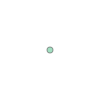

In [41]:
get_canonical_coords_google('807 BEACON CIR OAKDALE PA 15071')

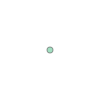

In [53]:
addr_to_coords('807 BEACON CIR OAKDALE PA 15071')

In [51]:
canonical_addr_map['807 BEACON CIR OAKDALE PA 15071']

{'canonical_in_census_db': False,
 'canonical_in_google_db': True,
 'census_block': u'420034580002086',
 'census_value': None,
 'google_value': u'{"status": "OK", "results": [{"geometry": {"location_type": "ROOFTOP", "bounds": {"northeast": {"lat": 40.3930951, "lng": -80.1582646}, "southwest": {"lat": 40.3929375, "lng": -80.1584087}}, "viewport": {"northeast": {"lat": 40.39436528029149, "lng": -80.1569876697085}, "southwest": {"lat": 40.3916673197085, "lng": -80.1596856302915}}, "location": {"lat": 40.393051, "lng": -80.15833959999999}}, "address_components": [{"long_name": "807", "types": ["street_number"], "short_name": "807"}, {"long_name": "Beacon Circle", "types": ["route"], "short_name": "Beacon Cir"}, {"long_name": "Oakdale", "types": ["locality", "political"], "short_name": "Oakdale"}, {"long_name": "Collier Township", "types": ["administrative_area_level_3", "political"], "short_name": "Collier Township"}, {"long_name": "Allegheny County", "types": ["administrative_area_level_

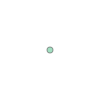

In [28]:
addr_to_coords('807 BEACON CIR OAKDALE PA 15071')

In [29]:
voter_map['109188400-02']

{'DOB': '4/15/1986',
 'addr_arr': [{'address': '807 BEACON CIR OAKDALE PA 15071',
   'census_block': u'420034580002086',
   'date': datetime.datetime(2018, 8, 24, 0, 0)}],
 'addresses': {'2018-08': '807 BEACON CIR OAKDALE PA 15071'},
 'reg_date': datetime.datetime(2018, 8, 24, 0, 0),
 'reg_info': {'2018-08': {'party': 'NF', 'status': 'A'}}}

In [52]:
# Reset
canonical_addr_map['807 BEACON CIR OAKDALE PA 15071']={'canonical_in_census_db': False,
 'canonical_in_google_db': False,
 'census_block': u'420034580002086',
 'census_value': None,
 'google_value': None}


# Process addrs_to_blocks_todo_set

In [217]:
# Construct GeoDataFrame from addrs_to_blocks and coords_to_blocks
todo_addrs_df = pd.DataFrame(addrs_to_blocks, columns=['address_raw'])
todo_geom_df = pd.Series(coords_to_blocks)

In [218]:
todo_gj = gpd.GeoDataFrame(todo_addrs_df, geometry=todo_geom_df,crs={'init': 'epsg:4326'})

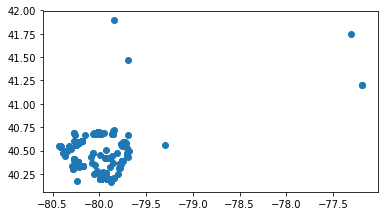

In [223]:
todo_gj.plot()

In [220]:
# Do spatial join to get census block for each address 
# Example from:
#    http://localhost:8820/notebooks/projects/demographics/Census-Planning-DB-2018.ipynb
# mob_blkgroups_gj = gpd.sjoin(blkgrps_cent_gj, mob_gj, how="inner", op='within')
todo_cb_gj = gpd.sjoin(todo_gj, ac_cb_gj, how="inner", op='within')

In [221]:
todo_cb_gj=todo_cb_gj.reset_index()

In [225]:
todo_cb_gj

,index,address_raw,geometry,index_right,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
0,186,205 BROOK ST MC DONALD PA 15057,POINT (-80.23542999999999 40.37612),8048,42,003,564000,2047,420035640002047,Block 2047,G5040,U,69697,U,S,86275.0,0.0,+40.3779068,-080.2355015


In [226]:
# Process all the newly processed census blocks into canonical_addr_map
process_addrs_to_cb_into_cam(todo_cb_gj)

Processing took 0:00:00.001322 for 1 addresses


In [229]:
list(todo_cb_gj.address_raw)

['205 BROOK ST MC DONALD PA 15057']

In [230]:
# Make a copy of addrs_to_blocks_todo_set to keep track of what addresses are left
# after we process the ones that came back with valid census blocks
failed_census_block_addrs = addrs_to_blocks_todo_set

# Remove all the elements that successfully generated census blocks
map(failed_census_block_addrs.remove, list(todo_cb_gj.address_raw))

# Update the vids in addrs_to_blocks_update_map={}
for addr in addrs_to_blocks_update_map:
    census_block = None
    # Check if this is a failed address
    if addr in failed_census_block_addrs:
        # Record 'census_block'=None in canonical_addr_map if not already recorded
        if(not 'census_block' in canonical_addr_map[addr]):
            canonical_addr_map[addr]['census_block']=None
    else:
        # Make sure addr is in canonical_addr_map
        if(not addr in canonical_addr_map or not 'census_block' in canonical_addr_map[addr]):
            print "ERROR: Trying to find census block for %s, but missing from canonical_addr_map" % (addr)
            continue
        # It is in canonical_addr_map, record the census block
        census_block = canonical_addr_map[addr]['census_block']
        
    # census_block should either be None or set to a valid value, record it in the relevant voter IDs.
    for vid in addrs_to_blocks_update_map[addr]:
        # Make sure vid is in voter_map
        if(not vid in voter_map):
            print "ERROR: Trying to update %s with census block %s, but missing from voter_map " % (vid, census_block)
            continue
        vrec = voter_map[vid]
        if(not 'addr_arr' in vrec):
            print "ERROR: Trying to update %s with census block %s, but 'addr_arr' missing from voter_map " % (vid, census_block)
            continue
        # Find the entry in addr_arr matching this address
        for i in range(0,len(voter_map[vid]['addr_arr'])):
            if(addr == voter_map[vid]['addr_arr'][i]['address']):
                # Matches! Update census block
                voter_map[vid]['addr_arr'][i]['census_block'] = census_block

ERROR: Trying to find census block for 1741 BRODHEAD RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 6203 AUBURN ST PITTSBURGH PA 15206, but missing from canonical_addr_map
ERROR: Trying to find census block for 1303 P PENNSYLVANIA AVE NATRONA HEIGHTS PA 15065, but missing from canonical_addr_map
ERROR: Trying to find census block for 127 DELAWARE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 4609 BRIGHTVIEW AVE W PITTSBURGH PA 15227, but missing from canonical_addr_map
ERROR: Trying to find census block for 119 ARROWHEAD RD PITTSBURGH PA 15237, but missing from canonical_addr_map
ERROR: Trying to find census block for 5200 BRIGHTWOOD RD BETHEL PARK PA 15102, but missing from canonical_addr_map
ERROR: Trying to find census block for 100 HUNTER GARDEN CT VERONA PA 15147, but missing from canonical_addr_map
ERROR: Trying to find census block for 415 LUNAR LN APT MOON TWP PA 15108, but miss

ERROR: Trying to find census block for 7229 BEACON HILL DR PITTSBURGH PA 15221, but missing from canonical_addr_map
ERROR: Trying to find census block for 500 LANG AVE S PITTSBURGH PA 15208, but missing from canonical_addr_map
ERROR: Trying to find census block for 102 GENESSEE ST W PITTSBURGH PA 15223, but missing from canonical_addr_map
ERROR: Trying to find census block for 134 SHEPARD RD GIBSONIA PA 15044, but missing from canonical_addr_map
ERROR: Trying to find census block for 2818 VENTANA DR CORAOPOLIS PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 222 RIVER CREST DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 22 B LONGFELLOW DR MUNHALL PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 97 MAPLE AVE PITTSBURGH PA 15202, but missing from canonical_addr_map
ERROR: Trying to find census block for 1339 HIGH RD JEFFERSON HILLS PA 15025, but missing from canonical

ERROR: Trying to find census block for 3999 OLD WM PENN HWY PITTSBURGH PA 15235, but missing from canonical_addr_map
ERROR: Trying to find census block for 1402 TEAL TRCE PITTSBURGH PA 15237, but missing from canonical_addr_map
ERROR: Trying to find census block for 1 B BLAINE ST PITTSBURGH PA 15226, but missing from canonical_addr_map
ERROR: Trying to find census block for 1965 STATE RTE 908 NATRONA HEIGHTS PA 15065, but missing from canonical_addr_map
ERROR: Trying to find census block for 17 A WHARTON CT PITTSBURGH PA 15203, but missing from canonical_addr_map
ERROR: Trying to find census block for 1374 A WILDWOOD RD GIBSONIA PA 15044, but missing from canonical_addr_map
ERROR: Trying to find census block for 1812 CHESTNUT RIDGE DR PITTSBURGH PA 15205, but missing from canonical_addr_map
ERROR: Trying to find census block for 8 NAYSMITH RD BOX NORTH VERSAILLES PA 15137, but missing from canonical_addr_map
ERROR: Trying to find census block for 240 10TH AVE W TARENTUM PA 15084, but m

ERROR: Trying to find census block for 1640 JEFFERSON RIDGE DR JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 537 RAILROAD AVE E VERONA PA 15147, but missing from canonical_addr_map
ERROR: Trying to find census block for 4821 EMBLEM DR S PITTSBURGH PA 15236, but missing from canonical_addr_map
ERROR: Trying to find census block for 41 BELLECREST AVE W PITTSBURGH PA 15227, but missing from canonical_addr_map
ERROR: Trying to find census block for 115 8TH AVE W TARENTUM PA 15084, but missing from canonical_addr_map
ERROR: Trying to find census block for 320 N GATEWAY TRS FT DUKE BLVD PITTSBURGH PA 15222, but missing from canonical_addr_map
ERROR: Trying to find census block for 555 NORTH BRANCH RD OAKDALE PA 15071, but missing from canonical_addr_map
ERROR: Trying to find census block for 300 COLONY WEST DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 2355 MASONIC DR SEWICKLEY PA 15143,

ERROR: Trying to find census block for 812 PERRYTOWN PL APT PITTSBURGH PA 15237, but missing from canonical_addr_map
ERROR: Trying to find census block for 635 1/2 NORTH AVE PITTSBURGH PA 15209, but missing from canonical_addr_map
ERROR: Trying to find census block for 101 1ST ST W WEST MIFFLIN PA 15122, but missing from canonical_addr_map
ERROR: Trying to find census block for 1035 MORELLE AVE EAST MC KEESPORT PA 15035, but missing from canonical_addr_map
ERROR: Trying to find census block for 1111 ORIOLE DR E PITTSBURGH PA 15220, but missing from canonical_addr_map
ERROR: Trying to find census block for 315 13TH AVE W HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 114 NIKE RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 4043 STATE RTE 8 ALLISON PARK PA 15101, but missing from canonical_addr_map
ERROR: Trying to find census block for 1100 LOUISE ST MUNHALL PA 15120, but missing from canoni

ERROR: Trying to find census block for 15 PENNRIDGE CT PITTSBURGH PA 15235, but missing from canonical_addr_map
ERROR: Trying to find census block for 300 7TH AVE E TARENTUM PA 15084, but missing from canonical_addr_map
ERROR: Trying to find census block for 1734 STEVENSAN DR SEWICKLEY PA 15143, but missing from canonical_addr_map
ERROR: Trying to find census block for 208 CENTERDALE RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 1903 VENTANA DR CORAOPOLIS PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 22 LUNAR LN APT MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 221 SPRINGER DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 9003 CLUB HOUSE RD PRESTO PA 15142, but missing from canonical_addr_map
ERROR: Trying to find census block for 1012 1ST ST JEFFERSON HILLS PA 15025, but missing from canonical_addr_map

ERROR: Trying to find census block for 1897 BEECHFORD AVE MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 111 DALE ST JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 204 MASON RD TARENTUM PA 15084, but missing from canonical_addr_map
ERROR: Trying to find census block for 225 MAIN ST E CARNEGIE PA 15106, but missing from canonical_addr_map
ERROR: Trying to find census block for 148 ARBOR TRAIL DR MCKEES ROCKS PA 15136, but missing from canonical_addr_map
ERROR: Trying to find census block for 113 CLARIDGE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 205 HIGHLAND AVE S CHESWICK PA 15024, but missing from canonical_addr_map
ERROR: Trying to find census block for 118 PHILOMENA DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 602 LANG AVE S PITTSBURGH PA 15208, but missing from canonical_addr_m

ERROR: Trying to find census block for 96 NOBLESTOWN RD RD1 BOX OAKDALE PA 15071, but missing from canonical_addr_map
ERROR: Trying to find census block for 27810 EVERGREEN RUN IMPERIAL PA 15126, but missing from canonical_addr_map
ERROR: Trying to find census block for 655 8TH AVE W HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 204 HIGHLAND AVE S PITTSBURGH PA 15206, but missing from canonical_addr_map
ERROR: Trying to find census block for 1205 STATE RTE 885 JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 3021 PHILLIP DR JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 953 MONTCLAIR DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 114 ROLLING WOODS DR NORTH VERSAILLES PA 15137, but missing from canonical_addr_map
ERROR: Trying to find census block for 1136 MAPLE ST EXT MOON TWP PA 1510

ERROR: Trying to find census block for 943 WARRINGTON AVE E PITTSBURGH PA 15210, but missing from canonical_addr_map
ERROR: Trying to find census block for 39 PARKVIEW DR JT TR CT CLINTON PA 15026, but missing from canonical_addr_map
ERROR: Trying to find census block for 119 STATE RTE 908 NATRONA HEIGHTS PA 15065, but missing from canonical_addr_map
ERROR: Trying to find census block for 2011 WHITE OAK CT MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 2 K LONGFELLOW DR MUNHALL PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 1508 ALABAMA AVE PITTSBURGH PA 15216, but missing from canonical_addr_map
ERROR: Trying to find census block for 108 BROADWAY AVE N NORTH VERSAILLES PA 15137, but missing from canonical_addr_map
ERROR: Trying to find census block for 95 PROSPECT ST EAST PITTSBURGH PA 15112, but missing from canonical_addr_map
ERROR: Trying to find census block for 334 12TH AVE E HOMESTEAD PA 15120, 

ERROR: Trying to find census block for 322 11TH AVE E HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 47 PARKVIEW DR JT TR CT CLINTON PA 15026, but missing from canonical_addr_map
ERROR: Trying to find census block for 226 KELLY RUN MONONGAHELA PA 15063, but missing from canonical_addr_map
ERROR: Trying to find census block for 409 CRESCENT BLVD PO BOX CRESCENT PA 15046, but missing from canonical_addr_map
ERROR: Trying to find census block for 154 NORTH-SOUTH DR PITTSBURGH PA 15237, but missing from canonical_addr_map
ERROR: Trying to find census block for 5051 EMPIRE DR BRIDGEVILLE PA 15017, but missing from canonical_addr_map
ERROR: Trying to find census block for 4 BLANFORD CT PITTSBURGH PA 15206, but missing from canonical_addr_map
ERROR: Trying to find census block for 3622 1 RIDGEWOOD DR PITTSBURGH PA 15235, but missing from canonical_addr_map
ERROR: Trying to find census block for 210 MCDONALD ST MC DONALD PA 15057, but missing fro

ERROR: Trying to find census block for 133 SCOTTSDALE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 1 A WHARTON CT PITTSBURGH PA 15203, but missing from canonical_addr_map
ERROR: Trying to find census block for 605 PERRYTOWN PL APT PITTSBURGH PA 15237, but missing from canonical_addr_map
ERROR: Trying to find census block for 99 FREMONT AVE S PITTSBURGH PA 15202, but missing from canonical_addr_map
ERROR: Trying to find census block for 140 ALTERMOOR DR NATRONA HEIGHTS PA 15065, but missing from canonical_addr_map
ERROR: Trying to find census block for 114 3RD ST S DUQUESNE PA 15110, but missing from canonical_addr_map
ERROR: Trying to find census block for 877 BEACON LANE PITTSBURGH PA 15237, but missing from canonical_addr_map
ERROR: Trying to find census block for 56 1/2 GARFIELD ST NATRONA HEIGHTS PA 15065, but missing from canonical_addr_map
ERROR: Trying to find census block for 115 SCHUCHERT ST PITTSBURGH PA 15210, but missing f

ERROR: Trying to find census block for 97 STARR AVE N PITTSBURGH PA 15202, but missing from canonical_addr_map
ERROR: Trying to find census block for 4532 WALNUT RIDGE CIR MCDONALD PA 15057, but missing from canonical_addr_map
ERROR: Trying to find census block for 5441 BROAD ST N SOUTH PARK PA 15129, but missing from canonical_addr_map
ERROR: Trying to find census block for 180 COAL VALLEY RD JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 109 CAMINO CT JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 950 HOOKSTOWN-GRADE RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 6 F SCOTT DR DRAVOSBURG PA 15034, but missing from canonical_addr_map
ERROR: Trying to find census block for 6408 JEFFERSON POINTE CIR JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 520 PERRYTOWN PL APT PITTSBURGH PA

ERROR: Trying to find census block for 1422 CORAOPOLIS HTS RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 435 PARK MANOR PL PITTSBURGH PA 15235, but missing from canonical_addr_map
ERROR: Trying to find census block for 3475 1/2 DENNY ST PITTSBURGH PA 15201, but missing from canonical_addr_map
ERROR: Trying to find census block for 121 HAYESWOLD DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 4113 DUCKHORN DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 305 FAIRACRE CT PRESTO PA 15142, but missing from canonical_addr_map
ERROR: Trying to find census block for 108 BONNIE BRAE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 610 GILL HALL RD JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 824 FAIRWAY DR OAKMONT PA 15139, but missing from canon

ERROR: Trying to find census block for 101 WYNGATE RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 425 WYNDHURST DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 206 PARKRIDGE LN MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 1222 SPRING RUN RD EXT MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 505 FAIRACRE CT PRESTO PA 15142, but missing from canonical_addr_map
ERROR: Trying to find census block for 134 DOVER DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 290 MOON CLINTON RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 305 VILLAGE LN DR WEST MIFFLIN PA 15122, but missing from canonical_addr_map
ERROR: Trying to find census block for 3054 SANLIN DR MOON TWP PA 15108, but missing from canonical_addr_ma

ERROR: Trying to find census block for 395 STATE RTE 908 EXT TARENTUM PA 15084, but missing from canonical_addr_map
ERROR: Trying to find census block for 12 E HATTMAN DR CORAOPOLIS PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 548 A FIRETHORNE DR MONROEVILLE PA 15146, but missing from canonical_addr_map
ERROR: Trying to find census block for 1119 MAPLE ST EXT MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 5034 STAGS LEAP LN MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 513 3RD AVE NORTH VERSAILLES PA 15137, but missing from canonical_addr_map
ERROR: Trying to find census block for 308 SCENIC CT MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 233 EDDIE LEWIS DR PITTSBURGH PA 15090, but missing from canonical_addr_map
ERROR: Trying to find census block for 514 8TH AVE E TARENTUM PA 15084, but missing from cano

ERROR: Trying to find census block for 250 1 BOUQUET ST S PITTSBURGH PA 15213, but missing from canonical_addr_map
ERROR: Trying to find census block for 332 CLAVALE DR NORTH VERSAILLES PA 15137, but missing from canonical_addr_map
ERROR: Trying to find census block for 100 TORY RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 78 VINE ST NATRONA HEIGHTS PA 15065, but missing from canonical_addr_map
ERROR: Trying to find census block for 833 FOREST GREEN DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 121 STATE RTE 908 NATRONA HEIGHTS PA 15065, but missing from canonical_addr_map
ERROR: Trying to find census block for 119 VALENTINE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 471 ELKWOOD DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 701 OLD CLAIRTON RD JEFFERSON HILLS PA 15025, but missing 

ERROR: Trying to find census block for 51 GARDEN CT VERONA PA 15147, but missing from canonical_addr_map
ERROR: Trying to find census block for 124 FRANCIS AVE E PITTSBURGH PA 15227, but missing from canonical_addr_map
ERROR: Trying to find census block for 403 PERRYTOWN PL APT PITTSBURGH PA 15237, but missing from canonical_addr_map
ERROR: Trying to find census block for 156 GILL HALL RD JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 154 MARIGOLD ST W MUNHALL PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 120 WHITE TAIL DR JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 1516 STAUNTON DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 905 TALISMAN LN NATRONA HEIGHTS PA 15065, but missing from canonical_addr_map
ERROR: Trying to find census block for 235 ELMORE ST PITTSBURGH PA 15219, but missing fr

ERROR: Trying to find census block for 27 B MIDWAY DR APT BLDG B WEST MIFFLIN PA 15122, but missing from canonical_addr_map
ERROR: Trying to find census block for 60 GLENN WAY MC KEES ROCKS PA 15136, but missing from canonical_addr_map
ERROR: Trying to find census block for 32 MIDWAY DR APT BLDG F WEST MIFFLIN PA 15122, but missing from canonical_addr_map
ERROR: Trying to find census block for 130 ROGERS CT HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 340 FLAUGHERTY RUN RD RD2 MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 167 MIFFLIN ST W HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 323 8TH AVE W TARENTUM PA 15084, but missing from canonical_addr_map
ERROR: Trying to find census block for 345 INDIAN RIDGE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 2004 REED ST PITTSBURGH PA 15219, but mi

ERROR: Trying to find census block for 303 SERENDIPITY DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 1005 SANDHURST DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 345 NEW WORLD DR JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 311 EVALINE ST S PITTSBURGH PA 15224, but missing from canonical_addr_map
ERROR: Trying to find census block for 412 POLO CLUB DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 6009 CLAIRE VALLEY CT JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 505 BONNIE BRAE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 411 PACIFIC AVE S PITTSBURGH PA 15224, but missing from canonical_addr_map
ERROR: Trying to find census block for 407 GRANDVIEW DR VERONA PA 15147, but missin

ERROR: Trying to find census block for 201 BENDIX DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 4122 VALLEYVUE DR GIBSONIA PA 15044, but missing from canonical_addr_map
ERROR: Trying to find census block for 115 ELM LN MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 34 STEUBEN ST W PITTSBURGH PA 15205, but missing from canonical_addr_map
ERROR: Trying to find census block for 2047 LAUREL RIDGE DR JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 5146 EMPIRE DR BRIDGEVILLE PA 15017, but missing from canonical_addr_map
ERROR: Trying to find census block for 141 ELIZABETH ST E PITTSBURGH PA 15207, but missing from canonical_addr_map
ERROR: Trying to find census block for 217 SERENITY DR PITTSBURGH PA 15239, but missing from canonical_addr_map
ERROR: Trying to find census block for 4092 1 MT ROYAL BLVD ALLISON PARK PA 15101, but missing from ca

ERROR: Trying to find census block for 154 WOODFORD AVE E PITTSBURGH PA 15210, but missing from canonical_addr_map
ERROR: Trying to find census block for 579 MOON CLINTON RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 6415 JEFFERSON POINTE CIR JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 219 15TH AVE E HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 4650 STATE RTE 910 ALLISON PARK PA 15101, but missing from canonical_addr_map
ERROR: Trying to find census block for 121 1ST AVE WEST MIFFLIN PA 15122, but missing from canonical_addr_map
ERROR: Trying to find census block for COTTAGE ST CURTISVILLE PA 15032, but missing from canonical_addr_map
ERROR: Trying to find census block for 608 VILLAGE LN DR WEST MIFFLIN PA 15122, but missing from canonical_addr_map
ERROR: Trying to find census block for 912 JESSICA CIR OAKDALE PA 15071, but missin

ERROR: Trying to find census block for 154 MARIGOLD ST E MUNHALL PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 68 BAYHILL DR BRIDGEVILLE PA 15017, but missing from canonical_addr_map
ERROR: Trying to find census block for 708 CULLODEN CT MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 136 D WATSON DR TURTLE CREEK PA 15145, but missing from canonical_addr_map
ERROR: Trying to find census block for 23 B MIDWAY DR APT BLDG B WEST MIFFLIN PA 15122, but missing from canonical_addr_map
ERROR: Trying to find census block for 104 PENNVIEW ST W PITTSBURGH PA 15223, but missing from canonical_addr_map
ERROR: Trying to find census block for 106 WYNGATE RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 210 TIMBERYOKE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 119 NORTH-SOUTH DR PITTSBURGH PA 15237, but missing from

ERROR: Trying to find census block for 4207 DOG LEG DR PRESTO PA 15142, but missing from canonical_addr_map
ERROR: Trying to find census block for 125 SHEPARD RD GIBSONIA PA 15044, but missing from canonical_addr_map
ERROR: Trying to find census block for 105 BECKS RUN RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 6202 LANDING LN MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 209 SERENITY DR PITTSBURGH PA 15239, but missing from canonical_addr_map
ERROR: Trying to find census block for 411 PAYNE HILL RD JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 250 1 INGLEWOOD DR PITTSBURGH PA 15228, but missing from canonical_addr_map
ERROR: Trying to find census block for 128 MILL ST EXT TARENTUM PA 15084, but missing from canonical_addr_map
ERROR: Trying to find census block for 702 OVERLOOK PL MC KEES ROCKS PA 15136, but missing from canonical_

ERROR: Trying to find census block for 807 STONELEA ST PITTSBURGH PA 15212, but missing from canonical_addr_map
ERROR: Trying to find census block for 44 HARRISON AVE N PITTSBURGH PA 15202, but missing from canonical_addr_map
ERROR: Trying to find census block for 5446 LANTERN HILL DR EXT PITTSBURGH PA 15236, but missing from canonical_addr_map
ERROR: Trying to find census block for 11 ESMOND CT PITTSBURGH PA 15206, but missing from canonical_addr_map
ERROR: Trying to find census block for 112 OLDE MANOR LN MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 300 STATE RTE 909 VERONA PA 15147, but missing from canonical_addr_map
ERROR: Trying to find census block for 253 STATE RTE 908 NATRONA HEIGHTS PA 15065, but missing from canonical_addr_map
ERROR: Trying to find census block for 70 HARRISON ST GLASSPORT PA 15045, but missing from canonical_addr_map
ERROR: Trying to find census block for 463 STARZ RD W CHESWICK PA 15024, but missing from can

ERROR: Trying to find census block for 21 WOODFORD AVE W PITTSBURGH PA 15210, but missing from canonical_addr_map
ERROR: Trying to find census block for 315 PRIMROSE LN NATRONA HEIGHTS PA 15065, but missing from canonical_addr_map
ERROR: Trying to find census block for 2038 CONNECTICUT LN SEWICKLEY PA 15143, but missing from canonical_addr_map
ERROR: Trying to find census block for 2921 GAS ST MC KEESPORT PA 15132, but missing from canonical_addr_map
ERROR: Trying to find census block for 115 MOONCREST DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 58 PROSPECT ST EAST PITTSBURGH PA 15112, but missing from canonical_addr_map
ERROR: Trying to find census block for 243 SCHWAB AVE W MUNHALL PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 204 WINCHESTER DR PITTSBURGH PA 15239, but missing from canonical_addr_map
ERROR: Trying to find census block for 6150 STATION ST PITTSBURGH PA 15206, but missing from c

ERROR: Trying to find census block for 4 E MIDWAY DR APT BLDG E WEST MIFFLIN PA 15122, but missing from canonical_addr_map
ERROR: Trying to find census block for 214 LYTTON RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 322 HOME AVE S PITTSBURGH PA 15202, but missing from canonical_addr_map
ERROR: Trying to find census block for 238 SERENITY DR PITTSBURGH PA 15239, but missing from canonical_addr_map
ERROR: Trying to find census block for 329 HAMILTON AVE HARWICK PA 15049, but missing from canonical_addr_map
ERROR: Trying to find census block for 632 GARFIELD AVE HEIDELBERG PA 15106, but missing from canonical_addr_map
ERROR: Trying to find census block for 322 14TH AVE W HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 214 MILLER AVE W MUNHALL PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 229 LARKSPUR ST W MUNHALL PA 15120, but missing from canonical_a

ERROR: Trying to find census block for 5004 JACKSON DR JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 807 E PGH-MCKEESPORT BLVD NORTH VERSAILLES PA 15137, but missing from canonical_addr_map
ERROR: Trying to find census block for 3827 NORTHERN PIKE MONROEVILLE PA 15146, but missing from canonical_addr_map
ERROR: Trying to find census block for 3046 STATE RTE 885 CLAIRTON RD WEST MIFFLIN PA 15122, but missing from canonical_addr_map
ERROR: Trying to find census block for 18 MCINTYRE AVE W PITTSBURGH PA 15214, but missing from canonical_addr_map
ERROR: Trying to find census block for 2302 MYRTLE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 187 PILLAR DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 302 10TH ST SHARPSBURG PA 15215, but missing from canonical_addr_map
ERROR: Trying to find census block for 220 ATLANTIC AVE S PITTSBURGH PA

ERROR: Trying to find census block for 105 PROSPECT TERR E PITTSBURGH PA 15112, but missing from canonical_addr_map
ERROR: Trying to find census block for 443 N LEWIS RUN WEST MIFFLIN PA 15122, but missing from canonical_addr_map
ERROR: Trying to find census block for 233 LYTTON RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 346 13TH AVE W HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 667 STATE RTE 908 EXT TARENTUM PA 15084, but missing from canonical_addr_map
ERROR: Trying to find census block for 1111 MAPLE ST EXT MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 62 A CRAWFORD VLG MC KEESPORT PA 15132, but missing from canonical_addr_map
ERROR: Trying to find census block for 52 BELLECREST AVE W PITTSBURGH PA 15227, but missing from canonical_addr_map
ERROR: Trying to find census block for 9307 LANDING LN MOON TWP PA 15108, but missing from ca

ERROR: Trying to find census block for 3451 RIDGE RD JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 1361 HILDA ST EAST MC KEESPORT PA 15035, but missing from canonical_addr_map
ERROR: Trying to find census block for 1122 EAGLES NEST LN MONROEVILLE PA 15146, but missing from canonical_addr_map
ERROR: Trying to find census block for 112 SOUTH PATTON DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 504 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137, but missing from canonical_addr_map
ERROR: Trying to find census block for 501 LANG AVE S PITTSBURGH PA 15208, but missing from canonical_addr_map
ERROR: Trying to find census block for 908 TOTTENHAM DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 320 LINDEN AVE S PITTSBURGH PA 15208, but missing from canonical_addr_map
ERROR: Trying to find census block for 10 B BRUNO DR INDIANOLA PA 15051, but mis

ERROR: Trying to find census block for 261 BECKS RUN RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 547 B 7TH AVE W HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 143 LARKSPUR ST W MUNHALL PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 122 8TH AVE W HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 506 BONNIE BRAE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 1651 VILLAGE GREEN DR JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 3008 THOMAS JEFFERSON DR JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 242 MILLVALE AVE S PITTSBURGH PA 15224, but missing from canonical_addr_map
ERROR: Trying to find census block for 104 SPYGLASS DR PITTSBURGH PA 15229, but m

ERROR: Trying to find census block for 112 MAIN ST N SHARPSBURG PA 15215, but missing from canonical_addr_map
ERROR: Trying to find census block for 3020 PHILLIP DR JEFFERSON HILLS PA 15025, but missing from canonical_addr_map
ERROR: Trying to find census block for 222 16TH AVE E HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 410 CANTERBURY CIR CARNEGIE PA 15106, but missing from canonical_addr_map
ERROR: Trying to find census block for 703 NOBLESTOWN RD RD1 BOX OAKDALE PA 15071, but missing from canonical_addr_map
ERROR: Trying to find census block for 2147 MASONIC DR SEWICKLEY PA 15143, but missing from canonical_addr_map
ERROR: Trying to find census block for 305 PRIMROSE LN NATRONA HEIGHTS PA 15065, but missing from canonical_addr_map
ERROR: Trying to find census block for 620 BONNIE BRAE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 28 MEYERS ST W PITTSBURGH PA 15210, but missing fro

ERROR: Trying to find census block for 415 POLO CLUB DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 1063 A BRACKENRIDGE AVE BRACKENRIDGE PA 15014, but missing from canonical_addr_map
ERROR: Trying to find census block for 100 LINWOOD AVE S PITTSBURGH PA 15205, but missing from canonical_addr_map
ERROR: Trying to find census block for 2023 LAFAYETTE ST SWISSVALE PA 15218, but missing from canonical_addr_map
ERROR: Trying to find census block for 214 14TH AVE E HOMESTEAD PA 15120, but missing from canonical_addr_map
ERROR: Trying to find census block for 201 SANTA ANNA DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 54 GARDEN CT VERONA PA 15147, but missing from canonical_addr_map
ERROR: Trying to find census block for 1505 GREYSTONE DR MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 1533 STAUNTON DR MOON TWP PA 15108, but missing from canonical

ERROR: Trying to find census block for 408 KELLYWOOD MNR NEW KENSINGTON PA 15068, but missing from canonical_addr_map
ERROR: Trying to find census block for 1656 CHARLTON HTS RD MOON TWP PA 15108, but missing from canonical_addr_map
ERROR: Trying to find census block for 520 10TH AVE E TARENTUM PA 15084, but missing from canonical_addr_map
ERROR: Trying to find census block for 805 WHITESIDE RD PITTSBURGH PA 15219, but missing from canonical_addr_map
ERROR: Trying to find census block for 165 NORTH-SOUTH DR PITTSBURGH PA 15237, but missing from canonical_addr_map
ERROR: Trying to find census block for 2614 BELMAR PL SWISSVALE PA 15218, but missing from canonical_addr_map
ERROR: Trying to find census block for 7306 RIVER FRONT DR PITTSBURGH PA 15238, but missing from canonical_addr_map


In [233]:
'1741 BRODHEAD RD MOON TWP PA 15108' in addrs_to_blocks_update_map

True

In [231]:
failed_census_block_addrs

{'10 BEECH ST AMBRIDGE PA 15003',
 '10 NOBLESTOWN RD OAKDALE PA 15071',
 '10 RIDGE RD RD1 MARS PA 16046',
 '100 RIDGE RD MONONGAHELA PA 15063',
 '100 RIDGE RD RD1 MARS PA 16046',
 '1005 CONOVER DR NEW KENSINGTON PA 15068',
 '101 HILL ST MC DONALD PA 15057',
 '101 HILL ST MCDONALD PA 15057',
 '101 PLEASANT RISE DR MC DONALD PA 15057',
 '101 PLEASANT RISE DR MCDONALD PA 15057',
 '101 RIDGE RD MONONGAHELA PA 15063',
 '102 MONTROSE AVE FREEPORT PA 16229',
 '1035 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
 '1036 OLD ORCHARD CT GIBSONIA PA 15044',
 '1039 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
 '104 RIDGE RD MONONGAHELA PA 15063',
 '105 GRANT ST MCDONALD PA 15057',
 '106 DAVIS LN SEWICKLEY PA 15143',
 '106 HIMALAYA RD MONROEVILLE PA 15146',
 '1081 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
 '109 RIDGE RD MONONGAHELA PA 15063',
 '110 GRANT ST MCDONALD PA 15057',
 '110 HIMALAYA RD MONROEVILLE PA 15146',
 '1109 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
 '112 HIMALAYA RD MONROEVILLE PA 1

In [235]:
canonical_addr_map['1741 BRODHEAD RD MOON TWP PA 15108']

KeyError: '1741 BRODHEAD RD MOON TWP PA 15108'

In [239]:
# Add failed_census_block_addrs to uncomputable_census_block_addrs_set
uncomputable_census_block_addrs_set = uncomputable_census_block_addrs_set.union(failed_census_block_addrs)
print "Added %d addrs to uncomputable_census_block_addrs_set, size now %d" % (len(failed_census_block_addrs), len(uncomputable_census_block_addrs_set))

Added 268 addrs to uncomputable_census_block_addrs_set, size now 268


In [240]:
# Reset TODO related variables to be empty
addrs_to_blocks_todo_set=set()
addrs_to_blocks=[]
coords_to_blocks=[]
addrs_to_blocks_update_map={}


In [196]:
# From ~/education/earthtime/voting/update_vids_in_addrs_to_blocks_update_map_out.txt
# These appear to be addresses that did not match to any of the census blocks
reprocess_addrs = ['14 BEECH ST AMBRIDGE PA 15003',
'245 ERMA ST RD1 MONONGAHELA PA 15063',
'915 INDIANA AVE GLASSPORT PA 15045',
'234 CENTER AVE CECIL PA 15321',
'896 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'1036 OLD ORCHARD CT GIBSONIA PA 15044',
'1268 US ROUTE 30 CLINTON PA 15026',
'124 FINLEYVILLE R D 4 BOX FINLEYVILLE PA 15332',
'501 EASTVIEW DR IRWIN PA 15642',
'491 EASTVIEW DR IRWIN PA 15642',
'320 MILLERS-HILL RD RD2 BOX NEW KENSINGTON PA 15068',
'78 BEECH ST AMBRIDGE PA 15003',
'131 MAIN ST PO BOX RUSSELLTON PA 15076',
'277 STATE RTE 30 CLINTON PA 15026',
'1171 CAMBIER DR CRESCENT PA 15046',
'187 AIRPORT RD BELLE VERNON PA 15012',
'170 OLD JACKS RUN RD IRWIN PA 15642',
'106 DAVIS LN SEWICKLEY PA 15143',
'LOGANS FERRY RD NEW KENSINGTON PA 15068',
'405 PATRICKS PL MARS PA 16046',
'100 RIDGE RD RD1 MARS PA 16046',
'14 BEAVER ST AMBRIDGE PA 15003',
'2734 MILFORD DR BETHEL PARK PA 15102',
'961 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'205 BROOK ST MC DONALD PA 15057',
'101 PLEASANT RISE DR MCDONALD PA 15057',
'6 BEECH ST AMBRIDGE PA 15003',
'110 HIMALAYA RD MONROEVILLE PA 15146',
'337 COAL ST MCDONALD PA 15057',
'513 TUSCARORA RD MARS PA 16046',
'302 STATE RTE 8 BOX BAKERSTOWN PA 15007',
'162 RICHLAND MOBILE HOME PARK GIBSONIA PA 15044',
'FOX HILL BLACKBURN RD SEWICKLEY PA 15143',
'648 MILLERS RUN RD CECIL PA 15321',
'257 COLLINS AVE P O BOX CLAIRTON PA 15025',
'533 5TH ST TRAFFORD PA 15085',
'139 CHRISTY RD BOX TARENTUM PA 15084',
'STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'1963 LINCOLN HWY NORTH VERSAILLES PA 15137',
'2100 SHORT ST FINLEYVILLE PA 15332',
'147 STATE RTE 30 CLINTON PA 15026',
'206 STATE RTE 51 RD4 BOX ELIZABETH PA 15037',
'500 BEAGLE CLUB RD MCDONALD PA 15057',
'1252 STATE RTE 30 CLINTON PA 15026',
'126 WOODLAWN AVE CECIL PA 15321',
'81 RIDGE RD MONONGAHELA PA 15063',
'224 RIDGE RD RD1 MARS PA 16046',
'22 FORBES RD TRAFFORD PA 15085',
'105 GRANT ST MCDONALD PA 15057',
'51 CHARLES ST CECIL PA 15321',
'4117 WINTERBURN AVE PITTSBURGH PA 15207',
'476 BEAGLE CLUB RD MC DONALD PA 15057',
'3780 FAIRVIEW DR MURRYSVILLE PA 15668',
'128 WOODLAWN AVE CECIL PA 15321',
'4 KRISTOFF LN MCDONALD PA 15057',
'145 RIDGE RD MONONGAHELA PA 15063',
'1385 STATE RTE 30 CLINTON PA 15026',
'979 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'1248 US ROUTE 30 CLINTON PA 15026',
'4305 WINTERBURN AVE PITTSBURGH PA 15207',
'5066 IMPALA DR PITTSBURGH PA 15239',
'172 CANNON HILL RD SAXONBURG PA 16056',
'1285 STATE RTE 30 CLINTON PA 15026',
'404 PATRICKS PL MARS PA 16046',
'119 RIDGE RD MONONGAHELA PA 15063',
'8 BEECH ST AMBRIDGE PA 15003',
'3401 LOGANS FERRY RD MURRYSVILLE PA 15668',
'590 OLD JACKS RUN RD IRWIN PA 15642',
'1971 GREENSBURG RD NEW KENSINGTON PA 15068',
'678 PRINCETON BLVD PITTSBURGH PA 15221',
'1297 STATE RTE 30 CLINTON PA 15026',
'1281 STATE RTE 30 CLINTON PA 15026',
'4 BEECH ST AMBRIDGE PA 15003',
'114 RIDGE RD MONONGAHELA PA 15063',
'1282 STATE RTE 30 CLINTON PA 15026',
'131 RIDGE RD MONONGAHELA PA 15063',
'1368 STATE RTE 30 CLINTON PA 15026',
'2 CENTER AVE RD1 BOX MONONGAHELA PA 15063',
'138 HIGH ST MC DONALD PA 15057',
'1035 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'123 RIDGE RD MONONGAHELA PA 15063',
'218 MONONGAHELA R D MONONGAHELA PA 15063',
'2900 COULTERVILLE RD MCKEESPORT PA 15131',
'476 BEAGLE CLUB RD MCDONALD PA 15057',
'181 ROBINSON RUN RD RD6 MCDONALD PA 15057',
'242 BLYTHE RD BOX MCDONALD PA 15057',
'185 GAYDOS LN SEWICKLEY PA 15143',
'490 OLD JACKS RUN RD IRWIN PA 15642',
'864 HILL ST NEW KENSINGTON PA 15068',
'54 CHARLES ST CECIL PA 15321',
'106 HIMALAYA RD MONROEVILLE PA 15146',
'230 CENTER AVE CECIL PA 15321',
'MANOWN RD PO BOX MONONGAHELA PA 15063',
'2104 SHORT ST FINLEYVILLE PA 15332',
'527 5TH ST TRAFFORD PA 15085',
'1039 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'44 ROBINSON RUN RD MC DONALD PA 15057',
'347 CENTER AVE MCDONALD PA 15057',
'116 RIDGE RD MONONGAHELA PA 15063',
'715 SCHOOL ST MC KEES ROCKS PA 15136',
'188 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'201 WARRENDALE RD MARS PA 16046',
'339 COAL ST MCDONALD PA 15057',
'1005 CONOVER DR NEW KENSINGTON PA 15068',
'225 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'215 KIRKWOOD DR PITTSBURGH PA 15215',
'142 CHRISTY RD TARENTUM PA 15084',
'236 CENTER AVE CECIL PA 15321',
'135 RIDGE RD MONONGAHELA PA 15063',
'164 CANNON HILL RD SAXONBURG PA 16056',
'10 NOBLESTOWN RD OAKDALE PA 15071',
'1360 US ROUTE 30 CLINTON PA 15026',
'337 CENTER AVE MC DONALD PA 15057',
'116 GRANT ST MC DONALD PA 15057',
'134 CHRISTY RD BOX TARENTUM PA 15084',
'113 RIDGE RD MONONGAHELA PA 15063',
'122 WOODLAWN AVE CECIL PA 15321',
'1285 US ROUTE 30 CLINTON PA 15026',
'1927 DIXIE LN MONONGAHELA PA 15063',
'118 RIDGE RD MONONGAHELA PA 15063',
'2 KRISTOFF LN MC DONALD PA 15057',
'491 OLD JACKS RUN RD IRWIN PA 15642',
'110 GRANT ST MCDONALD PA 15057',
'4218 LOGANS FERRY RD MURRYSVILLE PA 15668',
'145 STATE RTE 8 BOX VALENCIA PA 16059',
'343 COAL ST MCDONALD PA 15057',
'65 RIDGE RD MONONGAHELA PA 15063',
'118 WOODLAWN AVE CECIL PA 15321',
'WARRENDALE AMBRIDGE RD BADEN PA 15005',
'102 MONTROSE AVE FREEPORT PA 16229',
'116 HIMALAYA RD MONROEVILLE PA 15146',
'330 DEER CREEK RD GIBSONIA PA 15044',
'814 WETTACH ST PITTSBURGH PA 15212',
'120 WOODLAWN AVE CECIL PA 15321',
'325 COAL ST MCDONALD PA 15057',
'500 BEAGLE CLUB RD MC DONALD PA 15057',
'115 GRANT ST MCDONALD PA 15057',
'178 AIRPORT RD BELLE VERNON PA 15012',
'219 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'1132 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'67 ROBINSON RUN RD MC DONALD PA 15057',
'109 RIDGE RD MONONGAHELA PA 15063',
'144 CENTER AVE CECIL PA 15321',
'238 STATE RTE 51 FINLEYVILLE PA 15332',
'95 GLASGOW RD RD1 BOX VALENCIA PA 16059',
'1787 SILLVIEW DR PITTSBURGH PA 15243',
'1272 US ROUTE 30 CLINTON PA 15026',
'208 TECH RD PITTSBURGH PA 15205',
'327 COAL ST MC DONALD PA 15057',
'226 CENTER AVE CECIL PA 15321',
'1109 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'2821 BEECHWOOD BLVD PITTSBURGH PA 15217',
'WALKER RD RD MCDONALD PA 15057',
'60 CHARLES ST CECIL PA 15321',
'150 WILDFLOWER LN MARS PA 16046',
'36 BLYTHEDALE (BAD ADD) BLYTHDALE PA 15013',
'1370 STEWART RD MC DONALD PA 15057',
'184 ALDER ST RD3 BOX TARENTUM PA 15084',
'1270 STATE RTE 30 CLINTON PA 15026',
'404 MARBLE DR CRESCENT PA 15046',
'450 OLD JACKS RUN RD IRWIN PA 15642',
'71 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'236 STATE RTE 51 FINLEYVILLE PA 15332',
'196 WILMOT ST DUQUESNE PA 15110',
'126 RIDGE RD MONONGAHELA PA 15063',
'1081 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'298 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'16 BEAVER ST AMBRIDGE PA 15003',
'100 RIDGE RD MONONGAHELA PA 15063',
'1929 DIXIE LN MONONGAHELA PA 15063',
'1360 STEWART RD MCDONALD PA 15057',
'2020 SNOWDEN RD FINLEYVILLE PA 15332',
'BLYTHEDALE (BAD ADD) BLYTHDALE PA 15013',
'245 KRAMER RD SOUTH PARK PA 15129',
'335 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'3629 LOGANS FERRY RD MURRYSVILLE PA 15668',
'52 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'245 SPRING ST MCDONALD PA 15057',
'538 BEAGLE CLUB RD MC DONALD PA 15057',
'1469 STATE RTE 30 CLINTON PA 15026',
'BROADHEAD TR CT LOT CORAOPOLIS PA 15108',
'PARK RD CECIL PA 15321',
'400 OLD JACKS RUN RD IRWIN PA 15642',
'1282 US ROUTE 30 CLINTON PA 15026',
'1926 DIXIE LN MONONGAHELA PA 15063',
'1963 BLYTHEDALE RD BUENA VISTA PA 15018',
'27 MAIN ST MCDONALD PA 15057',
'538 BEAGLE CLUB RD MCDONALD PA 15057',
'351 STATE RTE 30 CLINTON PA 15026',
'43 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'403 PATRICKS PL MARS PA 16046',
'104 RIDGE RD MONONGAHELA PA 15063',
'204 CRESCENT GARDEN DR PITTSBURGH PA 15235',
'228 CENTER AVE CECIL PA 15321',
'67 STATE RTE 8 BOX VALENCIA PA 16059',
'2020 HOOKSTOWN GRADE RD CLINTON PA 15026',
'203 WARRENDALE RD MARS PA 16046',
'60 DODDS AVE VALENCIA PA 16059',
'4 KRISTOFF LN MC DONALD PA 15057',
'1557 STATE RTE 30 CLINTON PA 15026',
'421 OLD JACKS RUN RD IRWIN PA 15642',
'139 STATE RTE 906 RD ELIZABETH PA 15037',
'543 5TH ST TRAFFORD PA 15085',
'345 SUNSET DR BADEN PA 15005',
'7536 MELROSE ST PITTSBURGH PA 15218',
'114 HIMALAYA RD MONROEVILLE PA 15146',
'2955 COULTERVILLE RD MCKEESPORT PA 15131',
'24 BEECH ST AMBRIDGE PA 15003',
'1270 US ROUTE 30 CLINTON PA 15026',
'1281 US ROUTE 30 CLINTON PA 15026',
'500 CENTER AVE CECIL PA 15321',
'234 RIDGE RD RD1 MARS PA 16046',
'1360 STATE RTE 30 CLINTON PA 15026',
'1223 COLLINS AVE JEFFERSON HILLS PA 15025',
'204 WARRENDALE RD MARS PA 16046',
'451 OLD JACKS RUN RD IRWIN PA 15642',
'323 COAL ST MCDONALD PA 15057',
'51 DEER CREEK RD GIBSONIA PA 15044',
'551 5TH ST TRAFFORD PA 15085',
'392 MILLERS RUN RD MORGAN PA 15064',
'508 TUSCARORA RD MARS PA 16046',
'130 RIDGE RD MONONGAHELA PA 15063',
'53 RIDGE RD MONONGAHELA PA 15063',
'57 RIDGE RD VALENCIA PA 16059',
'112 HIMALAYA RD MONROEVILLE PA 15146',
'289 CHARLES ST CECIL PA 15321',
'330 CENTER AVE MCDONALD PA 15057',
'101 PLEASANT RISE DR MC DONALD PA 15057',
'1403 STATE RTE 30 CLINTON PA 15026',
'78 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'97 BOCKTOWN RD RD1 BOX CLINTON PA 15026',
'369 OLD JACKS RUN RD IRWIN PA 15642',
'67 ROBINSON RUN RD MCDONALD PA 15057',
'1213 COLLINS AVE JEFFERSON HILLS PA 15025',
'8 CLINTON BOCKTOWN RD CLINTON PA 15026',
'1477 STATE RTE 30 CLINTON PA 15026',
'481 EASTVIEW DR IRWIN PA 15642',
'101 HILL ST MC DONALD PA 15057',
'200 WARRENDALE RD MARS PA 16046',
'1283 STATE RTE 30 CLINTON PA 15026',
'440 OLD JACKS RUN RD IRWIN PA 15642',
'202 WARRENDALE RD MARS PA 16046',
'2 KRISTOFF LN MCDONALD PA 15057',
'101 HILL ST MCDONALD PA 15057',
'212 CRAWFORD CT MARS PA 16046',
'508 SCENIC RIDGE DR FINLEYVILLE PA 15332',
'715 SCHOOL ST MCKEES ROCKS PA 15136',
'330 CENTER AVE MC DONALD PA 15057',
'10 RIDGE RD RD1 MARS PA 16046',
'123 STATE RTE 30 CLINTON PA 15026',
'44 ROBINSON RUN RD MCDONALD PA 15057',
'2 BEECH ST AMBRIDGE PA 15003',
'114 GRANT ST MCDONALD PA 15057',
'337 CENTER AVE MCDONALD PA 15057',
'232 CENTER AVE CECIL PA 15321',
'1136 US ROUTE 30 CLINTON PA 15026',
'402 SOUTHPOINT CT MCDONALD PA 15057',
'7 2ND ST PITTSBURGH PA 15215',
'535 5TH ST TRAFFORD PA 15085',
'1268 STATE RTE 30 CLINTON PA 15026',
'240 BLYTHE RD BOX MCDONALD PA 15057',
'499 CENTER AVE CECIL PA 15321',
'10 BEECH ST AMBRIDGE PA 15003',
'273 BOCKTOWN RD PO BOX CRESCENT PA 15046',
'215 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'201 MURRYSVILLE RD NEW KENSINGTON PA 15068',
'CHRISTY COR NEW KENSINGTON PA 15068',
'101 RIDGE RD MONONGAHELA PA 15063',
'1280 US ROUTE 30 CLINTON PA 15026']


In [200]:
reprocess_vids = set()

In [208]:
for this_addr in reprocess_addrs:
    map(reprocess_vids.add,addrs_to_blocks_update_map[this_addr])

In [210]:
len(reprocess_vids)

474

In [212]:
voter_process_address_history_array(list(reprocess_vids),True)

Processing took 0:00:00.038317 for 474 addresses


# Test voter_process_address_history_array components

In [86]:
voter_map[voter_map.keys()[0]]={'DOB': '1/8/1944',
 'addresses': {'2009-07': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2017-11': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2018-03': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2018-08': '415 CHESTNUT ST SPRINGDALE PA 15144'},
 'reg_date': datetime.datetime(1993, 4, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'D', 'status': 'A'},
  '2017-11': {'party': 'D', 'status': 'A'},
  '2018-03': {'party': 'D', 'status': 'A'},
  '2018-08': {'party': 'D', 'status': 'A'}}}

In [119]:
voter_map[voter_map.keys()[3]]={'DOB': '8/29/1972',
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [120]:
i=3
voter_map[voter_map.keys()[i]]

{'DOB': '8/29/1972',
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [127]:
voter_process_address_history(voter_map.keys()[i], True)

[{'address': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  'census_block': u'420035263012005',
  'date': datetime.datetime(1990, 10, 1, 0, 0)},
 {'address': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  'date': datetime.datetime(2017, 11, 30, 0, 0)},
 {'address': '509 OCTOBER CT PLUM PA 15239',
  'census_block': None,
  'date': datetime.datetime(2018, 8, 14, 0, 0)}]

In [153]:
voter_map[voter_map.keys()[3]]

{'DOB': '8/29/1972',
 'addr_arr': [{'address': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
   'census_block': u'420035263012005',
   'date': datetime.datetime(1990, 10, 1, 0, 0)},
  {'address': '3014 SETTLERS CT MURRYSVILLE PA 15668',
   'census_block': u'420035263011014',
   'date': datetime.datetime(2017, 11, 30, 0, 0)},
  {'address': '509 OCTOBER CT PLUM PA 15239',
   'census_block': None,
   'date': datetime.datetime(2018, 8, 14, 0, 0)}],
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [129]:
addrs_to_blocks_todo_set

{'3014 SETTLERS CT MURRYSVILLE PA 15668'}

In [130]:
addrs_to_blocks

['3014 SETTLERS CT MURRYSVILLE PA 15668']

In [131]:
coords_to_blocks

In [132]:
addrs_to_blocks_update_map

{'3014 SETTLERS CT MURRYSVILLE PA 15668': {'002323758-02'}}

# Generate random points in census blocks

In [295]:
# From http://localhost:8820/notebooks/projects/demographics/Get%20random%20census%20block%20points%20from%20prototiles.ipynb
import numpy as np
numpy_record_type = [('x','<f4'), ('y','<f4'), ('blockIdx', '<i4'), ('subIdx', '<i4')]
all_pts = np.memmap('prototiles/master-sorted-by-block.bin', dtype=numpy_record_type)

def find_point_idx(block_idx):
    min_idx = 0
    max_idx = len(all_pts) - 1
    while min_idx <= max_idx:
        test_idx = int((min_idx + max_idx) / 2)
        if block_idx > all_pts[test_idx][2]:
            min_idx = test_idx + 1
        elif block_idx < all_pts[test_idx][2] or all_pts[test_idx][3] != 0:
            max_idx = test_idx - 1
        else:
            return test_idx
    return [min_idx, max_idx]

        
def block_points(block_idx):
    ret = []
    idx = find_point_idx(block_idx)
    assert all_pts[idx][2] == block_idx and all_pts[idx][3] == 0
    while idx < len(all_pts):
        if all_pts[idx][2] == block_idx:
            ret.append({'x':all_pts[idx][0], 'y':all_pts[idx][1]})
        else:
            break
        idx += 1
    return ret

In [329]:
import json
block_geoids_2010 = json.load(open('block_geoids_2010.json'))

geoid2idx = {}
for i in range(0, len(block_geoids_2010)):
    geoid2idx[block_geoids_2010[i]] = i+1

In [350]:
# For each census block, keep track of what voter each index has been assigned to
# Top level key is census block number, secondary key is 'next' for keeping track of the next index to be assigned,
# 'points' for the value returned by block_points, and voter ID: index for other entries
block_id_use_map={}

In [348]:
# Keep track of which census blocks overflowed the number of points
block_id_overflow_set=set()

In [349]:
def block_get_voter_coords(census_block, vid):
    if(not census_block in block_id_use_map):
        # Need to create an entry, set 'next' to 0, initialize points
        # First convert from GEOID10 to the index into the block_idx
        block_idx = geoid2idx[census_block]
        point_arr = block_points(block_idx)
        block_id_use_map[census_block]={'next':0, 'points':point_arr, 'numpoints':len(point_arr)}
    # We know census_block is in block_id_use_map (which we may have just added)
    # Check if this voter ID is already registered
    if(vid in block_id_use_map[census_block]):
        # Already assigned, just use the same index as before
        point_idx=block_id_use_map[census_block][vid]
    else:
        # Not yet assigned, take the next available 
        # and increment 'next'
        point_idx = block_id_use_map[census_block]['next']
        if(point_idx>block_id_use_map[census_block]['numpoints']-1):
            # Overflow
            if(not census_block in block_id_overflow_set):
                block_id_overflow_set.add(census_block)
                print "WARNING: overflow in census block %s" % (census_block)
            # For now, just start reassigning numbers back at 0
            point_idx=0
            block_id_use_map[census_block]['next']=0
        block_id_use_map[census_block]['next'] = point_idx + 1
        block_id_use_map[census_block][vid] = point_idx
        
    # Retrieve the webmercator point from the points array.
    # Convert it to lat lon and create a Point to return.
    # Note that WebMercatorToLonLat(x,y) returns [lon, lat]
    # the args to create a Point are also (lon, lat)
    point_xy = block_id_use_map[census_block]['points'][point_idx]
    ll_arr = WebMercatorToLonLat(point_xy['x'],point_xy['y'])
    return Point(ll_arr[0], ll_arr[1])

In [351]:
def voter_get_coords_for_addr_history(vid, force_update):
    if(not vid in voter_map):
        print "WARNING: %s not in voter_map" % (vid)
        return
    vrec = voter_map[vid]
    if(not 'addr_arr' in vrec):
        print "WARNING: %s missing addr_arr in voter_map, re-run voter_process_address_history_array" % (vid)
        return

    addr_arr = vrec['addr_arr']
    for j in range(0,len(addr_arr)):
        addr_rec = vrec['addr_arr'][j]
        if(not 'census_block' in addr_rec):
            print "WARNING %s: '%s' lacks 'census_block', skipping" % (vid, this_addr)
            continue
        # census_block might be None, in which case don't get coords
        if(addr_rec['census_block']==None):
            continue
        try:
            coords = block_get_voter_coords(addr_rec['census_block'], vid)
            #print "Assigning %r to %s[%d]='%s'"%(coords, vid,j,addr_rec['census_block'])
            #voter_map[vid]['addr_arr'][j]['latlon'] = coords
            addr_rec['latlon'] = coords
        except Exception as e:
            print "ERROR: Exception getting coords for %s[%d]='%s': %s"%(vid,j,addr_rec['census_block'],e)

def voter_get_coords_for_addr_history_array(vid_arr, force_update):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000

    for i in range(0,len(vid_arr)):
        vid = vid_arr[i]
        voter_get_coords_for_addr_history(vid, force_update)
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d in todo set, %d non-geolocatable, %s time elapsed" %(i-(chunk_size-1), i, vid, 
                                                                                                 len(addrs_to_blocks_todo_set), len(non_geolocatable_addrs_set),
                                                                                                 arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(vid_arr))

In [352]:
voter_get_coords_for_addr_history_array(all_vids, False)

1-10000: processing '001910800-02', 0 in todo set, 10750 non-geolocatable, 0:00:17.486311 time elapsed
10001-20000: processing '001932122-02', 0 in todo set, 10750 non-geolocatable, 0:00:08.723287 time elapsed
20001-30000: processing '001946832-02', 0 in todo set, 10750 non-geolocatable, 0:00:05.383406 time elapsed
30001-40000: processing '001964655-02', 0 in todo set, 10750 non-geolocatable, 0:00:04.029195 time elapsed
40001-50000: processing '001985556-02', 0 in todo set, 10750 non-geolocatable, 0:00:02.678381 time elapsed
50001-60000: processing '002003180-02', 0 in todo set, 10750 non-geolocatable, 0:00:02.218112 time elapsed
60001-70000: processing '002018471-02', 0 in todo set, 10750 non-geolocatable, 0:00:01.918303 time elapsed
70001-80000: processing '002035861-02', 0 in todo set, 10750 non-geolocatable, 0:00:01.242539 time elapsed
80001-90000: processing '002054565-02', 0 in todo set, 10750 non-geolocatable, 0:00:01.030951 time elapsed
90001-100000: processing '002069930-02', 

670001-680000: processing '004531688-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.442921 time elapsed
680001-690000: processing '005234392-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.432280 time elapsed
690001-700000: processing '013368678-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.448467 time elapsed
700001-710000: processing '020027054-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.460395 time elapsed
710001-720000: processing '020056661-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.478387 time elapsed
720001-730000: processing '020124147-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.479441 time elapsed
730001-740000: processing '020181084-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.490781 time elapsed
740001-750000: processing '020225342-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.498871 time elapsed
750001-760000: processing '020286254-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.481019 time elapsed
760001-770000: proc

1150001-1160000: processing '108172795-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.366915 time elapsed
1160001-1170000: processing '108440366-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.378995 time elapsed
1170001-1180000: processing '108848358-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.384001 time elapsed
1180001-1190000: processing '109036501-02', 0 in todo set, 10750 non-geolocatable, 0:00:00.363593 time elapsed
Processing took 0:01:41.246578 for 1196866 addresses


In [353]:
len(block_id_overflow_set)

90

In [368]:
overflow_block_ids=list(block_id_overflow_set)
numpoints = map(lambda x: block_id_use_map[x]['numpoints'], overflow_block_ids)
numvoters = map(lambda x: len(block_id_use_map[x])-3, overflow_block_ids)

In [369]:
overflow_blocks_df=pd.DataFrame(zip(overflow_block_ids,numpoints,numvoters),columns=['GEOID10','numpoints','numvoters'])

In [373]:
overflow_blocks_df=pd.DataFrame(zip(numpoints,numvoters),columns=['numpoints','numvoters'],index=overflow_block_ids)

In [374]:
overflow_blocks_df

,numpoints,numvoters
420031702001043,112,119
420031609002009,76,88
420031702001044,60,87
420034742022025,375,415
420030201005050,75,383
420031414004026,60,123
420034090003049,60,78
420034323002000,157,192
420030103004005,70,81
420030201001006,122,123


In [375]:
overflow_blocks_df.to_csv('voters/overflow_blocks_df.csv')

## Debug census block dots

In [378]:
voter_map[all_vids[1]]

{'DOB': '9/29/1926',
 'addr_arr': [{'address': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
   'census_block': None,
   'date': datetime.datetime(1956, 1, 1, 0, 0)},
  {'address': '1094 FOX CHAPEL RD PITTSBURGH PA 15238',
   'census_block': u'420034220001019',
   'date': datetime.datetime(2018, 8, 14, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f4babaa1e90>}],
 'addresses': {'2017-11': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
  '2018-03': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
  '2018-08': '1094 FOX CHAPEL RD PITTSBURGH PA 15238'},
 'reg_date': datetime.datetime(1956, 1, 1, 0, 0),
 'reg_info': {'2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [326]:
census_block = voter_map[all_vids[1]]['addr_arr'][1]['census_block']
census_block

u'420034220001019'

In [330]:
str(block_get_voter_coords(census_block, all_vids[1]))

'POINT (-79.86298799514771 40.53353520356066)'

In [345]:
len(block_id_use_map['420030201001005']['points'])

60

In [347]:
block_id_use_map['420030201001005']['next']

184

In [327]:
block_idx = geoid2idx[census_block]
block_idx

8118177

In [328]:
block_points(block_idx)

[{'x': 71.20854, 'y': 96.41904},
 {'x': 71.20453, 'y': 96.40817},
 {'x': 71.20712, 'y': 96.419304},
 {'x': 71.2026, 'y': 96.41814},
 {'x': 71.20184, 'y': 96.419044},
 {'x': 71.20396, 'y': 96.41828},
 {'x': 71.206245, 'y': 96.41695},
 {'x': 71.20452, 'y': 96.411255},
 {'x': 71.201324, 'y': 96.41373},
 {'x': 71.20135, 'y': 96.40852},
 {'x': 71.199036, 'y': 96.41135},
 {'x': 71.20381, 'y': 96.41501},
 {'x': 71.20234, 'y': 96.41416},
 {'x': 71.20324, 'y': 96.41181},
 {'x': 71.20315, 'y': 96.41303},
 {'x': 71.19872, 'y': 96.40685},
 {'x': 71.20073, 'y': 96.41854},
 {'x': 71.20343, 'y': 96.42033},
 {'x': 71.199585, 'y': 96.41131},
 {'x': 71.20136, 'y': 96.42029},
 {'x': 71.20051, 'y': 96.41032},
 {'x': 71.203545, 'y': 96.41248},
 {'x': 71.19999, 'y': 96.4058},
 {'x': 71.20104, 'y': 96.41262},
 {'x': 71.202354, 'y': 96.41239},
 {'x': 71.19995, 'y': 96.40815},
 {'x': 71.20189, 'y': 96.4143},
 {'x': 71.207985, 'y': 96.41776},
 {'x': 71.20509, 'y': 96.420685},
 {'x': 71.20541, 'y': 96.41877},
 {

# Write out dots files

In [376]:
def color_from_floats(r,g,b):
    return r + g * 256.0 + b * 256.0 * 256.0

def pack_color(color):
    return color['r'] + color['g'] * 256.0 + color['b'] * 256.0 * 256.0;

def parse_color(color):
    color = color.strip()
    c = color
    try:
        if c[0] == '#':
            c = c[1:]
        if len(c) == 3:
            return pack_color({'r': 17 * int(c[0:1], 16),
                               'g': 17 * int(c[1:2], 16),
                               'b': 17 * int(c[2:3], 16)})
        if len(c) == 6:
            return pack_color({'r': int(c[0:2], 16),
                               'g': int(c[2:4], 16),
                               'b': int(c[4:6], 16)})
    except:
        pass
    raise InvalidUsage('Cannot parse color <code><b>%s</b></code> from spreadsheet.<br><br>Color must be in standard web form, <code><b>#RRGGBB</b></code>, where RR, GG, and BB are each two-digit hexadecimal numbers between 00 and FF.<br><br>See <a href="https://www.w3schools.com/colors/colors_picker.asp">HTML Color Picker</a>' % color)

def parse_colors(colors):
    packed = [parse_color(color) for color in colors]
    return numpy.array(packed, dtype = numpy.float32)

In [377]:
out_suffix="17_18_18_18"

In [389]:
max_datetime = dateparser.parse('12/31/3000')

In [445]:

start=arrow.now()

dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
#other_color = '#decc64'
other_color = '#505050'
unknown_color = '#303030'

def vid_to_color(vid, month_str):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    if(month_str in vrec['reg_info']):
        rrec = vrec['reg_info'][month_str]
        if(rrec['party']=='D' and rrec['status']=='A'):
            return dem_a_color
        elif(rrec['party']=='D' and rrec['status']=='I'):
            return dem_i_color
        elif(rrec['party']=='R' and rrec['status']=='A'):
            return rep_a_color
        elif(rrec['party']=='R' and rrec['status']=='I'):
            return rep_i_color
        else:
            return other_color
    return unknown_color

def output_voter_reg_dots_d(vid_arr, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=1000
    dot_cnt=0
    
    for v_i in range(0,len(vid_arr)):
        try:
            vid = vid_arr[v_i]
            if(not vid in voter_map):
                continue
            vrec = voter_map[vid]

            if(not 'addr_arr' in vrec):
                continue

            # Get the month_str values in sorted order for this voter
            month_strs = sorted(vrec['reg_info'].keys())

            # Keep track of the date of the last datapoint. 
            # Initialize last_date to be the registration date for this voter

            last_date = vrec['reg_date']
            last_color=0


            # Keep track of the index of the next month_str
            next_month_str_i=0

            # Iterate over the addresses in addr_arr
            for a_i in range(0,len(vrec['addr_arr'])):
                addr_rec = vrec['addr_arr'][a_i]
                # If addr_rec is not plottable, skip it
                if(not 'latlon' in addr_rec):
                    continue

                # We have lat/lon for this address, continue
                centroid = addr_rec['latlon']
                if(not centroid):
                    continue

                # Get the start time for this address.
                addr_start_date = vrec['addr_arr'][a_i]['date']

                # Find the end time for this address.
                # If this is the last address set end_date to max
                addr_end_date=max_datetime
                if(a_i<len(vrec['addr_arr'])-1):
                    # There's another address after this one, set end_date
                    # to the start of the next address
                    addr_end_date = vrec['addr_arr'][a_i+1]['date']

                # Loop over the month strings until we find one that's 
                # >= addr_start_date.  Typically the next one would be, but 
                # it may not be if the previous address was bad
                while(next_month_str_i<(len(month_strs)-1) and monthstr_to_date_map[month_strs[next_month_str_i]]<addr_start_date):
                    # Step forward to the next month
                    next_month_str_i=next_month_str_i+1

                if((v_i%chunk_size)==0):
                    print "%s[%d]: %s - %s [%d of %d]" % (vid, a_i, addr_start_date, addr_end_date, next_month_str_i, len(month_strs))

                # Start with the color of next_month_str_i
                # and last_date = addr_start_date
                last_date = addr_start_date
                while(next_month_str_i < len(month_strs) and monthstr_to_date_map[month_strs[next_month_str_i]]<=addr_end_date):
                    month_str = month_strs[next_month_str_i]
                    did_output_dot=False

                    # Get color for this registration event
                    color = vid_to_color(vid, month_str)

                   # Get range of dates for this color
                    startdate_epoch = GetEpoch(last_date)
                    # If this is the last month, set enddate_epoch to addr_end_date.  Otherwise set it to month_str.
                    end_date = dateparser.parse(month_str)
                    if(next_month_str_i==len(month_strs)-1):
                        end_date = addr_end_date
                    enddate_epoch = GetEpoch(end_date)
                    if(color != None):
                        points += PointToPixelXY(centroid)     
                        points.append(parse_color(color))
                        # Put epoch time for SALEDATE as start valid time, and next_date as end valid time
                        points.append(float(startdate_epoch))
                        points.append(float(enddate_epoch))
                        if((v_i%chunk_size)==0):
                            print "  %s[%d][%s]: %s - %s = %s (len %d)" % (vid, a_i, month_str,last_date, end_date, color, len(points))
                    else:
                        print "Color of %s is None"

                    # Set last_date and last_color for next loop
                    last_date = end_date
                    last_color= color
                    did_output_dot=True
                    dot_cnt=dot_cnt+1
                    # Special case when monthstr_to_date_map[month_strs[next_month_str_i]]==addr_end_date
                    # to break out of the loop without incrementing next_month_str_i.  Otherwise we 
                    # may have a gap at the end
                    if(monthstr_to_date_map[month_strs[next_month_str_i]]>=addr_end_date):
                        break
                    else:
                        next_month_str_i = next_month_str_i+1
                    # End of inner month loop
                # End of middle address_loop
            # End of try block at level of vid
        except:
            print "Unexpected error processing [%d] %s:" % (v_i, vid), sys.exc_info()[0]
            raise

        # Handle periodic debug message
        if((v_i%chunk_size)==0 and v_i>0):
            print "%d-%d: processing %r, %s time elapsed" %(v_i-(chunk_size-1), v_i, vid, arrow.now()-chunk_start_time)
            chunk_start_time=arrow.now()
                
    array.array('f', points).tofile(open(('voting/voter_reg_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), dot_cnt)
    

In [447]:
# Output all the voter dots for Allegheny County
# 17_18_18_18_c is all census_block points with independents in yellow
# 17_18_18_18_d is all census_block points with independents in dark grey
output_voter_reg_dots_d(all_vids, "17_18_18_18_d")

001002451-02[0]: 1951-01-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  001002451-02[0][2009-07]: 1951-01-01 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 5)
001324872-02[0]: 2000-02-29 00:00:00 - 3000-12-31 00:00:00 [0 of 2]
  001324872-02[0][2018-03]: 2000-02-29 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 14080)
  001324872-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 14085)
1-1000: processing '001324872-02', 0:00:16.742414 time elapsed
001338303-02[0]: 2002-09-10 00:00:00 - 2018-08-14 00:00:00 [0 of 4]
  001338303-02[0][2009-07]: 2002-09-10 00:00:00 - 2009-07-26 00:00:00 = #505050 (len 27975)
  001338303-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 27980)
  001338303-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 27985)
  001338303-02[0][2018-08]: 2018-03-26 00:00:00 - 2018-08-14 00:00:00 = #505050 (len 27990)
001338303-02[1]: 2018-08-14 00:00:00 - 3000-12-31 00:00:00 [3 of 4]
  001338303-02[1][2018-08

001930005-02[0]: 1962-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  001930005-02[0][2009-07]: 1962-09-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 262970)
  001930005-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #821616 (len 262975)
  001930005-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #821616 (len 262980)
  001930005-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #821616 (len 262985)
18001-19000: processing '001930005-02', 0:00:16.221641 time elapsed
001932122-02[0]: 1968-08-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  001932122-02[0][2009-07]: 1968-08-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 276455)
19001-20000: processing '001932122-02', 0:00:16.480676 time elapsed
001933577-02[0]: 1971-07-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  001933577-02[0][2009-07]: 1971-07-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 293560)
  001933577-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 293565)
  0019335

001960599-02[0]: 1987-02-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  001960599-02[0][2009-07]: 1987-02-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 597800)
37001-38000: processing '001960599-02', 0:00:22.028772 time elapsed
001962494-02[0]: 1988-02-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  001962494-02[0][2009-07]: 1988-02-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 615595)
  001962494-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 615600)
  001962494-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 615605)
  001962494-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 615610)
38001-39000: processing '001962494-02', 0:00:21.462994 time elapsed
001964655-02[0]: 1988-07-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  001964655-02[0][2009-07]: 1988-07-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 634105)
  001964655-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 634110)
  0019646

001998126-02[0]: 1997-01-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  001998126-02[0][2009-07]: 1997-01-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 938165)
  001998126-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 938170)
  001998126-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 938175)
  001998126-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 938180)
56001-57000: processing '001998126-02', 0:00:22.059332 time elapsed
001999825-02[0]: 1997-06-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  001999825-02[0][2009-07]: 1997-06-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 955975)
  001999825-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 955980)
001999825-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  001999825-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 955985)
  001999825-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000

002023549-02[0]: 2003-07-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002023549-02[0][2009-07]: 2003-07-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 1223850)
73001-74000: processing '002023549-02', 0:00:20.093816 time elapsed
002025233-02[0]: 1960-02-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002025233-02[0][2009-07]: 1960-02-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 1238550)
74001-75000: processing '002025233-02', 0:00:24.541444 time elapsed
002027395-02[0]: 1967-03-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002027395-02[0][2009-07]: 1967-03-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 1251765)
  002027395-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 1251770)
  002027395-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 1251775)
  002027395-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 1251780)
75001-76000: processing '002027395-02', 0:00:22.262920 time elapsed
002029484-02[0]: 1969-08-01 

002061874-02[0]: 1980-06-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002061874-02[0][2009-07]: 1980-06-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 1542360)
  002061874-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 1542365)
  002061874-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 1542370)
  002061874-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 1542375)
94001-95000: processing '002061874-02', 0:00:23.746838 time elapsed
002063441-02[0]: 1980-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002063441-02[0][2009-07]: 1980-10-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 1560305)
  002063441-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 1560310)
  002063441-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 1560315)
  002063441-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 1560320)
95001-96000: processing '002063441-02', 0:00

002092071-02[0]: 1991-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002092071-02[0][2009-07]: 1991-10-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 1829945)
  002092071-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 1829950)
  002092071-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 1829955)
  002092071-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 1829960)
110001-111000: processing '002092071-02', 0:00:24.326740 time elapsed
002094178-02[0]: 1992-03-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002094178-02[0][2009-07]: 1992-03-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 1847935)
  002094178-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 1847940)
  002094178-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 1847945)
  002094178-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 1847950)
111001-112000: processing '002094178-02', 

002131197-02[0]: 2000-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002131197-02[0][2009-07]: 2000-10-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 2220105)
132001-133000: processing '002131197-02', 0:00:22.713924 time elapsed
002132634-02[0]: 2001-01-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002132634-02[0][2009-07]: 2001-01-01 00:00:00 - 3000-12-31 00:00:00 = #821616 (len 2236175)
133001-134000: processing '002132634-02', 0:00:22.272165 time elapsed
002133913-02[0]: 2001-05-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002133913-02[0][2009-07]: 2001-05-01 00:00:00 - 3000-12-31 00:00:00 = #821616 (len 2252310)
134001-135000: processing '002133913-02', 0:00:21.893291 time elapsed
002135226-02[0]: 2001-10-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002135226-02[0][2009-07]: 2001-10-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 2268090)
  002135226-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 2268095)
002135226-02[1]: 2017-11-30 00:00:00 - 3000-12-3

002168445-02[0]: 1971-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002168445-02[0][2009-07]: 1971-10-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 2529560)
  002168445-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 2529565)
  002168445-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 2529570)
  002168445-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 2529575)
153001-154000: processing '002168445-02', 0:00:25.366906 time elapsed
002169906-02[0]: 1972-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002169906-02[0][2009-07]: 1972-09-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 2546950)
  002169906-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 2546955)
  002169906-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 2546960)
  002169906-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 2546965)
154001-155000: processing '002169906-02', 

002195938-02[0]: 1987-12-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002195938-02[0][2009-07]: 1987-12-01 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 2835265)
170001-171000: processing '002195938-02', 0:00:25.313531 time elapsed
002197982-02[0]: 1988-06-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002197982-02[0][2009-07]: 1988-06-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 2853625)
  002197982-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 2853630)
002197982-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  002197982-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 2853635)
  002197982-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 2853640)
  002197982-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 2853645)
171001-172000: processing '002197982-02', 0:00:25.233124 time elapsed
002200383-02[0]: 1988-10-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002200383-02[0][2009-0

002226325-02[0]: 1996-02-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002226325-02[0][2009-07]: 1996-02-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 3105365)
  002226325-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 3105370)
  002226325-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 3105375)
  002226325-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 3105380)
185001-186000: processing '002226325-02', 0:00:23.887781 time elapsed
002228121-02[0]: 1996-07-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002228121-02[0][2009-07]: 1996-07-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 3123150)
  002228121-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 3123155)
  002228121-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 3123160)
  002228121-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 3123165)
186001-187000: processing '002228121-02', 

002254859-02[0]: 2002-09-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002254859-02[0][2009-07]: 2002-09-01 00:00:00 - 2009-07-26 00:00:00 = #505050 (len 3411445)
  002254859-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 3411450)
002254859-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  002254859-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 3411455)
  002254859-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 3411460)
  002254859-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 3411465)
203001-204000: processing '002254859-02', 0:00:22.433387 time elapsed
002256120-02[0]: 2003-01-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002256120-02[0][2009-07]: 2003-01-01 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 3427455)
204001-205000: processing '002256120-02', 0:00:22.128632 time elapsed
002257353-02[0]: 2003-06-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002257353-02[0][2009-0

002289490-02[0]: 1976-02-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002289490-02[0][2009-07]: 1976-02-01 00:00:00 - 2009-07-26 00:00:00 = #505050 (len 3692275)
  002289490-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 3692280)
002289490-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  002289490-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 3692285)
  002289490-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 3692290)
  002289490-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 3692295)
222001-223000: processing '002289490-02', 0:00:24.787944 time elapsed
002290931-02[0]: 1976-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002290931-02[0][2009-07]: 1976-10-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 3710080)
  002290931-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 3710085)
  002290931-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:0

002319324-02[0]: 1989-02-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002319324-02[0][2009-07]: 1989-02-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 3999845)
  002319324-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 3999850)
  002319324-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 3999855)
  002319324-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 3999860)
239001-240000: processing '002319324-02', 0:00:25.576186 time elapsed
002321455-02[0]: 1989-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002321455-02[0][2009-07]: 1989-10-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 4017660)
  002321455-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 4017665)
  002321455-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 4017670)
  002321455-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 4017675)
240001-241000: processing '002321455-02', 

002349966-02[0]: 1997-04-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002349966-02[0][2009-07]: 1997-04-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 4285465)
  002349966-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 4285470)
  002349966-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 4285475)
  002349966-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 4285480)
255001-256000: processing '002349966-02', 0:00:24.961643 time elapsed
002351652-02[0]: 1997-08-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002351652-02[0][2009-07]: 1997-08-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 4302750)
  002351652-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 4302755)
  002351652-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 4302760)
  002351652-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 4302765)
256001-257000: processing '002351652-02', 

002375293-02[0]: 1957-08-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002375293-02[0][2009-07]: 1957-08-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 4568465)
272001-273000: processing '002375293-02', 0:00:23.452323 time elapsed
002377242-02[0]: 1961-08-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002377242-02[0][2009-07]: 1961-08-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 4582065)
  002377242-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 4582070)
  002377242-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 4582075)
  002377242-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 4582080)
273001-274000: processing '002377242-02', 0:00:19.553777 time elapsed
002379442-02[0]: 1960-02-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002379442-02[0][2009-07]: 1960-02-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 4594955)
  002379442-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 4594960

002410723-02[0]: 1978-08-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002410723-02[0][2009-07]: 1978-08-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 4855905)
  002410723-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #254b87 (len 4855910)
  002410723-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #254b87 (len 4855915)
  002410723-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #254b87 (len 4855920)
291001-292000: processing '002410723-02', 0:00:26.401768 time elapsed
002412256-02[0]: 1979-12-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002412256-02[0][2009-07]: 1979-12-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 4873985)
  002412256-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 4873990)
002412256-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  002412256-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 4873995)
  002412256-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:0

002440077-02[0]: 1990-06-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002440077-02[0][2009-07]: 1990-06-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 5145935)
  002440077-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 5145940)
002440077-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  002440077-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 5145945)
  002440077-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 5145950)
  002440077-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 5145955)
307001-308000: processing '002440077-02', 0:00:26.384926 time elapsed
002442089-02[0]: 1991-04-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002442089-02[0][2009-07]: 1991-04-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 5164105)
308001-309000: processing '002442089-02', 0:00:26.675266 time elapsed
002444208-02[0]: 1992-02-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002444208-02[0][2009-0

002473418-02[0]: 1998-12-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002473418-02[0][2009-07]: 1998-12-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 5465710)
  002473418-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 5465715)
  002473418-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 5465720)
  002473418-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 5465725)
325001-326000: processing '002473418-02', 0:00:26.445021 time elapsed
002475082-02[0]: 1999-04-01 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  002475082-02[0][2009-07]: 1999-04-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 5483375)
  002475082-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 5483380)
  002475082-02[0][2018-03]: 2017-11-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 5483385)
326001-327000: processing '002475082-02', 0:00:26.296289 time elapsed
002476719-02[0]: 1999-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 3

002506986-02[0]: 1952-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002506986-02[0][2009-07]: 1952-09-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 5774665)
345001-346000: processing '002506986-02', 0:00:20.851357 time elapsed
002509084-02[0]: 1960-02-01 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  002509084-02[0][2009-07]: 1960-02-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 5787870)
  002509084-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 5787875)
  002509084-02[0][2018-03]: 2017-11-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 5787880)
346001-347000: processing '002509084-02', 0:00:19.912065 time elapsed
002511301-02[0]: 1949-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002511301-02[0][2009-07]: 1949-09-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 5800945)
  002511301-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 5800950)
  002511301-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 5800955

002538583-02[0]: 1984-05-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002538583-02[0][2009-07]: 1984-05-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 6092580)
  002538583-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 6092585)
  002538583-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 6092590)
  002538583-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 6092595)
364001-365000: processing '002538583-02', 0:00:28.500956 time elapsed
002540370-02[0]: 1984-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002540370-02[0][2009-07]: 1984-09-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 6110840)
  002540370-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 6110845)
  002540370-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 6110850)
  002540370-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #254b87 (len 6110855)
365001-366000: processing '002540370-02', 

002574191-02[0]: 1995-06-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002574191-02[0][2009-07]: 1995-06-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 6416940)
  002574191-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 6416945)
  002574191-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 6416950)
  002574191-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 6416955)
382001-383000: processing '002574191-02', 0:00:27.354021 time elapsed
002576009-02[0]: 1995-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002576009-02[0][2009-07]: 1995-10-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 6435160)
  002576009-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 6435165)
  002576009-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 6435170)
  002576009-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 6435175)
383001-384000: processing '002576009-02', 

002606400-02[0]: 2002-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  002606400-02[0][2009-07]: 2002-10-01 00:00:00 - 2009-07-26 00:00:00 = #505050 (len 6758475)
  002606400-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 6758480)
  002606400-02[0][2018-03]: 2017-11-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 6758485)
402001-403000: processing '002606400-02', 0:00:24.982208 time elapsed
002607669-02[0]: 2003-02-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002607669-02[0][2009-07]: 2003-02-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 6774650)
  002607669-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 6774655)
002607669-02[1]: 2017-11-30 00:00:00 - 2018-08-14 00:00:00 [1 of 4]
  002607669-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 6774660)
  002607669-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 6774665)
  002607669-02[1][2018-08]: 2018-03-26 00:00:00 - 2018-08-14 00:00:0

002639915-02[0]: 1974-10-01 00:00:00 - 2018-03-05 00:00:00 [0 of 4]
  002639915-02[0][2009-07]: 1974-10-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 7024575)
  002639915-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 7024580)
  002639915-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 7024585)
002639915-02[1]: 2018-03-05 00:00:00 - 3000-12-31 00:00:00 [2 of 4]
  002639915-02[1][2018-03]: 2018-03-05 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 7024590)
  002639915-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 7024595)
420001-421000: processing '002639915-02', 0:00:25.819608 time elapsed
002641339-02[0]: 1976-04-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002641339-02[0][2009-07]: 1976-04-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 7042305)
  002641339-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 7042310)
002641339-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]


002669340-02[0]: 1988-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002669340-02[0][2009-07]: 1988-10-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 7331245)
  002669340-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 7331250)
  002669340-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 7331255)
  002669340-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 7331260)
437001-438000: processing '002669340-02', 0:00:26.870347 time elapsed
002671647-02[0]: 1989-04-01 00:00:00 - 3000-12-31 00:00:00 [0 of 2]
  002671647-02[0][2009-07]: 1989-04-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 7349185)
  002671647-02[0][2017-11]: 2009-07-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 7349190)
438001-439000: processing '002671647-02', 0:00:27.282736 time elapsed
002673714-02[0]: 1990-02-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002673714-02[0][2009-07]: 1990-02-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 7367115

002703521-02[0]: 1997-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002703521-02[0][2009-07]: 1997-09-01 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 7653740)
455001-456000: processing '002703521-02', 0:00:25.873139 time elapsed
002705110-02[0]: 1998-02-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002705110-02[0][2009-07]: 1998-02-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 7671015)
  002705110-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 7671020)
002705110-02[1]: 2017-11-30 00:00:00 - 2018-08-14 00:00:00 [1 of 4]
  002705110-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 7671025)
  002705110-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 7671030)
  002705110-02[1][2018-08]: 2018-03-26 00:00:00 - 2018-08-14 00:00:00 = #0000fb (len 7671035)
002705110-02[2]: 2018-08-14 00:00:00 - 3000-12-31 00:00:00 [3 of 4]
  002705110-02[2][2018-08]: 2018-08-14 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 7671040)


002731078-02[0]: 1956-08-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002731078-02[0][2009-07]: 1956-08-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 7946555)
  002731078-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #821616 (len 7946560)
  002731078-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #821616 (len 7946565)
  002731078-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #821616 (len 7946570)
473001-474000: processing '002731078-02', 0:00:20.489510 time elapsed
002733207-02[0]: 1955-03-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002733207-02[0][2009-07]: 1955-03-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 7959590)
  002733207-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 7959595)
  002733207-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 7959600)
  002733207-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 7959605)
474001-475000: processing '002733207-02', 

002762315-02[0]: 1978-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002762315-02[0][2009-07]: 1978-10-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 8207485)
  002762315-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #254b87 (len 8207490)
  002762315-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #254b87 (len 8207495)
  002762315-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #254b87 (len 8207500)
490001-491000: processing '002762315-02', 0:00:26.907859 time elapsed
002763818-02[0]: 1980-02-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002763818-02[0][2009-07]: 1980-02-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 8225615)
491001-492000: processing '002763818-02', 0:00:27.587429 time elapsed
002765315-02[0]: 1980-09-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002765315-02[0][2009-07]: 1980-09-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 8243975)
  002765315-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 8243980

002794089-02[0]: 1991-06-01 00:00:00 - 2018-08-14 00:00:00 [0 of 2]
  002794089-02[0][2009-07]: 1991-06-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 8515500)
  002794089-02[0][2018-08]: 2009-07-26 00:00:00 - 2018-08-14 00:00:00 = #0000fb (len 8515505)
002794089-02[1]: 2018-08-14 00:00:00 - 3000-12-31 00:00:00 [1 of 2]
  002794089-02[1][2018-08]: 2018-08-14 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 8515510)
507001-508000: processing '002794089-02', 0:00:28.039768 time elapsed
002796176-02[0]: 1992-02-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002796176-02[0][2009-07]: 1992-02-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 8534035)
  002796176-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 8534040)
  002796176-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 8534045)
  002796176-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 8534050)
508001-509000: processing '002796176-02', 0:00:29.037661 time elapse

002828865-02[0]: 1999-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002828865-02[0][2009-07]: 1999-09-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 8854345)
  002828865-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 8854350)
  002828865-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 8854355)
  002828865-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 8854360)
526001-527000: processing '002828865-02', 0:00:27.402928 time elapsed
002830438-02[0]: 2000-02-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002830438-02[0][2009-07]: 2000-02-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 8871525)
  002830438-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 8871530)
002830438-02[1]: 2017-11-30 00:00:00 - 2018-03-05 00:00:00 [1 of 4]
  002830438-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 8871535)
  002830438-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:0

002867458-02[0]: 1967-03-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002867458-02[0][2009-07]: 1967-03-01 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 9180765)
548001-549000: processing '002867458-02', 0:00:20.680853 time elapsed
002869363-02[0]: 1970-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002869363-02[0][2009-07]: 1970-09-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 9195540)
  002869363-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 9195545)
  002869363-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 9195550)
  002869363-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 9195555)
549001-550000: processing '002869363-02', 0:00:23.006855 time elapsed
002870720-02[0]: 1971-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002870720-02[0][2009-07]: 1971-09-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 9213510)
  002870720-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 9213515

002894230-02[0]: 1984-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002894230-02[0][2009-07]: 1984-10-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 9483470)
  002894230-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 9483475)
  002894230-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 9483480)
  002894230-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 9483485)
565001-566000: processing '002894230-02', 0:00:27.888831 time elapsed
002896022-02[0]: 1986-04-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002896022-02[0][2009-07]: 1986-04-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 9501440)
  002896022-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 9501445)
  002896022-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 9501450)
  002896022-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 9501455)
566001-567000: processing '002896022-02', 

002926288-02[0]: 1995-08-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002926288-02[0][2009-07]: 1995-08-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 9773905)
581001-582000: processing '002926288-02', 0:00:29.451366 time elapsed
002928138-02[0]: 1995-12-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002928138-02[0][2009-07]: 1995-12-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 9791560)
582001-583000: processing '002928138-02', 0:00:28.256781 time elapsed
002929914-02[0]: 1996-03-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002929914-02[0][2009-07]: 1996-03-01 00:00:00 - 2009-07-26 00:00:00 = #505050 (len 9809270)
  002929914-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 9809275)
  002929914-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 9809280)
  002929914-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 9809285)
583001-584000: processing '002929914-02', 0:00:28.341322 time elapsed
002931716-02[0]: 1996-

002957031-02[0]: 2002-07-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  002957031-02[0][2009-07]: 2002-07-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 10100275)
600001-601000: processing '002957031-02', 0:00:25.517214 time elapsed
002958304-02[0]: 2002-10-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002958304-02[0][2009-07]: 2002-10-01 00:00:00 - 2009-07-26 00:00:00 = #505050 (len 10116175)
  002958304-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 10116180)
002958304-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  002958304-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 10116185)
  002958304-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 10116190)
  002958304-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 10116195)
601001-602000: processing '002958304-02', 0:00:25.244536 time elapsed
002959568-02[0]: 2003-04-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  002959568-02[0][

002991690-02[0]: 1975-04-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002991690-02[0][2009-07]: 1975-04-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 10379770)
  002991690-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 10379775)
  002991690-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 10379780)
  002991690-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 10379785)
619001-620000: processing '002991690-02', 0:00:28.678844 time elapsed
002993133-02[0]: 1976-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  002993133-02[0][2009-07]: 1976-09-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 10397835)
  002993133-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 10397840)
  002993133-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 10397845)
  002993133-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 10397850)
620001-621000: processing '0029931

003027602-02[0]: 1991-03-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  003027602-02[0][2009-07]: 1991-03-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 10742475)
  003027602-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 10742480)
  003027602-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 10742485)
  003027602-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 10742490)
639001-640000: processing '003027602-02', 0:00:29.451400 time elapsed
003029681-02[0]: 1991-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  003029681-02[0][2009-07]: 1991-10-01 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 10760355)
  003029681-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 10760360)
  003029681-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 10760365)
  003029681-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 10760370)
640001-641000: processing '0030296

003063930-02[0]: 1999-12-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  003063930-02[0][2009-07]: 1999-12-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 11097755)
659001-660000: processing '003063930-02', 0:00:29.381615 time elapsed
003065546-02[0]: 2000-05-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  003065546-02[0][2009-07]: 2000-05-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 11115380)
  003065546-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 11115385)
003065546-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  003065546-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 11115390)
  003065546-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 11115395)
  003065546-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 11115400)
660001-661000: processing '003065546-02', 0:00:29.047178 time elapsed
003067154-02[0]: 2000-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  003067154-02[0][

004412890-02[0]: 1992-10-03 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  004412890-02[0][2017-11]: 1992-10-03 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 11397885)
  004412890-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 11397890)
  004412890-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 11397895)
678001-679000: processing '004412890-02', 0:00:25.241127 time elapsed
004531688-02[0]: 2001-06-13 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  004531688-02[0][2009-07]: 2001-06-13 00:00:00 - 2009-07-26 00:00:00 = #505050 (len 11412765)
  004531688-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 11412770)
  004531688-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 11412775)
  004531688-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 11412780)
679001-680000: processing '004531688-02', 0:00:24.615608 time elapsed
004628995-02[0]: 1996-03-22 00:00:00 - 3000-12-31 00:00:00 

013368678-02[0]: 2004-01-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  013368678-02[0][2009-07]: 2004-01-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 11709720)
  013368678-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 11709725)
013368678-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  013368678-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 11709730)
  013368678-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 11709735)
  013368678-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 11709740)
699001-700000: processing '013368678-02', 0:00:24.302009 time elapsed
700001-701000: processing '013592571-02', 0:00:25.832736 time elapsed
013718182-02[0]: 1995-10-04 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  013718182-02[0][2009-07]: 1995-10-04 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 11740310)
  013718182-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #821616 (len 1

020056661-02[0]: 2004-03-01 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  020056661-02[0][2009-07]: 2004-03-01 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 12029305)
  020056661-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 12029310)
020056661-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  020056661-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 12029315)
  020056661-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 12029320)
  020056661-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 12029325)
719001-720000: processing '020056661-02', 0:00:27.637937 time elapsed
020063115-02[0]: 2004-03-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  020063115-02[0][2009-07]: 2004-03-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 12045970)
720001-721000: processing '020063115-02', 0:00:28.007072 time elapsed
020069958-02[0]: 2004-03-06 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  020069958-02[0][

020165637-02[0]: 2004-07-19 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  020165637-02[0][2009-07]: 2004-07-19 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 12291540)
  020165637-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 12291545)
020165637-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  020165637-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 12291550)
  020165637-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 12291555)
  020165637-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 12291560)
735001-736000: processing '020165637-02', 0:00:28.368240 time elapsed
020170226-02[0]: 2004-07-24 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  020170226-02[0][2009-07]: 2004-07-24 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 12307955)
  020170226-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 12307960)
  020170226-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 

020239989-02[0]: 2004-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  020239989-02[0][2009-07]: 2004-09-01 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 12570515)
752001-753000: processing '020239989-02', 0:00:26.781058 time elapsed
020245562-02[0]: 2004-09-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  020245562-02[0][2009-07]: 2004-09-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 12587000)
753001-754000: processing '020245562-02', 0:00:27.684354 time elapsed
020250568-02[0]: 2004-09-18 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  020250568-02[0][2009-07]: 2004-09-18 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 12603175)
  020250568-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 12603180)
020250568-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  020250568-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 12603185)
  020250568-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 12603190)
  020250568-02[1][

020385739-02[0]: 2004-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  020385739-02[0][2009-07]: 2004-10-01 00:00:00 - 3000-12-31 00:00:00 = #254b87 (len 12901615)
773001-774000: processing '020385739-02', 0:00:27.617659 time elapsed
020388232-02[0]: 2004-10-21 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  020388232-02[0][2009-07]: 2004-10-21 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 12917125)
  020388232-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 12917130)
020388232-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  020388232-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 12917135)
  020388232-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 12917140)
  020388232-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 12917145)
774001-775000: processing '020388232-02', 0:00:26.383917 time elapsed
020390531-02[0]: 2004-10-21 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  020390531-02[0][

020462797-02[0]: 2004-11-03 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  020462797-02[0][2009-07]: 2004-11-03 00:00:00 - 2009-07-26 00:00:00 = #505050 (len 13219770)
  020462797-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 13219775)
020462797-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  020462797-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 13219780)
  020462797-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 13219785)
  020462797-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 13219790)
793001-794000: processing '020462797-02', 0:00:26.106934 time elapsed
020471231-02[0]: 2004-12-02 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  020471231-02[0][2009-07]: 2004-12-02 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 13236050)
  020471231-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 13236055)
020471231-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1

020606012-02[0]: 2005-10-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  020606012-02[0][2009-07]: 2005-10-01 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 13512935)
811001-812000: processing '020606012-02', 0:00:28.588676 time elapsed
020616562-02[0]: 2005-10-21 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  020616562-02[0][2009-07]: 2005-10-21 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 13529125)
  020616562-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #254b87 (len 13529130)
020616562-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  020616562-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #254b87 (len 13529135)
  020616562-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #254b87 (len 13529140)
  020616562-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #254b87 (len 13529145)
812001-813000: processing '020616562-02', 0:00:28.020243 time elapsed
020632236-02[0]: 2005-12-12 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  020632236-02[0][

020751209-02[0]: 2006-07-06 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  020751209-02[0][2009-07]: 2006-07-06 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 13767745)
  020751209-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 13767750)
020751209-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  020751209-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 13767755)
  020751209-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 13767760)
  020751209-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 13767765)
826001-827000: processing '020751209-02', 0:00:29.728570 time elapsed
020758908-02[0]: 2006-07-20 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  020758908-02[0][2009-07]: 2006-07-20 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 13785635)
  020758908-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #821616 (len 13785640)
  020758908-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 

020905292-02[0]: 2006-12-15 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  020905292-02[0][2009-07]: 2006-12-15 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 14083240)
  020905292-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #254b87 (len 14083245)
  020905292-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #254b87 (len 14083250)
  020905292-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #254b87 (len 14083255)
845001-846000: processing '020905292-02', 0:00:31.725136 time elapsed
020925824-02[0]: 2007-01-14 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  020925824-02[0][2009-07]: 2007-01-14 00:00:00 - 2009-07-26 00:00:00 = #505050 (len 14101095)
  020925824-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 14101100)
020925824-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  020925824-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 14101105)
  020925824-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 

021074726-02[0]: 2007-09-15 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  021074726-02[0][2009-07]: 2007-09-15 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 14369955)
  021074726-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #821616 (len 14369960)
  021074726-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #821616 (len 14369965)
  021074726-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #821616 (len 14369970)
861001-862000: processing '021074726-02', 0:00:31.172560 time elapsed
021085859-02[0]: 2007-09-30 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  021085859-02[0][2009-07]: 2007-09-30 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 14387085)
  021085859-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #821616 (len 14387090)
  021085859-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #821616 (len 14387095)
  021085859-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #821616 (len 14387100)
862001-863000: processing '0210858

021222295-02[0]: 2008-03-10 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  021222295-02[0][2009-07]: 2008-03-10 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 14636915)
  021222295-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #254b87 (len 14636920)
021222295-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  021222295-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #254b87 (len 14636925)
  021222295-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #254b87 (len 14636930)
  021222295-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #254b87 (len 14636935)
876001-877000: processing '021222295-02', 0:00:31.327111 time elapsed
021230640-02[0]: 2008-03-15 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  021230640-02[0][2017-11]: 2008-03-15 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 14655115)
  021230640-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 14655120)
  021230640-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 

021355865-02[0]: 2008-04-12 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  021355865-02[0][2009-07]: 2008-04-12 00:00:00 - 2009-07-26 00:00:00 = #505050 (len 14921490)
  021355865-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 14921495)
  021355865-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 14921500)
  021355865-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 14921505)
892001-893000: processing '021355865-02', 0:00:31.043121 time elapsed
021382923-02[0]: 2008-05-17 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  021382923-02[0][2017-11]: 2008-05-17 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 14937825)
  021382923-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 14937830)
  021382923-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 14937835)
893001-894000: processing '021382923-02', 0:00:29.304412 time elapsed
021403331-02[0]: 2008-06-06 00:00:00 - 2017-11-30 00:00:00 

021506992-02[0]: 2008-08-01 00:00:00 - 3000-12-31 00:00:00 [0 of 1]
  021506992-02[0][2009-07]: 2008-08-01 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 15231270)
909001-910000: processing '021506992-02', 0:00:31.818290 time elapsed
021513497-02[0]: 2008-08-21 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  021513497-02[0][2009-07]: 2008-08-21 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 15249070)
  021513497-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 15249075)
021513497-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  021513497-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 15249080)
  021513497-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 15249085)
  021513497-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 15249090)
910001-911000: processing '021513497-02', 0:00:32.141014 time elapsed
021520206-02[0]: 2008-08-24 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  021520206-02[0][

021691743-02[0]: 2008-10-12 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  021691743-02[0][2009-07]: 2008-10-12 00:00:00 - 2009-07-26 00:00:00 = #db0404 (len 15566155)
  021691743-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #821616 (len 15566160)
021691743-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  021691743-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #821616 (len 15566165)
  021691743-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #821616 (len 15566170)
  021691743-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #821616 (len 15566175)
928001-929000: processing '021691743-02', 0:00:32.207247 time elapsed
021709483-02[0]: 2008-10-14 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  021709483-02[0][2009-07]: 2008-10-14 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 15583450)
  021709483-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #254b87 (len 15583455)
  021709483-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 

021840351-02[0]: 2008-10-28 00:00:00 - 2017-11-30 00:00:00 [0 of 4]
  021840351-02[0][2009-07]: 2008-10-28 00:00:00 - 2009-07-26 00:00:00 = #505050 (len 15850050)
  021840351-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 15850055)
021840351-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [1 of 4]
  021840351-02[1][2017-11]: 2017-11-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 15850060)
  021840351-02[1][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 15850065)
  021840351-02[1][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 15850070)
944001-945000: processing '021840351-02', 0:00:33.629851 time elapsed
021842651-02[0]: 2008-10-29 00:00:00 - 3000-12-31 00:00:00 [0 of 4]
  021842651-02[0][2009-07]: 2008-10-29 00:00:00 - 2009-07-26 00:00:00 = #0000fb (len 15867330)
  021842651-02[0][2017-11]: 2009-07-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 15867335)
  021842651-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 

102640217-02[0]: 2009-10-16 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  102640217-02[0][2017-11]: 2009-10-16 00:00:00 - 2017-11-26 00:00:00 = #254b87 (len 16108285)
  102640217-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #254b87 (len 16108290)
  102640217-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #254b87 (len 16108295)
959001-960000: processing '102640217-02', 0:00:27.032472 time elapsed
102658669-02[0]: 2009-12-04 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  102658669-02[0][2017-11]: 2009-12-04 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 16122685)
  102658669-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 16122690)
  102658669-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 16122695)
960001-961000: processing '102658669-02', 0:00:26.611462 time elapsed
102679799-02[0]: 2009-12-28 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  102679799-02[0][2017-11]: 2009-12-28 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 1

102997018-02[0]: 2011-01-20 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  102997018-02[0][2017-11]: 2011-01-20 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 16398420)
  102997018-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 16398425)
  102997018-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 16398430)
979001-980000: processing '102997018-02', 0:00:27.323445 time elapsed
103018109-02[0]: 2011-02-19 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  103018109-02[0][2017-11]: 2011-02-19 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 16412885)
  103018109-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 16412890)
  103018109-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 16412895)
980001-981000: processing '103018109-02', 0:00:27.211863 time elapsed
103038203-02[0]: 2011-03-18 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  103038203-02[0][2017-11]: 2011-03-18 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 1

103332887-02[0]: 2012-03-18 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  103332887-02[0][2017-11]: 2012-03-18 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 16689680)
  103332887-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 16689685)
  103332887-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 16689690)
999001-1000000: processing '103332887-02', 0:00:27.353908 time elapsed
103347897-02[0]: 2012-03-31 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  103347897-02[0][2017-11]: 2012-03-31 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 16704175)
  103347897-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 16704180)
  103347897-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 16704185)
1000001-1001000: processing '103347897-02', 0:00:27.220950 time elapsed
103361809-02[0]: 2012-04-07 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  103361809-02[0][2017-11]: 2012-04-07 00:00:00 - 2017-11-26 00:00:00 = #db0404 (le

103604664-02[0]: 2012-09-28 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  103604664-02[0][2017-11]: 2012-09-28 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 17009725)
  103604664-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 17009730)
  103604664-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 17009735)
1021001-1022000: processing '103604664-02', 0:00:26.556135 time elapsed
103615339-02[0]: 2012-09-30 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  103615339-02[0][2017-11]: 2012-09-30 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 17023780)
  103615339-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 17023785)
  103615339-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 17023790)
1022001-1023000: processing '103615339-02', 0:00:26.569450 time elapsed
103623599-02[0]: 2012-10-02 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  103623599-02[0][2017-11]: 2012-10-02 00:00:00 - 2017-11-26 00:00:00 = #505050 (l

103866341-02[0]: 2013-01-14 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  103866341-02[0][2017-11]: 2013-01-14 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 17293310)
  103866341-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 17293315)
  103866341-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 17293320)
1041001-1042000: processing '103866341-02', 0:00:25.139410 time elapsed
103874420-02[0]: 2013-01-21 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  103874420-02[0][2017-11]: 2013-01-21 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 17307940)
  103874420-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 17307945)
  103874420-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 17307950)
1042001-1043000: processing '103874420-02', 0:00:25.789823 time elapsed
103880613-02[0]: 2013-01-27 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  103880613-02[0][2017-11]: 2013-01-27 00:00:00 - 2017-11-26 00:00:00 = #db0404 (l

104201021-02[0]: 2014-04-10 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  104201021-02[0][2017-11]: 2014-04-10 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 17570090)
  104201021-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 17570095)
  104201021-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 17570100)
1060001-1061000: processing '104201021-02', 0:00:26.955810 time elapsed
104220005-02[0]: 2014-05-02 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  104220005-02[0][2017-11]: 2014-05-02 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 17584595)
  104220005-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 17584600)
  104220005-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 17584605)
1061001-1062000: processing '104220005-02', 0:00:26.550605 time elapsed
104231738-02[0]: 2014-06-15 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  104231738-02[0][2017-11]: 2014-06-15 00:00:00 - 2017-11-26 00:00:00 = #0000fb (l

104526464-02[0]: 2015-06-14 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  104526464-02[0][2017-11]: 2015-06-14 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 17845280)
  104526464-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 17845285)
  104526464-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 17845290)
1079001-1080000: processing '104526464-02', 0:00:26.826640 time elapsed
104538352-02[0]: 2015-06-19 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  104538352-02[0][2017-11]: 2015-06-19 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 17859965)
  104538352-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 17859970)
  104538352-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 17859975)
1080001-1081000: processing '104538352-02', 0:00:27.020068 time elapsed
104590528-02[0]: 2015-07-03 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  104590528-02[0][2017-11]: 2015-07-03 00:00:00 - 2017-11-26 00:00:00 = #0000fb (l

106935359-02[0]: 2016-03-10 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  106935359-02[0][2017-11]: 2016-03-10 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 18148200)
  106935359-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 18148205)
  106935359-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 18148210)
1100001-1101000: processing '106935359-02', 0:00:26.006006 time elapsed
106976053-02[0]: 2016-03-13 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  106976053-02[0][2017-11]: 2016-03-13 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 18162610)
  106976053-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 18162615)
  106976053-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #254b87 (len 18162620)
1101001-1102000: processing '106976053-02', 0:00:26.627402 time elapsed
107037211-02[0]: 2016-03-18 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  107037211-02[0][2017-11]: 2016-03-18 00:00:00 - 2017-11-26 00:00:00 = #505050 (l

107638883-02[0]: 2016-07-02 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  107638883-02[0][2017-11]: 2016-07-02 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 18449740)
  107638883-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 18449745)
  107638883-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 18449750)
1121001-1122000: processing '107638883-02', 0:00:26.757701 time elapsed
107655888-02[0]: 2016-07-09 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  107655888-02[0][2017-11]: 2016-07-09 00:00:00 - 2017-11-26 00:00:00 = #505050 (len 18464155)
  107655888-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 18464160)
  107655888-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 18464165)
1122001-1123000: processing '107655888-02', 0:00:26.595371 time elapsed
107675644-02[0]: 2016-07-18 00:00:00 - 2018-08-14 00:00:00 [0 of 3]
  107675644-02[0][2017-11]: 2016-07-18 00:00:00 - 2017-11-26 00:00:00 = #0000fb (l

107961450-02[0]: 2016-10-04 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  107961450-02[0][2017-11]: 2016-10-04 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 18749605)
  107961450-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #db0404 (len 18749610)
  107961450-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 18749615)
1142001-1143000: processing '107961450-02', 0:00:25.967222 time elapsed
107972585-02[0]: 2016-10-06 00:00:00 - 3000-12-31 00:00:00 [0 of 2]
  107972585-02[0][2017-11]: 2016-10-06 00:00:00 - 2017-11-26 00:00:00 = #db0404 (len 18763765)
  107972585-02[0][2018-03]: 2017-11-26 00:00:00 - 3000-12-31 00:00:00 = #db0404 (len 18763770)
1143001-1144000: processing '107972585-02', 0:00:26.393157 time elapsed
107984431-02[0]: 2016-10-07 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  107984431-02[0][2017-11]: 2016-10-07 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 18778200)
  107984431-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (l

108199324-02[0]: 2016-10-25 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  108199324-02[0][2017-11]: 2016-10-25 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 19034355)
  108199324-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 19034360)
  108199324-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 19034365)
1162001-1163000: processing '108199324-02', 0:00:27.210704 time elapsed
108208643-02[0]: 2016-10-26 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  108208643-02[0][2017-11]: 2016-10-26 00:00:00 - 2017-11-26 00:00:00 = #0000fb (len 19048770)
  108208643-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 19048775)
  108208643-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 19048780)
1163001-1164000: processing '108208643-02', 0:00:27.240907 time elapsed
108221135-02[0]: 2016-10-27 00:00:00 - 3000-12-31 00:00:00 [0 of 3]
  108221135-02[0][2017-11]: 2016-10-27 00:00:00 - 2017-11-26 00:00:00 = #505050 (l

108874935-02[0]: 2017-12-10 00:00:00 - 3000-12-31 00:00:00 [1 of 3]
  108874935-02[0][2018-03]: 2017-12-10 00:00:00 - 2018-03-26 00:00:00 = #505050 (len 19301125)
  108874935-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #505050 (len 19301130)
1181001-1182000: processing '108874935-02', 0:00:18.608723 time elapsed
108906178-02[0]: 2018-01-06 00:00:00 - 3000-12-31 00:00:00 [0 of 2]
  108906178-02[0][2018-03]: 2018-01-06 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 19310875)
  108906178-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 19310880)
1182001-1183000: processing '108906178-02', 0:00:18.475287 time elapsed
108931491-02[0]: 2018-01-29 00:00:00 - 3000-12-31 00:00:00 [0 of 2]
  108931491-02[0][2018-03]: 2018-01-29 00:00:00 - 2018-03-26 00:00:00 = #0000fb (len 19320460)
  108931491-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #0000fb (len 19320465)
1183001-1184000: processing '108931491-02', 0:00:18.118191 time elapsed
1184001-11

In [432]:
output_voter_reg_dots_c(vids_15213[0:1000], "1810_15213_c")

102892955-02[0]: 2010-09-28 00:00:00 - 3000-12-31 00:00:00 [2017-11 at 0]
  102892955-02[0][2017-11]: 2010-09-28 00:00:00 - 2017-11-26 00:00:00 = #decc64 (len 5)
  102892955-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #decc64 (len 10)
  102892955-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #decc64 (len 15)
Processing took 0:00:05.014690 for 3005 dots


In [429]:
voter_map[all_vids[26]]

{'DOB': '3/6/1968',
 'addr_arr': [{'address': '206 QUAIL CT BADEN PA 15005',
   'census_block': u'420034110003006',
   'date': datetime.datetime(1996, 12, 30, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f4bf71fdd10>}],
 'addresses': {'2018-03': '206 QUAIL CT BADEN PA 15005',
  '2018-08': '206 QUAIL CT BADEN PA 15005'},
 'reg_date': datetime.datetime(1996, 12, 30, 0, 0),
 'reg_info': {'2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [427]:
monthstr_to_date_map

{'2009-07': datetime.datetime(2009, 7, 22, 0, 0),
 '2017-11': datetime.datetime(2017, 11, 30, 0, 0),
 '2018-03': datetime.datetime(2018, 3, 5, 0, 0),
 '2018-08': datetime.datetime(2018, 8, 14, 0, 0),
 '2018-10': datetime.datetime(2018, 10, 16, 0, 0)}

In [414]:
# This is an old version before adding addr_arr and census block handling
start=arrow.now()

dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
other_color = '#decc64'
unknown_color = '#303030'

def vid_to_color(vid, month_str):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    if(month_str in vrec['reg_info']):
        rrec = vrec['reg_info'][month_str]
        if(rrec['party']=='D' and rrec['status']=='A'):
            return dem_a_color
        elif(rrec['party']=='D' and rrec['status']=='I'):
            return dem_i_color
        elif(rrec['party']=='R' and rrec['status']=='A'):
            return rep_a_color
        elif(rrec['party']=='R' and rrec['status']=='I'):
            return rep_i_color
        else:
            return other_color
    return unknown_color

def vid_to_coords(vid, month_str):
    if (not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(month_str in vrec['addresses']):
        addr = vrec['addresses'][month_str]
        # Try coords from census first
        coords = get_canonical_coords(addr)
        if(not coords):
            # Didn't work, try google
            coords = get_canonical_coords_google(addr)
    return coords

def output_voter_reg_dots(vid_arr, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=1000
    chunk_cnt=0
    
    for vid in vid_arr:
        if(not vid in voter_map):
            continue
        vrec = voter_map[vid]
        
        # Get the month_str values in sorted order for this voter
        month_strs = sorted(vrec['reg_info'].keys())

        # Keep track of the date of the last datapoint. 
        # Initialize last_date to be the registration date for this voter
        
        # Initially, 'reg_date' was a string.  The conversion here was taking 
        # too long, so I converted it to be output from dateparser.parse(vrec['reg_date']) 
        # at ~9am 10/22/18 (_b.pickle and later).  Double check here
        # that the stored type isn't a string and skip if it is.
        if(isinstance(vrec['reg_date'], basestring)):
            print "Unconverted reg_date for %s: %s, skipping" % (vid, vrec['reg_date'])
            continue
            
        last_date = vrec['reg_date']
        last_color=0

        for j in range(0,len(month_strs)):
            month_str = month_strs[j]
            centroid=None
            did_output_dot=False
            try:
                centroid = vid_to_coords(vid, month_str)
                if(not centroid):
                    print "Cannot compute coords for %s, %s = %r, skipping" % (vid, month_str, vrec['addresses'][month_str])
                    continue
            except:
                print "Error computing coords for %s, %s, skipping" % (vid, month_str)
                continue

            try:
                # Handle periodic debug message
                if((chunk_cnt%chunk_size)==0 and chunk_cnt>0):
                    print "%d-%d: processing %r, %s time elapsed" %(chunk_cnt-(chunk_size-1), chunk_cnt, vid, arrow.now()-chunk_start_time)
                    addcnt=0
                    chunk_start_time=arrow.now()

                # Get color for this registration event
                color = vid_to_color(vid, month_str)

                if((chunk_cnt%chunk_size)==0):
                    print "  %s: %s = %s" % (vid, month_str, color)

                # Get range of dates for this color
                startdate_epoch = GetEpoch(last_date)
                # If this is the last month, set enddate_epoch to the far future.  Otherwise set it to month_str.
                end_date = dateparser.parse(month_str)
                enddate_epoch = GetEpoch(end_date)
                if(j==len(month_strs)-1):
                    enddate_epoch = float(1e38)
                if(color != None):
                    points += PointToPixelXY(centroid)     
                    points.append(parse_color(color))
                    # Put epoch time for SALEDATE as start valid time, and next_date as end valid time
                    points.append(float(startdate_epoch))
                    points.append(float(enddate_epoch))
                    #print "  %s: %s - %s = %s (len %d)" % (parid, event_date, next_date, color, len(points))
                else:
                    print "Color of " + str(vid) + " is None"

                # Set last_date and last_color for next loop
                last_date = end_date
                last_color= color
                did_output_dot=True
            except:
                print "Unexpected error processing %s:" % (vid), sys.exc_info()[0]
                raise

            #Increment debug message counter
            if(did_output_dot):
                chunk_cnt = chunk_cnt+1

    array.array('f', points).tofile(open(('voting/voter_reg_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), chunk_cnt)
    

In [54]:
all_vids=sorted(voter_map.keys())

In [160]:
len(all_vids)

1196866

In [ ]:
# Output all the voter dots for Allegheny County
output_voter_reg_dots(all_vids, "17_18_18_b")

  001004817-02: 2017-11 = #db0404
Cannot compute coords for 001008094-02, 2017-11 = '2453 MASONIC DR SEWICKLEY PA 15143', skipping
Cannot compute coords for 001022781-02, 2017-11 = '332 INDIAN RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 001039005-02, 2017-11 = '126 JACKSON AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 001057292-02, 2017-11 = '412 GREEN ST MUNHALL PA 15120', skipping
Cannot compute coords for 001065524-02, 2017-11 = '1604 JEFFERSON RIDGE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001067337-02, 2017-11 = '148 OAKVILLE DR PITTSBURGH PA 15220', skipping
Cannot compute coords for 001233910-02, 2017-11 = '102 GRAHAM ST S PITTSBURGH PA 15206', skipping
1-1000: processing '001303897-02', 0:00:48.397881 time elapsed
  001303897-02: 2018-08 = #decc64
Cannot compute coords for 001307339-02, 2017-11 = '2031 BROAD HILL FARMS RD MOON TWP PA 15108', skipping
Cannot compute coords for 001309404-02, 2017-11 = '1509 STAUNTON DR 

Cannot compute coords for 001376037-02, 2017-11 = '138 CIMARRON DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376398-02, 2017-11 = '123 ROSEMONT DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376473-02, 2017-11 = '309 WESTBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376491-02, 2017-11 = '178 CIMARRON DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376789-02, 2017-11 = '1156 QUEENS DR MOON TWP PA 15108', skipping
Cannot compute coords for 001377373-02, 2017-11 = '915 TALISMAN LN NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001377423-02, 2017-11 = '1522 VENTANA DR CORAOPOLIS PA 15108', skipping
Cannot compute coords for 001377539-02, 2017-11 = '1030 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 001377593-02, 2017-11 = '217 TIMBERYOKE DR MOON TWP PA 15108', skipping
Cannot compute coords for 001378928-02, 2017-11 = '114 BOGGS AVE MOON TWP PA 15108', skipping
Cannot compute coords f

Cannot compute coords for 001562160-02, 2017-11 = '271 SHAFER RD MOON TWP PA 15108', skipping
Cannot compute coords for 001562996-02, 2018-08 = '2321 MASONIC DR SEWICKLEY PA 15143', skipping
14001-15000: processing '001574128-02', 0:00:51.060807 time elapsed
  001574128-02: 2018-08 = #db0404
Google: Fetch '225 STATE RTE 908 NATRONA HEIGHTS PA 15065' seemed to succeed, but results empty or non-unique
Cannot compute coords for 001574448-02, 2017-11 = '225 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001574448-02, 2018-03 = '225 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001574448-02, 2018-08 = '225 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001578630-02, 2017-11 = '319 CEDAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 001579300-02, 2017-11 = '8720 BARKHURST DR E PITTSBURGH PA 15237', skipping
Cannot compute coords for 001581457-02, 2017-11 = '25 HARRISON AVE N PITTSBURGH PA 1520

Cannot compute coords for 001915443-02, 2017-11 = '156 ROSEMONT DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915452-02, 2017-11 = '114 LYCOMING DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915469-02, 2017-11 = '613 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915470-02, 2017-11 = '5004 STAGS LEAP LN MOON TWP PA 15108', skipping
Cannot compute coords for 001915471-02, 2017-11 = '1432 ROSEDALE ST MOON TWP PA 15108', skipping
Cannot compute coords for 001915475-02, 2017-11 = '1889 BEECHFORD AVE MOON TWP PA 15108', skipping
Cannot compute coords for 001915478-02, 2017-11 = '1500 WOODCREST AVE MOON TWP PA 15108', skipping
Cannot compute coords for 001915515-02, 2017-11 = '234 MCCARTNEY DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915523-02, 2017-11 = '215 SNYDER DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915540-02, 2017-11 = '254 LYTTON RD MOON TWP PA 15108', skipping
24001-25000: processing '0019

Cannot compute coords for 001933672-02, 2017-11 = '123 MILLER AVE W MUNHALL PA 15120', skipping
39001-40000: processing '001933821-02', 0:00:30.411112 time elapsed
  001933821-02: 2017-11 = #0000fb
Cannot compute coords for 001933917-02, 2017-11 = '198 MEADOWFIELD LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001933985-02, 2017-11 = '3421 WASHINGTON RD CLINTON PA 15026', skipping
Cannot compute coords for 001934003-02, 2017-11 = '1204 BRIERLY LN MUNHALL PA 15120', skipping
Cannot compute coords for 001934082-02, 2017-11 = '194 MEADOWFIELD LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001934098-02, 2017-11 = '140 TORY RD MOON TWP PA 15108', skipping
Cannot compute coords for 001934118-02, 2017-11 = '103 HAZELNUT ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001934241-02, 2017-11 = '317 SMALLWOOD DR MOON TWP PA 15108', skipping
Cannot compute coords for 001934350-02, 2017-11 = '1612 GLENBROOK AVE MOON TWP PA 15108', skipping
40001-

Cannot compute coords for 001938975-02, 2017-11 = '929 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 001939052-02, 2017-11 = '427 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
48001-49000: processing '001939096-02', 0:00:36.968745 time elapsed
  001939096-02: 2018-03 = #decc64
Cannot compute coords for 001939120-02, 2017-11 = '123 SCHUCHERT ST PITTSBURGH PA 15210', skipping
Cannot compute coords for 001939341-02, 2017-11 = '4364 BRIGHTVIEW AVE E PITTSBURGH PA 15227', skipping
Cannot compute coords for 001939417-02, 2017-11 = '301 VINE ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001939595-02, 2017-11 = '3413 WOODWIND DR JEFFERSON HILLS PA 15025', skipping
49001-50000: processing '001939689-02', 0:00:27.327783 time elapsed
  001939689-02: 2018-08 = #db0404
Cannot compute coords for 001939697-02, 2018-08 = '2207 LINDALON DR MC KEESPORT PA 15135', skipping
Cannot compute coords for 001940115-02, 2017-11 = '118 DARNLEY DR MOON TWP PA 15108', skippi

Cannot compute coords for 001947715-02, 2017-11 = '207 LARKSPUR ST E MUNHALL PA 15120', skipping
Cannot compute coords for 001947882-02, 2017-11 = '533 9TH AVE W TARENTUM PA 15084', skipping
62001-63000: processing '001948027-02', 0:00:31.341650 time elapsed
  001948027-02: 2017-11 = #0000fb
Cannot compute coords for 001948296-02, 2017-11 = '123 COTTONWOOD CT MOON TWP PA 15108', skipping
Cannot compute coords for 001948400-02, 2017-11 = '5005 STAGS LEAP LN MOON TWP PA 15108', skipping
Cannot compute coords for 001948415-02, 2017-11 = '115 4TH ST S DUQUESNE PA 15110', skipping
Cannot compute coords for 001948573-02, 2017-11 = '203 MIFFLIN ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 001948698-02, 2017-11 = '202 12TH AVE E HOMESTEAD PA 15120', skipping
63001-64000: processing '001948725-02', 0:00:39.562924 time elapsed
  001948725-02: 2018-03 = #db0404
Cannot compute coords for 001948819-02, 2017-11 = '204 PINE ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 

Cannot compute coords for 001957136-02, 2017-11 = '63 HOWARD AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 001957178-02, 2017-11 = '4629 LAWNVIEW DR W PITTSBURGH PA 15227', skipping
75001-76000: processing '001957223-02', 0:00:41.174075 time elapsed
  001957223-02: 2018-08 = #0000fb
Cannot compute coords for 001957226-02, 2017-11 = '208 ANDREW DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001957389-02, 2017-11 = '128 GRAHAM ST S PITTSBURGH PA 15206', skipping
Cannot compute coords for 001957465-02, 2017-11 = '18 FOSTER SQ PITTSBURGH PA 15212', skipping
Cannot compute coords for 001957594-02, 2017-11 = '320 D GATEWAY TRS FT DUKE BLVD PITTSBURGH PA 15222', skipping
Cannot compute coords for 001957662-02, 2017-11 = '217 HOMEWOOD AVE N PITTSBURGH PA 15208', skipping
Cannot compute coords for 001957821-02, 2017-11 = '3361 WOODWIND DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001957918-02, 2017-11 = '122 MARZOLF RD PITTSBURGH PA 15209',

87001-88000: processing '001967252-02', 0:00:37.104592 time elapsed
  001967252-02: 2018-03 = #0000fb
Cannot compute coords for 001967391-02, 2017-11 = '330 BROADWAY EXT NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 001967451-02, 2017-11 = '44 EMILY ST N PITTSBURGH PA 15205', skipping
Cannot compute coords for 001967895-02, 2017-11 = '2093 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001967895-02, 2018-03 = '2093 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001967895-02, 2018-08 = '2093 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Google: Fetch '1116 STATE RTE 908 NATRONA HEIGHTS PA 15065' seemed to succeed, but results empty or non-unique
Cannot compute coords for 001968003-02, 2017-11 = '1116 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001968003-02, 2018-03 = '1116 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001968003-02, 2018-08 = '1116 

Cannot compute coords for 001975487-02, 2017-11 = '925 FOSTER RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001975512-02, 2017-11 = '125 JAMESTOWN RD S MOON TWP PA 15108', skipping
Cannot compute coords for 001975608-02, 2017-11 = '78 RIDGE RD RD1 CARNEGIE PA 15106', skipping
Cannot compute coords for 001975614-02, 2017-11 = '131 HONEYCRISP LN PITTSBURGH PA 15201', skipping
Cannot compute coords for 001975760-02, 2017-11 = '401 DAYS RUN RD TARENTUM PA 15084', skipping
Cannot compute coords for 001976104-02, 2017-11 = '1150 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001976217-02, 2017-11 = '7507 ELLELMERE ST SWISSVALE PA 15218', skipping
97001-98000: processing '001976261-02', 0:00:31.134675 time elapsed
  001976261-02: 2018-08 = #decc64
Cannot compute coords for 001976348-02, 2017-11 = '409 HOMEWOOD AVE N PITTSBURGH PA 15208', skipping
Cannot compute coords for 001976490-02, 2017-11 = '103 CRANSTON DR MOON TWP PA 15108', skipping
Cann

Cannot compute coords for 001985490-02, 2017-11 = '1213 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 001985682-02, 2017-11 = '1376 4TH ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001985727-02, 2017-11 = '13224 CLUB HOUSE RD PRESTO PA 15142', skipping
Cannot compute coords for 001985745-02, 2017-11 = '313 STETTLER DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001985773-02, 2018-08 = '150 MUIRFIELD DR PITTSBURGH PA 15229', skipping
Cannot compute coords for 001985821-02, 2017-11 = '139 RIVER CREST DR MOON TWP PA 15108', skipping
109001-110000: processing '001986003-02', 0:00:29.842858 time elapsed
  001986003-02: 2018-08 = #0000fb
Cannot compute coords for 001986053-02, 2017-11 = '7609 ROSLYN ST SWISSVALE PA 15218', skipping
Cannot compute coords for 001986105-02, 2017-11 = '96 BRYANT AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 001986263-02, 2017-11 = '524 ST GEORGE DR NORTH VERSAILLES PA 15137', skippin

Cannot compute coords for 001993265-02, 2017-11 = '16 MEYERS ST E PITTSBURGH PA 15210', skipping
Cannot compute coords for 001993354-02, 2017-11 = '217 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 001993361-02, 2017-11 = '203 7TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 001993463-02, 2017-11 = '204 LARKSPUR ST E MUNHALL PA 15120', skipping
119001-120000: processing '001993584-02', 0:00:52.265463 time elapsed
  001993584-02: 2017-11 = #0000fb
Cannot compute coords for 001993753-02, 2018-03 = '49 BELLECREST AVE W PITTSBURGH PA 15227', skipping
Cannot compute coords for 001993899-02, 2017-11 = '1043 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 001994251-02, 2017-11 = '305 MORAY DR MOON TWP PA 15108', skipping
Cannot compute coords for 001994271-02, 2017-11 = '112 NEY DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001994285-02, 2017-11 = '122 LYCOMING DR MOON TWP PA 15108', skipping
Cannot compute

Cannot compute coords for 002000684-02, 2017-11 = '1001 THORN RUN RD MOON TWP PA 15108', skipping
Cannot compute coords for 002000774-02, 2017-11 = '126 MARIGOLD ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002000905-02, 2017-11 = '400 CUMBERLAND WOODS DR ALLISON PARK PA 15101', skipping
Cannot compute coords for 002001151-02, 2017-11 = '334 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002001217-02, 2017-11 = '332 COLLEGE PARK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002001224-02, 2017-11 = '2017 STILLEY RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002001226-02, 2017-11 = '123 GARDEN RD W PITTSBURGH PA 15227', skipping
129001-130000: processing '002001259-02', 0:00:42.806994 time elapsed
  002001259-02: 2017-11 = #db0404
Cannot compute coords for 002001266-02, 2017-11 = '2202 TEE CT PRESTO PA 15142', skipping
Cannot compute coords for 002001267-02, 2017-11 = '1207 HARROW HILL CT MOON TWP PA 15108', skipping
Ca

Cannot compute coords for 002008987-02, 2017-11 = '37 BRYANT AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 002009032-02, 2017-11 = '122 FRANCIS AVE E PITTSBURGH PA 15227', skipping
Cannot compute coords for 002009061-02, 2017-11 = '1350 EVERS DR PITTSBURGH PA 15206', skipping
Cannot compute coords for 002009260-02, 2017-11 = '314 8TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002009291-02, 2017-11 = '1028 SANDHURST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002009333-02, 2017-11 = '21 BRYANT AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 002009341-02, 2017-11 = '35 HOWARD AVE S PITTSBURGH PA 15202', skipping
140001-141000: processing '002009449-02', 0:00:33.871621 time elapsed
  002009449-02: 2018-08 = #db0404
Cannot compute coords for 002009638-02, 2017-11 = '116 NIKE RD MOON TWP PA 15108', skipping
Cannot compute coords for 002009721-02, 2017-11 = '2302 MEADOW VUE DR MOON TWP PA 15108', skipping
Cannot compute coords f

Cannot compute coords for 002016942-02, 2017-11 = '148 MANILLA AVE W PITTSBURGH PA 15220', skipping
Cannot compute coords for 002017041-02, 2017-11 = '268 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002017252-02, 2017-11 = '117 13TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002017275-02, 2017-11 = '805 MONROE CIR E PITTSBURGH PA 15229', skipping
151001-152000: processing '002017327-02', 0:00:45.531035 time elapsed
  002017327-02: 2018-03 = #decc64
Cannot compute coords for 002017427-02, 2017-11 = '3027 CHESTNUT RIDGE DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 002017610-02, 2017-11 = '816 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
Cannot compute coords for 002017676-02, 2017-11 = '154 JAMESTOWN RD S MOON TWP PA 15108', skipping
Cannot compute coords for 002017679-02, 2017-11 = '81 HARRISON AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002017681-02, 2017-11 = '303 FILLY CIR CLINTON PA 15026', skipping
Can

Cannot compute coords for 002022820-02, 2017-11 = '1840 STATE RTE 885 CLAIRTON RD WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002022913-02, 2017-11 = '528 MURTLAND ST S PITTSBURGH PA 15208', skipping
Cannot compute coords for 002023037-02, 2017-11 = '118 LANSDOWNE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002023068-02, 2017-11 = '13202 CLUB HOUSE RD PRESTO PA 15142', skipping
Cannot compute coords for 002023114-02, 2017-11 = '106 GILLCREST DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002023211-02, 2017-11 = '17 C MIDWAY DR APT BLDG C WEST MIFFLIN PA 15122', skipping
160001-161000: processing '002023308-02', 0:00:57.467203 time elapsed
  002023308-02: 2018-08 = #decc64
Cannot compute coords for 002023380-02, 2017-11 = '112 BRYANT AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002023559-02, 2017-11 = '1145 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002023565-02, 2017-11 = '111 STEVENS RIDG

Cannot compute coords for 002032304-02, 2017-11 = '3005 NOTTINGHILL DR MOON TWP PA 15108', skipping
Cannot compute coords for 002032321-02, 2017-11 = '259 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002032324-02, 2017-11 = '456 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002032336-02, 2017-11 = '223 MCCARTNEY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002032359-02, 2017-11 = '231 WYNGATE RD MOON TWP PA 15108', skipping
Google: Fetch '434 MONROE CT PITTSBURGH PA 15243' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002032652-02, 2017-11 = '434 MONROE CT PITTSBURGH PA 15243', skipping
Cannot compute coords for 002033040-02, 2017-11 = '20 MEYERS ST W PITTSBURGH PA 15210', skipping
Cannot compute coords for 002033145-02, 2017-11 = '179 LARKSPUR ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002033161-02, 2017-11 = '130 VIRGINIA AVE E MUNHALL PA 15120', skipping
Cannot compute coor

Cannot compute coords for 002050108-02, 2017-11 = '535 ELMER WILLIAMS SQ PITTSBURGH PA 15206', skipping
181001-182000: processing '002050138-02', 0:00:32.015082 time elapsed
  002050138-02: 2018-08 = #0000fb
Google: Fetch '715 PENNSBURY BLVD S PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002050249-02, 2017-11 = '715 PENNSBURY BLVD S PITTSBURGH PA 15205', skipping
Cannot compute coords for 002050249-02, 2018-03 = '715 PENNSBURY BLVD S PITTSBURGH PA 15205', skipping
Cannot compute coords for 002050294-02, 2017-11 = '207 FAIRMOUNT ST N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002050309-02, 2017-11 = '314 WINDSOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002050337-02, 2018-08 = '321 DUPONT DR MC DONALD PA 15057', skipping
Cannot compute coords for 002050452-02, 2017-11 = '104 RED CLIFFE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002050551-02, 2017-11 = '1614 GLENBROOK AVE MOON TWP PA 

Cannot compute coords for 002056609-02, 2017-11 = '1101 RIVER FRONT DR PITTSBURGH PA 15238', skipping
192001-193000: processing '002056609-02', 0:00:27.645700 time elapsed
  002056609-02: 2018-08 = #0000fb
Cannot compute coords for 002056683-02, 2017-11 = '8744 BARKHURST DR W PITTSBURGH PA 15237', skipping
Cannot compute coords for 002056722-02, 2017-11 = '403 CRIDERS LN PITTSBURGH PA 15237', skipping
Cannot compute coords for 002056813-02, 2017-11 = '9 FERN CIR PITTSBURGH PA 15224', skipping
Cannot compute coords for 002056835-02, 2017-11 = '267 FOSTER RD NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002056997-02, 2017-11 = '311 MAIN ST S SHARPSBURG PA 15215', skipping
Cannot compute coords for 002057038-02, 2017-11 = '400 MEADE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002057151-02, 2018-08 = '5214 RIVERFRONT DR PITTSBURGH PA 15238', skipping
193001-194000: processing '002057199-02', 0:00:24.979266 time elapsed
  002057199-02: 2018-08 = #0000fb
Cannot

Cannot compute coords for 002063520-02, 2017-11 = '121 BON HIGHLAND DR MOON TWP PA 15108', skipping
Cannot compute coords for 002063611-02, 2017-11 = '923 A NEGLEY AVE N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002063762-02, 2017-11 = '313 BLAKE CT MOON TWP PA 15108', skipping
Cannot compute coords for 002063806-02, 2017-11 = '320 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002064021-02, 2017-11 = '2 A NORTH BRADDOCK HTS BRADDOCK PA 15104', skipping
Cannot compute coords for 002064063-02, 2017-11 = '1209 SEIDEL ST PITTSBURGH PA 15212', skipping
204001-205000: processing '002064086-02', 0:00:34.710673 time elapsed
  002064086-02: 2018-03 = #0000fb
Cannot compute coords for 002064096-02, 2017-11 = '123 EUCLID AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002064125-02, 2017-11 = '190 A UPPER HECKMAN RD NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002064149-02, 2017-11 = '153 16TH AVE W HOMESTEAD PA 15120', skipp

Cannot compute coords for 002072376-02, 2017-11 = '210 THORNWOOD CT MOON TWP PA 15108', skipping
Cannot compute coords for 002072379-02, 2017-11 = '116 RED CLIFFE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002072669-02, 2017-11 = '516 RIDERS WAY MOON TWP PA 15108', skipping
Cannot compute coords for 002072845-02, 2017-11 = '419 POPLAR CT MOON TWP PA 15108', skipping
217001-218000: processing '002072969-02', 0:00:32.593155 time elapsed
  002072969-02: 2017-11 = #0000fb
Cannot compute coords for 002073033-02, 2017-11 = '80 EMILY ST N PITTSBURGH PA 15205', skipping
Cannot compute coords for 002073242-02, 2017-11 = '527 WARRINGTON AVE E PITTSBURGH PA 15210', skipping
Cannot compute coords for 002073298-02, 2017-11 = '101 LEE RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002073627-02, 2017-11 = '314 1ST ST BOX WEST ELIZABETH PA 15088', skipping
218001-219000: processing '002073699-02', 0:00:36.443816 time elapsed
  002073699-02: 2017-11 = #decc64
Cann

Cannot compute coords for 002083368-02, 2017-11 = '171 DIX DR NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002083433-02, 2017-11 = '7512 ELLELMERE ST SWISSVALE PA 15218', skipping
Cannot compute coords for 002083457-02, 2017-11 = '51 BOYDS RUN RD OAKDALE PA 15071', skipping
Cannot compute coords for 002083692-02, 2017-11 = '3404 WARWICK CT MOON TWP PA 15108', skipping
230001-231000: processing '002083709-02', 0:00:42.535835 time elapsed
  002083709-02: 2018-03 = #decc64
Cannot compute coords for 002083798-02, 2017-11 = '1816 CLARK ST PITTSBURGH PA 15221', skipping
Cannot compute coords for 002083978-02, 2017-11 = '185 SHAFER RD MOON TWP PA 15108', skipping
Cannot compute coords for 002084344-02, 2017-11 = '7227 BEACON HILL DR PITTSBURGH PA 15221', skipping
Cannot compute coords for 002084436-02, 2017-11 = '9257 A PINE ST PITTSBURGH PA 15239', skipping
Cannot compute coords for 002084483-02, 2017-11 = '922 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords

Cannot compute coords for 002093905-02, 2017-11 = '1202 ELECTRIC AVE EAST PITTSBURGH PA 15112', skipping
Cannot compute coords for 002093975-02, 2017-11 = '125 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 002094567-02, 2017-11 = '200 HIGHLAND AVE S PITTSBURGH PA 15206', skipping
Cannot compute coords for 002094599-02, 2017-11 = '125 GLENGARRY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002094617-02, 2017-11 = '314 MAC NAB DR MOON TWP PA 15108', skipping
242001-243000: processing '002094705-02', 0:00:42.375987 time elapsed
  002094705-02: 2017-11 = #0000fb
Cannot compute coords for 002094925-02, 2017-11 = '3100 STILLEY ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002094984-02, 2017-11 = '505 GEORGETOWN CT WEXFORD PA 15090', skipping
Cannot compute coords for 002095079-02, 2017-11 = '7 WELLINGTON DR PITTSBURGH PA 15229', skipping
Cannot compute coords for 002095079-02, 2018-03 = '7 WELLINGTON DR PITTSBURGH PA 15229', skipping
Can

Cannot compute coords for 002104117-02, 2017-11 = '311 11TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002104197-02, 2017-11 = '1038 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002104331-02, 2017-11 = '224 CLUBSIDE DR MOON TWP PA 15108', skipping
254001-255000: processing '002104345-02', 0:00:27.886329 time elapsed
  002104345-02: 2018-03 = #0000fb
Cannot compute coords for 002104635-02, 2017-11 = '1156 ALICE AVE JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002105107-02, 2017-11 = '40 STEUBEN ST E PITTSBURGH PA 15205', skipping
Cannot compute coords for 002105107-02, 2018-03 = '40 STEUBEN ST E PITTSBURGH PA 15205', skipping
Cannot compute coords for 002105107-02, 2018-08 = '40 STEUBEN ST E PITTSBURGH PA 15205', skipping
255001-256000: processing '002105136-02', 0:00:26.583164 time elapsed
  002105136-02: 2018-03 = #db0404
Cannot compute coords for 002105245-02, 2017-11 = '146 STOEBNER WAY PITTSBURGH PA 15206', skipping
C

265001-266000: processing '002112776-02', 0:01:03.247480 time elapsed
  002112776-02: 2017-11 = #decc64
Cannot compute coords for 002112797-02, 2017-11 = '1312 MARION CIR CLAIRTON PA 15025', skipping
Cannot compute coords for 002112920-02, 2017-11 = '222 MIFFLIN ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002112974-02, 2017-11 = '906 TALISMAN LN NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002113048-02, 2018-08 = '942 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002113065-02, 2017-11 = '207 WESTBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002113288-02, 2017-11 = '117 16TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002113357-02, 2017-11 = '111 BENTLY DOWN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002113406-02, 2017-11 = '1446 RANDOLPH DR S JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002113412-02, 2017-11 = '111 LOCUST ST PITTSBURGH PA 15223', skipping
Cannot co

Cannot compute coords for 002119410-02, 2018-08 = '1307 GLADWELL BRIDGEVILLE PA 15017', skipping
Cannot compute coords for 002119523-02, 2017-11 = '356 13TH AVE W HOMESTEAD PA 15120', skipping
Google: Fetch '1036 FINDLEY DR W PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002119588-02, 2017-11 = '1036 FINDLEY DR W PITTSBURGH PA 15221', skipping
274001-275000: processing '002119753-02', 0:00:40.537686 time elapsed
  002119753-02: 2018-03 = #0000fb
Cannot compute coords for 002119855-02, 2017-11 = '2404 HENDERSON DR MC KEESPORT PA 15131', skipping
Cannot compute coords for 002119860-02, 2017-11 = '412 CARTER DR E NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002119878-02, 2017-11 = '908 COLONY WEST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002120273-02, 2017-11 = '206 LINDEN AVE N PITTSBURGH PA 15208', skipping
Cannot compute coords for 002120438-02, 2017-11 = '501 MEYERS ST MC KEES ROCKS PA 15136', skipp

Cannot compute coords for 002125794-02, 2017-11 = '115 SHADOW LN MOON TWP PA 15108', skipping
Cannot compute coords for 002126063-02, 2017-11 = '224 MIFFLIN ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002126220-02, 2017-11 = '288 FERN ST PITTSBURGH PA 15224', skipping
Cannot compute coords for 002126313-02, 2017-11 = '4392 OLD WM PENN HWY MONROEVILLE PA 15146', skipping
Cannot compute coords for 002126391-02, 2017-11 = '213 LYTTON RD MOON TWP PA 15108', skipping
283001-284000: processing '002126467-02', 0:00:40.337645 time elapsed
  002126467-02: 2018-08 = #254b87
Cannot compute coords for 002126497-02, 2017-11 = '207 WINDSOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002126754-02, 2017-11 = '438 DEER PARK DR W JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002126928-02, 2017-11 = '128 MEADOWBROOK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002127091-02, 2017-11 = '212 LYTTON RD MOON TWP PA 15108', skipping
Cannot compute coo

Cannot compute coords for 002132391-02, 2017-11 = '22 CAMBRIA CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 002132391-02, 2018-03 = '22 CAMBRIA CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 002132391-02, 2018-08 = '22 CAMBRIA CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 002132431-02, 2017-11 = '2012 BERKLEY RIDGE DR MCDONALD PA 15057', skipping
Cannot compute coords for 002132436-02, 2017-11 = '167 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 002132680-02, 2017-11 = '116 PROSPECT TERR E PITTSBURGH PA 15112', skipping
Cannot compute coords for 002132708-02, 2017-11 = '207 MAC NAB DR MOON TWP PA 15108', skipping
Cannot compute coords for 002132765-02, 2017-11 = '274 BURCH DR MOON TWP PA 15108', skipping
Cannot compute coords for 002132937-02, 2017-11 = '20 NATRONA ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002132954-02, 2017-11 = '44 MANILLA AVE W PITTSBURGH PA 15220', skipping
292001-293000: proces

302001-303000: processing '002139622-02', 0:00:23.724602 time elapsed
  002139622-02: 2018-03 = #0000fb
Cannot compute coords for 002139740-02, 2017-11 = '125 VIRGINIA AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 002139862-02, 2017-11 = '300 HEMLOCK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002139894-02, 2017-11 = '2002 WHITE OAK CT MOON TWP PA 15108', skipping
Cannot compute coords for 002139908-02, 2017-11 = '302 BLAKE CT MOON TWP PA 15108', skipping
Cannot compute coords for 002139910-02, 2017-11 = '135 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 002139938-02, 2017-11 = '427 SCOTTSDALE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002139992-02, 2017-11 = '150 GRANT ST HOMESTEAD PA 15120', skipping
Cannot compute coords for 002140022-02, 2017-11 = '257 EDDIE LEWIS DR PITTSBURGH PA 15090', skipping
Cannot compute coords for 002140038-02, 2017-11 = '115 OHIO ST S PITTSBURGH PA 15202', skipping
Cannot compute coords f

Cannot compute coords for 002151681-02, 2017-11 = '177 ROSEMONT DR MOON TWP PA 15108', skipping
Cannot compute coords for 002151765-02, 2017-11 = '10918 8 FRANKSTOWN RD PITTSBURGH PA 15235', skipping
Cannot compute coords for 002151867-02, 2018-08 = '1711 WHEATLAND CT MOON TWP PA 15108', skipping
313001-314000: processing '002152502-02', 0:00:33.851679 time elapsed
  002152502-02: 2017-11 = #0000fb
Cannot compute coords for 002153289-02, 2017-11 = '253 ELMORE ST PITTSBURGH PA 15219', skipping
Cannot compute coords for 002153663-02, 2017-11 = '516 MATHILDA ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002153682-02, 2017-11 = '357 WINEBIDDLE ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002153749-02, 2017-11 = '255 MATHILDA ST S PITTSBURGH PA 15224', skipping
314001-315000: processing '002154043-02', 0:00:35.209365 time elapsed
  002154043-02: 2017-11 = #0000fb
Cannot compute coords for 002155378-02, 2017-11 = '104 GRANDVIEW DR VERONA PA 15147', skipping
3

Cannot compute coords for 002168919-02, 2017-11 = '1019 SCENIC DR RD 7 BOX MARS PA 16046', skipping
Cannot compute coords for 002168950-02, 2017-11 = '85 GRANDVIEW AVE S PITTSBURGH PA 15205', skipping
Cannot compute coords for 002169031-02, 2017-11 = '906 CANTERBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002169066-02, 2017-11 = '113 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 002169109-02, 2017-11 = '337 A STEUBENVILLE PIKE IMPERIAL PA 15126', skipping
328001-329000: processing '002169113-02', 0:00:20.205057 time elapsed
  002169113-02: 2018-03 = #db0404
Cannot compute coords for 002169180-02, 2017-11 = '116 SHIPPEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002169351-02, 2017-11 = '108 CLARIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002169381-02, 2017-11 = '261 BRADFORD RD BRADFORDWOODS PA 15015', skipping
Cannot compute coords for 002169388-02, 2018-08 = '62 BULL CREEK RD TARENTUM PA 15084', skipping
Canno

Cannot compute coords for 002174908-02, 2017-11 = '1802 GREENSBURG AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002174908-02, 2018-03 = '1802 GREENSBURG AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002174975-02, 2017-11 = '307 FAIRACRE CT PRESTO PA 15142', skipping
Cannot compute coords for 002174975-02, 2018-03 = '307 FAIRACRE CT PRESTO PA 15142', skipping
Cannot compute coords for 002174975-02, 2018-08 = '307 FAIRACRE CT PRESTO PA 15142', skipping
Cannot compute coords for 002175030-02, 2017-11 = '6071 VALENCIA RD GIBSONIA PA 15044', skipping
338001-339000: processing '002175244-02', 0:00:19.864060 time elapsed
  002175244-02: 2017-11 = #db0404
Cannot compute coords for 002175401-02, 2017-11 = '704 CANTERBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002175439-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002175439-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot 

Cannot compute coords for 002181846-02, 2017-11 = '120 OLDE MANOR LN MOON TWP PA 15108', skipping
Cannot compute coords for 002181851-02, 2017-11 = '5025 JACKSON DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002181867-02, 2017-11 = '414 VALLEYVIEW DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002181879-02, 2017-11 = '396 HOGBACK RD BOX WEST ELIZABETH PA 15088', skipping
Cannot compute coords for 002182001-02, 2017-11 = '120 HARLESTON DR S PITTSBURGH PA 15237', skipping
Cannot compute coords for 002182025-02, 2017-11 = '11 ANN ST PITTSBURGH PA 15223', skipping
349001-350000: processing '002182149-02', 0:00:35.643511 time elapsed
  002182149-02: 2018-08 = #0000fb
Cannot compute coords for 002182490-02, 2017-11 = '246 20TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002182552-02, 2017-11 = '257 OAK DR MOON TWP PA 15108', skipping
350001-351000: processing '002182816-02', 0:00:40.569958 time elapsed
  002182816-02: 2017-11 = #0000fb
C

361001-362000: processing '002190583-02', 0:00:26.981813 time elapsed
  002190583-02: 2018-03 = #0000fb
Cannot compute coords for 002190778-02, 2017-11 = '2033 GOLDEN GROVE DR MARS PA 16046', skipping
Google: Fetch '10 WOODLAND RD W PITTSBURGH PA 15232' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002190936-02, 2017-11 = '10 WOODLAND RD W PITTSBURGH PA 15232', skipping
Cannot compute coords for 002190988-02, 2017-11 = '1332 HIGH RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002190998-02, 2017-11 = '20 D LONGFELLOW DR MUNHALL PA 15120', skipping
Cannot compute coords for 002191152-02, 2017-11 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002191152-02, 2018-03 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002191152-02, 2018-08 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
362001-363000: processing '002191310-02', 0:00:35.576793 time elapsed
  002191310-02: 2017-11 = #0000fb


Cannot compute coords for 002197236-02, 2017-11 = '1187 CREST DR OAKDALE PA 15071', skipping
Cannot compute coords for 002197399-02, 2017-11 = '206 FAIRMOUNT ST N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002197477-02, 2017-11 = '47 BALPH AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002197530-02, 2017-11 = '521 MURTLAND ST N PITTSBURGH PA 15208', skipping
370001-371000: processing '002197589-02', 0:00:33.368718 time elapsed
  002197589-02: 2017-11 = #0000fb
Cannot compute coords for 002197679-02, 2017-11 = '119 HELDON DR MOON TWP PA 15108', skipping
Google: Fetch '1010 FINDLEY DR E PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002197788-02, 2017-11 = '1010 FINDLEY DR E PITTSBURGH PA 15221', skipping
Google: Fetch '1069 FINDLEY DR E PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002197788-02, 2018-03 = '1069 FINDLEY DR E PITTSBURGH PA 15221', skipping
C

Cannot compute coords for 002207038-02, 2017-11 = '1205 ELM HOLLOW RD JEFFERSON HILLS PA 15025', skipping
380001-381000: processing '002207098-02', 0:00:26.299587 time elapsed
  002207098-02: 2017-11 = #0000fb
Cannot compute coords for 002207120-02, 2018-08 = '1521 HAWTHORNE ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002207147-02, 2017-11 = '207 BONNIE BRAE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002207367-02, 2017-11 = '123 OLDE MANOR LN MOON TWP PA 15108', skipping
Cannot compute coords for 002207485-02, 2017-11 = '25 4TH ST N DUQUESNE PA 15110', skipping
Google: Fetch '43 STATE RTE 136 RD 3 BOX MONONGAHELA PA 15063' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002207518-02, 2017-11 = '43 STATE RTE 136 RD 3 BOX MONONGAHELA PA 15063', skipping
Cannot compute coords for 002207518-02, 2018-03 = '43 STATE RTE 136 RD 3 BOX MONONGAHELA PA 15063', skipping
Cannot compute coords for 002207518-02, 2018-08 = '43 STATE RTE 

Cannot compute coords for 002213326-02, 2017-11 = '209 WESSEX HILLS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002213472-02, 2017-11 = '245 OAK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002213684-02, 2017-11 = '132 SCOTTSDALE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002213780-02, 2018-08 = '139 SUMMER SEAT LN PITTSBURGH PA 15237', skipping
388001-389000: processing '002213832-02', 0:00:40.776662 time elapsed
  002213832-02: 2018-08 = #0000fb
Cannot compute coords for 002214001-02, 2017-11 = '105 TREEVIEW DR MOON TWP PA 15108', skipping
Cannot compute coords for 002214190-02, 2017-11 = '110 VILLAGE GREEN DR NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002214192-02, 2017-11 = '4147 MATILDA ST PITTSBURGH PA 15234', skipping
Cannot compute coords for 002214214-02, 2017-11 = '204 NORMAN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002214360-02, 2017-11 = '42 F MIDWAY DR APT BLDG F WEST MIFFLIN PA 15122', skipping


Cannot compute coords for 002221892-02, 2017-11 = '1802 VENTANA DR CORAOPOLIS PA 15108', skipping
398001-399000: processing '002221958-02', 0:00:46.466455 time elapsed
  002221958-02: 2017-11 = #db0404
Cannot compute coords for 002222066-02, 2017-11 = '333 7TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002222099-02, 2017-11 = '313 GILL HALL RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002222126-02, 2017-11 = '1458 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002222138-02, 2017-11 = '2107 MASONIC DR SEWICKLEY PA 15143', skipping
Cannot compute coords for 002222220-02, 2017-11 = '102 FOX PATH MOON TWP PA 15108', skipping
Cannot compute coords for 002222270-02, 2017-11 = '314 DALLAS AVE S PITTSBURGH PA 15208', skipping
Cannot compute coords for 002222388-02, 2017-11 = '522 NORTH AVE E PITTSBURGH PA 15212', skipping
Cannot compute coords for 002222485-02, 2017-11 = '410 10TH AVE E TARENTUM PA 15084', skipping
Cannot co

408001-409000: processing '002229679-02', 0:00:36.974007 time elapsed
  002229679-02: 2017-11 = #db0404
Cannot compute coords for 002229756-02, 2017-11 = '400 SKYLARK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002229998-02, 2017-11 = '317 EVALINE ST N PITTSBURGH PA 15224', skipping
Cannot compute coords for 002230034-02, 2017-11 = '408 8TH AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 002230038-02, 2017-11 = '408 MEADE DR MOON TWP PA 15108', skipping
Google: Fetch '216 10TH ST SHARPSBURG PA 15215' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002230070-02, 2017-11 = '216 10TH ST SHARPSBURG PA 15215', skipping
409001-410000: processing '002230529-02', 0:00:43.683425 time elapsed
  002230529-02: 2018-03 = #0000fb
Cannot compute coords for 002230869-02, 2017-11 = '6052 INDEPENDENCE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002231144-02, 2017-11 = '336 STATE RTE 909 VERONA PA 15147', skipping
Cannot compute 

Cannot compute coords for 002236333-02, 2017-11 = '619 LANG AVE S PITTSBURGH PA 15208', skipping
417001-418000: processing '002236637-02', 0:00:30.687612 time elapsed
  002236637-02: 2018-08 = #decc64
Cannot compute coords for 002236896-02, 2017-11 = '517 LOW GRADE RD CHESWICK PA 15024', skipping
Cannot compute coords for 002237023-02, 2017-11 = '1007 AUTUMN WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002237308-02, 2017-11 = '307 WINDSOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002237352-02, 2017-11 = '137 FOXWOOD RD MOON TWP PA 15108', skipping
418001-419000: processing '002237375-02', 0:00:28.669317 time elapsed
  002237375-02: 2018-03 = #db0404
Cannot compute coords for 002237483-02, 2017-11 = '4384 BRIGHTVIEW AVE E PITTSBURGH PA 15227', skipping
Cannot compute coords for 002237517-02, 2017-11 = '158 DIX DR NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002237537-02, 2017-11 = '143 A WATSON DR TURTLE CREEK PA 15145', skipping
Cann

Cannot compute coords for 002244855-02, 2017-11 = '132 ATLANTIC AVE N CHESWICK PA 15024', skipping
Cannot compute coords for 002245252-02, 2017-11 = '1004 GREYSTONE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002245285-02, 2017-11 = '111 MANILLA AVE E PITTSBURGH PA 15220', skipping
Cannot compute coords for 002245336-02, 2017-11 = '114 ARROWHEAD RD PITTSBURGH PA 15237', skipping
Cannot compute coords for 002245336-02, 2018-03 = '114 ARROWHEAD RD PITTSBURGH PA 15237', skipping
Cannot compute coords for 002245336-02, 2018-08 = '114 ARROWHEAD RD PITTSBURGH PA 15237', skipping
Cannot compute coords for 002245421-02, 2017-11 = '220 ESSEX KNOLL DR MOON TWP PA 15108', skipping
Cannot compute coords for 002245463-02, 2017-11 = '23 MARYLAND AVE WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002245471-02, 2018-08 = '219 MAIN ST W CARNEGIE PA 15106', skipping
Cannot compute coords for 002245506-02, 2017-11 = '142 WRAY LARGE RD JEFFERSON HILLS PA 15025', skipping
429001-4

Cannot compute coords for 002251314-02, 2017-11 = '2089 REED ST PITTSBURGH PA 15219', skipping
Cannot compute coords for 002251346-02, 2017-11 = '2823 ELFINWILD RD ALLISON PARK PA 15101', skipping
Cannot compute coords for 002251400-02, 2017-11 = '103 SWISS DR RD2 OAKDALE PA 15071', skipping
Cannot compute coords for 002251438-02, 2017-11 = '109 NEWTON SQ MOON TWP PA 15108', skipping
Cannot compute coords for 002251526-02, 2017-11 = '119 MILLER AVE W MUNHALL PA 15120', skipping
Cannot compute coords for 002251585-02, 2017-11 = '5020 ALTA VISTA DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002251639-02, 2017-11 = '927 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002251641-02, 2017-11 = '1006 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002251822-02, 2017-11 = '201 RIDGESTAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002251894-02, 2017-11 = '560 RAILROAD AVE W VERONA PA 15147', skipping
Cannot compute 

447001-448000: processing '002257898-02', 0:00:27.856980 time elapsed
  002257898-02: 2017-11 = #0000fb
Cannot compute coords for 002257920-02, 2017-11 = '111 FITHIAN CT BRADFORDWOODS PA 15090', skipping
Cannot compute coords for 002258025-02, 2017-11 = '1315 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002258041-02, 2017-11 = '1346 RANDOLPH DR S JEFFERSON HILLS PA 15025', skipping
Google: Fetch '619 WALNUT ST OR FIRST ST W PITTSBURGH PA 15238' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002258046-02, 2017-11 = '619 WALNUT ST OR FIRST ST W PITTSBURGH PA 15238', skipping
Cannot compute coords for 002258360-02, 2017-11 = '4331 HARLIN DR JEFFERSON HILLS PA 15025', skipping
448001-449000: processing '002258936-02', 0:00:31.334048 time elapsed
  002258936-02: 2018-08 = #0000fb
Cannot compute coords for 002258957-02, 2017-11 = '9765 BELLCREST RD INGOMAR PA 15127', skipping
Cannot compute coords for 002259379-02, 2017-11 = '5 DOR

Cannot compute coords for 002267911-02, 2017-11 = 'LOGAN RD PO BOX IMPERIAL PA 15126', skipping
Cannot compute coords for 002267913-02, 2017-11 = '410 STEUBENVILLE PIKE RD1 OAKDALE PA 15071', skipping
Cannot compute coords for 002267927-02, 2017-11 = '477 PINKERTON RUN RD RD2 BOX OAKDALE PA 15071', skipping
Cannot compute coords for 002268052-02, 2017-11 = '725 3RD AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268132-02, 2017-11 = '514 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268132-02, 2018-03 = '514 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268132-02, 2018-08 = '514 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268478-02, 2017-11 = '215 10TH ST ASPINWALL PA 15215', skipping
Cannot compute coords for 002268479-02, 2017-11 = '411 GRANDVIEW DR VERONA PA 15147', skipping
455001-456000: processing '002268559-02', 0:00:46.420394 time elapsed
  0022

Cannot compute coords for 002283492-02, 2017-11 = '3057 SANLIN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002283541-02, 2017-11 = '151 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 002283601-02, 2017-11 = '127 WRAY DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002283787-02, 2017-11 = '116 HOMEWOOD AVE S PITTSBURGH PA 15208', skipping
467001-468000: processing '002283829-02', 0:00:25.578726 time elapsed
  002283829-02: 2018-03 = #0000fb
Google: Fetch '1174 PENNSBURY BLVD N PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002283834-02, 2017-11 = '1174 PENNSBURY BLVD N PITTSBURGH PA 15205', skipping
Cannot compute coords for 002284155-02, 2017-11 = '114 W CRESTRIDGE DR MOON TWP PA 15108', skipping
Google: Fetch '102 DIVELYS DR PITTSBURGH PA 15237' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002284226-02, 2017-11 = '102 DIVELYS DR PITTSBURGH PA 15237'

Cannot compute coords for 002290093-02, 2017-11 = '1220 JACKSON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002290148-02, 2017-11 = '2731 BEAVER GRADE RD MOON TWP PA 15108', skipping
478001-479000: processing '002290226-02', 0:00:38.666115 time elapsed
  002290226-02: 2018-03 = #0000fb
Cannot compute coords for 002290245-02, 2017-11 = '425 SPENCER LN GLENSHAW PA 15116', skipping
Cannot compute coords for 002290254-02, 2017-11 = '109 BLACK FRIAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002290284-02, 2017-11 = '301 7TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 002290291-02, 2017-11 = '434 8TH AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 002290330-02, 2017-11 = '1037 COLONY DR CARNEGIE PA 15205', skipping
Cannot compute coords for 002290369-02, 2017-11 = '401 HIGHLAND AVE S PITTSBURGH PA 15206', skipping
Cannot compute coords for 002290386-02, 2017-11 = '1026 EAGLES NEST LN MONROEVILLE PA 15146', skipping
Cannot compute coor

Cannot compute coords for 002296874-02, 2017-11 = '104 BUTTERNUT ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002296993-02, 2017-11 = '1003 CHAMBERLIN RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002297118-02, 2017-11 = '57 BRYANT AVE N PITTSBURGH PA 15202', skipping
489001-490000: processing '002297229-02', 0:00:29.764336 time elapsed
  002297229-02: 2017-11 = #0000fb
Cannot compute coords for 002297439-02, 2017-11 = '122 NORMAN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002297695-02, 2017-11 = '4037 RUSTIC WOODS DR JEFFERSON HILLS PA 15025', skipping
490001-491000: processing '002297890-02', 0:00:17.101742 time elapsed
  002297890-02: 2017-11 = #db0404
Cannot compute coords for 002298074-02, 2017-11 = '616 NORTH AVE W PITTSBURGH PA 15212', skipping
Cannot compute coords for 002298128-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002298128-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241

504001-505000: processing '002307626-02', 0:00:31.085851 time elapsed
  002307626-02: 2018-08 = #0000fb
Cannot compute coords for 002307644-02, 2017-11 = '147 DOVER DR MOON TWP PA 15108', skipping
Cannot compute coords for 002307864-02, 2017-11 = '126 LANG DR MOON TWP PA 15108', skipping
Cannot compute coords for 002308256-02, 2017-11 = '219 WINEBIDDLE ST S PITTSBURGH PA 15224', skipping
505001-506000: processing '002308339-02', 0:00:42.381439 time elapsed
  002308339-02: 2017-11 = #db0404
Google: Fetch '260 SMITHFIELD ST E MC KEESPORT PA 15135' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002308368-02, 2017-11 = '260 SMITHFIELD ST E MC KEESPORT PA 15135', skipping
Cannot compute coords for 002308368-02, 2018-03 = '260 SMITHFIELD ST E MC KEESPORT PA 15135', skipping
Cannot compute coords for 002308368-02, 2018-08 = '260 SMITHFIELD ST E MC KEESPORT PA 15135', skipping
Cannot compute coords for 002308473-02, 2017-11 = '512 LINDEN AVE S PITTSBURGH PA 15208'

Cannot compute coords for 002317278-02, 2017-11 = '513 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
516001-517000: processing '002317337-02', 0:00:49.547642 time elapsed
  002317337-02: 2018-03 = #db0404
Google: Fetch '1016 FINDLEY DR E PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002317723-02, 2017-11 = '1016 FINDLEY DR E PITTSBURGH PA 15221', skipping
Cannot compute coords for 002317745-02, 2017-11 = '239 BRUCETON RD W PITTSBURGH PA 15236', skipping
Cannot compute coords for 002317975-02, 2017-11 = '2860 BARDONNER RD W GIBSONIA PA 15044', skipping
Cannot compute coords for 002318043-02, 2017-11 = '218 BRUCETON RD W PITTSBURGH PA 15236', skipping
Cannot compute coords for 002318255-02, 2017-11 = '314 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002318288-02, 2017-11 = '303 NEWTON SQ MOON TWP PA 15108', skipping
Cannot compute coords for 002318315-02, 2017-11 = '1537 WOODCREST AVE MOON TWP PA 15108', skippi

Cannot compute coords for 002326560-02, 2017-11 = '204 DE MOR DR VERONA PA 15147', skipping
Cannot compute coords for 002326770-02, 2017-11 = '2000 LAFAYETTE ST SWISSVALE PA 15218', skipping
Cannot compute coords for 002326938-02, 2017-11 = '907 OVERLOOK PL MC KEES ROCKS PA 15136', skipping
Cannot compute coords for 002326996-02, 2018-08 = '108 4TH ST N DUQUESNE PA 15110', skipping
Cannot compute coords for 002327049-02, 2017-11 = '72 PROSPECT AVE W PITTSBURGH PA 15205', skipping
Cannot compute coords for 002327133-02, 2017-11 = '800 SHERBROOK CT WEXFORD PA 15090', skipping
527001-528000: processing '002327339-02', 0:00:14.338077 time elapsed
  002327339-02: 2017-11 = #0000fb
Cannot compute coords for 002327471-02, 2017-11 = '941 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
Cannot compute coords for 002327568-02, 2017-11 = '1109 HARROW HILL CT MOON TWP PA 15108', skipping
Cannot compute coords for 002327595-02, 2017-11 = '403 MARNEY DR MOON TWP PA 15108', skipping
Cannot compute coord

Cannot compute coords for 002335294-02, 2017-11 = '1024 AUTUMN WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002335388-02, 2017-11 = '171 GRANT ST HOMESTEAD PA 15120', skipping
Cannot compute coords for 002335490-02, 2017-11 = '208 GLENGARRY DR MOON TWP PA 15108', skipping
537001-538000: processing '002335518-02', 0:00:32.094766 time elapsed
  002335518-02: 2018-03 = #254b87
Cannot compute coords for 002335755-02, 2017-11 = '1543 STAUNTON DR MOON TWP PA 15108', skipping
Cannot compute coords for 002335824-02, 2017-11 = '1011 2ND ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002335824-02, 2018-03 = '1011 2ND ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002335824-02, 2018-08 = '1011 2ND ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002335832-02, 2018-03 = '116 JAMES ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002335917-02, 2017-11 = '311 9TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords

Cannot compute coords for 002343939-02, 2017-11 = '317 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 002343955-02, 2017-11 = '125 JAROD DR MOON TWP PA 15108', skipping
Cannot compute coords for 002343975-02, 2017-11 = '202 VINE ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002343999-02, 2018-03 = '2013 OLD CLAIRTON RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002344165-02, 2017-11 = '124 15TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002344195-02, 2017-11 = '617 ABERDEEN CT MOON TWP PA 15108', skipping
548001-549000: processing '002344225-02', 0:00:26.681156 time elapsed
  002344225-02: 2018-08 = #db0404
Cannot compute coords for 002344438-02, 2017-11 = '1343 RANDOLPH DR S JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002344447-02, 2018-08 = '2840 BEAVER GRADE RD MOON TWP PA 15108', skipping
Cannot compute coords for 002344603-02, 2017-11 = '229 POINTER DR JEFFERSON HILLS PA 15025', skip

Cannot compute coords for 002351446-02, 2017-11 = '401 POPLAR CT MOON TWP PA 15108', skipping
Cannot compute coords for 002351570-02, 2018-08 = '3804 MIDDLE AY SOUTH PARK PA 15129', skipping
Cannot compute coords for 002351756-02, 2017-11 = '706 6TH ST WEST ELIZABETH PA 15088', skipping
Cannot compute coords for 002351806-02, 2018-08 = '2701 OVERLAND ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002351833-02, 2017-11 = '208 KELLYWOOD MNR NEW KENSINGTON PA 15068', skipping
558001-559000: processing '002351954-02', 0:00:56.951428 time elapsed
  002351954-02: 2018-08 = #db0404
Cannot compute coords for 002352042-02, 2017-11 = '214 WESTMINSTER DR MOON TWP PA 15108', skipping
Cannot compute coords for 002352174-02, 2017-11 = '10185 PERRY HWY PITTSBURGH PA 15237', skipping
Cannot compute coords for 002352468-02, 2017-11 = '1235 ELM HOLLOW RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002352495-02, 2017-11 = '136 SHAFER RD MOON TWP PA 15108', skipping
Can

Cannot compute coords for 002358879-02, 2017-11 = '119 ST ANDREWS DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 002359099-02, 2017-11 = '345 12TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002359119-02, 2017-11 = '444 PACIFIC AVE S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002359182-02, 2017-11 = '709 CULLODEN CT MOON TWP PA 15108', skipping
Cannot compute coords for 002359334-02, 2017-11 = '26 MEYERS ST E PITTSBURGH PA 15210', skipping
Cannot compute coords for 002359374-02, 2017-11 = '338 12TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002359571-02, 2017-11 = '400 3RD AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002359577-02, 2017-11 = '116 ROLLING WOODS DR NORTH VERSAILLES PA 15137', skipping
568001-569000: processing '002359631-02', 0:00:30.747099 time elapsed
  002359631-02: 2017-11 = #0000fb
Cannot compute coords for 002359637-02, 2017-11 = '321 RANCHERO DR MOON TWP PA 15108', skipping
Cannot

Cannot compute coords for 002366263-02, 2017-11 = '210 PARLIAMENT DR MOON TWP PA 15108', skipping
577001-578000: processing '002366315-02', 0:00:24.256295 time elapsed
  002366315-02: 2018-08 = #db0404
Google: Fetch '106 DUANE AVE N PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002366360-02, 2017-11 = '106 DUANE AVE N PITTSBURGH PA 15205', skipping


In [415]:
output_voter_reg_dots_b(vids_15213, "1810_15213_c")

  102892955-02: 2017-11 = #decc64
Cannot compute coords for 012357120-02, 2009-07 = '1008 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
1-1000: processing '103752856-02', 0:00:01.832283 time elapsed
  103752856-02: 2017-11 = #0000fb
Cannot compute coords for 020157727-02, 2009-07 = '613 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
1001-2000: processing '107048398-02', 0:00:01.777493 time elapsed
  107048398-02: 2018-03 = #0000fb
Cannot compute coords for 020316752-02, 2009-07 = '626 HOLLAND HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 002841324-02, 2009-07 = '608 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 002951228-02, 2009-07 = '612 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020350103-02, 2009-07 = '401 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
2001-3000: processing '003009131-02', 0:00:01.797249 time elapsed
  003009131-02: 2018-03 = #0000fb
Cannot c

26001-27000: processing '107981777-02', 0:00:01.795848 time elapsed
  107981777-02: 2017-11 = #decc64
Cannot compute coords for 021826861-02, 2009-07 = '513 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020405237-02, 2009-07 = '601 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
27001-28000: processing '002621008-02', 0:00:01.793805 time elapsed
  002621008-02: 2018-03 = #821616
Cannot compute coords for 002606743-02, 2009-07 = '212 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 002489558-02, 2009-07 = '203 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020343030-02, 2009-07 = '1013 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 021838549-02, 2009-07 = '380 HOLLAND HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
28001-29000: processing '020385463-02', 0:00:01.768865 time elapsed
  020385463-02: 2017-11 = #decc64
Cannot compute coords for 02003117

53001-54000: processing '108190185-02', 0:00:01.775311 time elapsed
  108190185-02: 2018-03 = #0000fb
Cannot compute coords for 021634243-02, 2009-07 = '315 HOLLAND HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020873771-02, 2009-07 = '306 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
54001-55000: processing '103682026-02', 0:00:01.788046 time elapsed
  103682026-02: 2018-03 = #decc64
55001-56000: processing '103663908-02', 0:00:01.807928 time elapsed
  103663908-02: 2018-03 = #decc64
Cannot compute coords for 021717563-02, 2009-07 = '1107 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020420329-02, 2009-07 = '805 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020518050-02, 2009-07 = '406 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
56001-57000: processing '103839961-02', 0:00:01.804245 time elapsed
  103839961-02: 2018-08 = #decc64
Cannot compute coords for 002255850-02, 2

NameError: global name 'v_i' is not defined

In [194]:
failed_vids = []
for i in range(0,len(all_vids)):
    try:
        vid = all_vids[i]
        vrec = voter_map[vid]
        month_strs = sorted(vrec['reg_info'].keys())
        last_date = dateparser.parse(vrec['reg_date'])
    except Exception as e:
        print "%d: %s failed: %s\n\t%r" % (i,vid,e,vrec)
        failed_vids.append(i)

352013: 002748431-02 failed: Input type must be str or unicode
	{'DOB': '2/22/1943', 'reg_date': nan, 'addresses': {'2018-08': '3080 FELIX DR SOUTH PARK PA 15129', '2018-03': '3080 FELIX DR SOUTH PARK PA 15129', '2017-11': '3080 FELIX DR SOUTH PARK PA 15129'}, 'reg_info': {'2018-08': {'status': 'A', 'party': 'D'}, '2018-03': {'status': 'A', 'party': 'D'}, '2017-11': {'status': 'A', 'party': 'D'}}}


In [195]:
# Manually fixup Robert Felix to not have a nan reg_date
voter_map['002748431-02']['reg_date']="09/01/1944"

In [199]:
# Convert all the vrec['reg_date'] to be parsed dates: This only had to be done once!
#for vid in voter_map:
#    voter_map[vid]['reg_date'] = dateparser.parse(voter_map[vid]['reg_date'])

In [187]:
len(voter_map)

945667

In [409]:
# Get the voter ids for 15213
vids_15213=list(vdf_2018_10[vdf_2018_10['Zip_Code']=='15213'].index)

In [410]:
len(vids_15213)

28484

In [181]:
output_voter_reg_dots(vids_15213, "1808_15213_b")

  102892955-02: 2017-11 = #decc64
Cannot compute coords for 002489479-02, 2018-08 = '1606 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 107459954-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 003075356-02, 2018-08 = '208 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 105479268-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 012357120-02, 2018-08 = '1008 XAMOS HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021514977-02, 2018-08 = '611 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021559828-02, 2018-08 = '1614 A XPITT TOWERS PITTSBURGH PA 15213', skipping
1-1000: processing '104102587-02', 0:00:19.073903 time elapsed
  104102587-02: 2018-03 = #0000fb
Cannot compute coords for 020027833-02, 2018-08 = '1714 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 102903510-02, 201

Cannot compute coords for 020824351-02, 2018-08 = '304 A XPITT TOWERS PITTSBURGH PA 15213', skipping
14001-15000: processing '021544030-02', 0:00:16.613285 time elapsed
  021544030-02: 2018-08 = #254b87
Cannot compute coords for 003075366-02, 2018-08 = '206 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020314282-02, 2018-08 = '1411 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021694983-02, 2018-08 = '1713 A XPITT TOWERS PITTSBURGH PA 15213', skipping
15001-16000: processing '021401022-02', 0:00:02.468747 time elapsed
  021401022-02: 2018-03 = #821616
Cannot compute coords for 108116166-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 107605528-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
16001-17000: processing '107903864-02', 0:00:05.448025 time elapsed
  107903864-02: 2018-08 = #0000fb
Cannot compute coords for 020254776-02, 2018-08 = '220 A XPITT TOWER

Cannot compute coords for 020378211-02, 2018-08 = '710 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002021466-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021576078-02, 2018-08 = '1708 B XPITT TOWERS PITTSBURGH PA 15213', skipping
29001-30000: processing '103974350-02', 0:00:03.058096 time elapsed
  103974350-02: 2017-11 = #0000fb
Cannot compute coords for 021295570-02, 2018-08 = '1504 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002021395-02, 2018-08 = '1214 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021617683-02, 2018-08 = '1208 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002365271-02, 2018-08 = '1515 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 108203694-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021193570-02, 2018-08 = '610 A XPITT TOWE

41001-42000: processing '108213031-02', 0:00:03.150590 time elapsed
  108213031-02: 2018-03 = #0000fb
Cannot compute coords for 002372425-02, 2018-08 = '502 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021827603-02, 2018-08 = '305 B XPITT TOWERS PITTSBURGH PA 15213', skipping
42001-43000: processing '021191963-02', 0:00:03.150416 time elapsed
  021191963-02: 2017-11 = #0000fb
Cannot compute coords for 020314180-02, 2018-08 = '509 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021734629-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021559846-02, 2018-08 = '1207 B XPITT TOWERS PITTSBURGH PA 15213', skipping
43001-44000: processing '107912815-02', 0:00:03.228126 time elapsed
  107912815-02: 2017-11 = #0000fb
Cannot compute coords for 020029823-02, 2018-08 = '608 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021838536-02, 2018-08 = '301 A XPITT TOWERS PITTSBUR

Cannot compute coords for 002723813-02, 2018-08 = '910 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020029702-02, 2018-08 = '706 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020029455-02, 2018-08 = '508 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002372442-02, 2018-08 = '301 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002371753-02, 2018-08 = '416 C XPITT TOWERS PITTSBURGH PA 15213', skipping
55001-56000: processing '021850142-02', 0:00:02.480182 time elapsed
  021850142-02: 2017-11 = #254b87
Cannot compute coords for 021812027-02, 2018-08 = '1110 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020030358-02, 2018-08 = '504 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021188181-02, 2018-08 = '1715 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021332347-02, 2018-08 = '1515 B XPITT TOWERS PITTSBURGH PA 152

Cannot compute coords for 020029990-02, 2018-08 = '1816 B XPITT TOWERS PITTSBURGH PA 15213', skipping
68001-69000: processing '108101288-02', 0:00:08.551516 time elapsed
  108101288-02: 2018-03 = #decc64
Cannot compute coords for 002824950-02, 2018-08 = '604 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 103595166-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
69001-70000: processing '021406188-02', 0:00:09.602733 time elapsed
  021406188-02: 2018-03 = #0000fb
Cannot compute coords for 002482311-02, 2018-08 = '806 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002723817-02, 2018-08 = '1310 B XPITT TOWERS PITTSBURGH PA 15213', skipping
70001-71000: processing '107980845-02', 0:00:03.188365 time elapsed
  107980845-02: 2018-08 = #db0404
Cannot compute coords for 021826814-02, 2018-08 = '408 B XPITT TOWERS PITTSBURGH PA 15213', skipping
71001-72000: processing '002020380-02', 0:00:04.633208 time elapsed
  0020203

In [104]:
voter_map['102892955-02']['addresses']['2018-08']

'3990 A 5TH AVE PITT TOWERS PITTSBURGH PA 15213'

In [127]:
vdf_2018_08.loc['002021371-02']

Title                                                      NaN
Last_Name                                         ZAJUCZKOWSKI
First_Name                                             GREGORY
Middle_Name                                                  J
Suffix                                                     NaN
Sex                                                          M
Date_Of_Birth                                         1/1/1800
Date_Registered                                      10/1/2002
Voter_Status                                                 I
StatusChangeDate                             1/21/2016 12:52:6
Political_Party                                             NO
House__                                                    212
HouseNoSuffix                                                A
StreetNameComplete                                XPITT TOWERS
Apt__                                                        2
Address_Line_2                                         

In [110]:
canonical_addr_map['3725 SUTHERLAND DR PITTSBURGH PA 15213']

KeyError: '3725 SUTHERLAND DR PITTSBURGH PA 15213'

In [105]:
get_canonical_coords(voter_map['102892955-02']['addresses']['2018-08'])

In [106]:
get_canonical_coords_google(voter_map['102892955-02']['addresses']['2018-08'])

In [83]:
vid_to_coords('021189057-02','2018-08')

# Archive

In [ ]:
# This version predates addition of addr_arr and census_block IDs to voter map
start=arrow.now()

dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
other_color = '#decc64'
unknown_color = '#303030'

def vid_to_color(vid, month_str):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    if(month_str in vrec['reg_info']):
        rrec = vrec['reg_info'][month_str]
        if(rrec['party']=='D' and rrec['status']=='A'):
            return dem_a_color
        elif(rrec['party']=='D' and rrec['status']=='I'):
            return dem_i_color
        elif(rrec['party']=='R' and rrec['status']=='A'):
            return rep_a_color
        elif(rrec['party']=='R' and rrec['status']=='I'):
            return rep_i_color
        else:
            return other_color
    return unknown_color

def vid_to_coords(vid, month_str):
    if (not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(month_str in vrec['addresses']):
        addr = vrec['addresses'][month_str]
        # Try coords from census first
        coords = get_canonical_coords(addr)
        if(not coords):
            # Didn't work, try google
            coords = get_canonical_coords_google(addr)
    return coords

def output_voter_reg_dots(vid_arr, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=1000
    chunk_cnt=0
    
    for vid in vid_arr:
        if(not vid in voter_map):
            continue
        vrec = voter_map[vid]
        
        # Get the month_str values in sorted order for this voter
        month_strs = sorted(vrec['reg_info'].keys())

        # Keep track of the date of the last datapoint. 
        # Initialize last_date to be the registration date for this voter
        
        # Initially, 'reg_date' was a string.  The conversion here was taking 
        # too long, so I converted it to be output from dateparser.parse(vrec['reg_date']) 
        # at ~9am 10/22/18 (_b.pickle and later).  Double check here
        # that the stored type isn't a string and skip if it is.
        if(isinstance(vrec['reg_date'], basestring)):
            print "Unconverted reg_date for %s: %s, skipping" % (vid, vrec['reg_date'])
            continue
            
        last_date = vrec['reg_date']
        last_color=0

        for j in range(0,len(month_strs)):
            month_str = month_strs[j]
            centroid=None
            did_output_dot=False
            try:
                centroid = vid_to_coords(vid, month_str)
                if(not centroid):
                    print "Cannot compute coords for %s, %s = %r, skipping" % (vid, month_str, vrec['addresses'][month_str])
                    continue
            except:
                print "Error computing coords for %s, %s, skipping" % (vid, month_str)
                continue

            try:
                # Handle periodic debug message
                if((chunk_cnt%chunk_size)==0 and chunk_cnt>0):
                    print "%d-%d: processing %r, %s time elapsed" %(chunk_cnt-(chunk_size-1), chunk_cnt, vid, arrow.now()-chunk_start_time)
                    addcnt=0
                    chunk_start_time=arrow.now()

                # Get color for this registration event
                color = vid_to_color(vid, month_str)

                if((chunk_cnt%chunk_size)==0):
                    print "  %s: %s = %s" % (vid, month_str, color)

                # Get range of dates for this color
                startdate_epoch = GetEpoch(last_date)
                # If this is the last month, set enddate_epoch to the far future.  Otherwise set it to month_str.
                end_date = dateparser.parse(month_str)
                enddate_epoch = GetEpoch(end_date)
                if(j==len(month_strs)-1):
                    enddate_epoch = float(1e38)
                if(color != None):
                    points += PointToPixelXY(centroid)     
                    points.append(parse_color(color))
                    # Put epoch time for SALEDATE as start valid time, and next_date as end valid time
                    points.append(float(startdate_epoch))
                    points.append(float(enddate_epoch))
                    #print "  %s: %s - %s = %s (len %d)" % (parid, event_date, next_date, color, len(points))
                else:
                    print "Color of " + str(vid) + " is None"

                # Set last_date and last_color for next loop
                last_date = end_date
                last_color= color
                did_output_dot=True
            except:
                print "Unexpected error processing %s:" % (vid), sys.exc_info()[0]
                raise

            #Increment debug message counter
            if(did_output_dot):
                chunk_cnt = chunk_cnt+1

    array.array('f', points).tofile(open(('voting/voter_reg_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), chunk_cnt)
    